Please Follow this Docker container installation process in your MacBook/Laptop before running this Python+R Notebook below.

  - Installation setup of environment where this notebook runs can be found i 
  Container with Jupyter+H2o.ai+Python3+R+Spark in this [link_here](https://github.com/jpacerqueira/project_lost_saturn)
  
  Also :
  - You need a Strong bandwith the install the Container environment it takes about 10-11 minutes to finish.
  
  - Good Luck,  stay safe! But investigate Corona virus(covid-19 or SARS-Cov-2) in your area and give the information back to the comunity!

  - Folium maps have custom Javascript and won't display in GitHub : https://stackoverflow.com/questions/53240378/folium-map-fail-to-render-in-notebook-on-github


# CoronaVirus Prediction

### Number of Day to Predict 63

In [1]:
%autosave 360

Autosaving every 360 seconds


In [2]:
num_days_R_prediction=63
num_BackTrack_Days=6

In [3]:
#!pip install rpy2
import rpy2
%load_ext rpy2.ipython
%Rpush num_days_R_prediction

In [4]:
%%R
max_days_prediction<-num_days_R_prediction

In [5]:
bypass_weather=1 # =1 bypass weather_pi api calls
#
number_past_days_training=27 # =(6/14) * num_days_R_prediction  # Number of Past days on training # max to be on 6.Feb.2020
#
max_countries_map=50
#
## DROP_N=15 => 06/02
## DROP_N=45 => 08/03
## DROP_N=75 => 07/04
## DROP_N=145 => 15/06
## DROP_N=175 => 15/07
## DROP_N=237 => 15/09/2020
## DROP_N=443 => 15/04/2021
#
drop_n_dataset_days=447
#

### Load Data from Github - John Hopkins Institute 

In [6]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

#url_1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_1 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_1, error_bad_lines=False)

#url_2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_2 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url_2, error_bad_lines=False)

#url_3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
url_3 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url_3, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "United States")

death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "United States")

recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "United States")

In [7]:
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN     Antigua and Barbuda   
6                                             NaN               Argentina   
7                                             NaN                 Armenia   
8                    Australian Capital Territory               Australia   
9                                 New South Wales               Australia   
10                             Northern Territory               Australia   
11                                     Queensland               Australia   
12                                South Australia               Australia   
13                                       Tasmania               Australia   
14                                       Victoria               Australia   
15                              Western Australia               Australia   
16                                            NaN                 Austria   
17                                            NaN              Azerbaijan   
18                                            NaN                 Bahamas   
19                                            NaN                 Bahrain   
20                                            NaN              Bangladesh   
21                                            NaN                Barbados   
22                                            NaN                 Belarus   
23                                            NaN                 Belgium   
24                                            NaN                  Belize   
25                                            NaN                   Benin   
26                                            NaN                  Bhutan   
27                                            NaN                 Bolivia   
28                                            NaN  Bosnia and Herzegovina   
29                                            NaN                Botswana   
..                                            ...                     ...   
250                                           NaN                    Togo   
251                                           NaN                   Tonga   
252                                           NaN     Trinidad and Tobago   
253                                           NaN                 Tunisia   
254                                           NaN                  Turkey   
255                                           NaN           United States   
256                                           NaN                  Uganda   
257                                           NaN                 Ukraine   
258                                           NaN    United Arab Emirates   
259                                      Anguilla          United Kingdom   
260                                       Bermuda          United Kingdom   
261                        British Virgin Islands          United Kingdom   
262                                Cayman Islands          United Kingdom   
263                               Channel Islands          United Kingdom   
264                   Falkland Islands (Malvinas)          United Kingdom   
265                                     Gibraltar          United Kingdom   
266                                   Isle of Man          United Kingdom   
267                                    Montserrat          United Kingdom   
268  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
269                      Turks and Caicos Islands          United Kingdom   
270                            

## Get Population

In [8]:
population=pd.read_csv('/home/notebookuser/notebooks/covid19/data/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [9]:
# merge region confirmed + death + recover
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN     Antigua and Barbuda   
6                                             NaN               Argentina   
7                                             NaN                 Armenia   
8                    Australian Capital Territory               Australia   
9                                 New South Wales               Australia   
10                             Northern Territory               Australia   
11                                     Queensland               Australia   
12                                South Australia               Australia   
13                                       Tasmania               Australia   
14                                       Victoria               Australia   
15                              Western Australia               Australia   
16                                            NaN                 Austria   
17                                            NaN              Azerbaijan   
18                                            NaN                 Bahamas   
19                                            NaN                 Bahrain   
20                                            NaN              Bangladesh   
21                                            NaN                Barbados   
22                                            NaN                 Belarus   
23                                            NaN                 Belgium   
24                                            NaN                  Belize   
25                                            NaN                   Benin   
26                                            NaN                  Bhutan   
27                                            NaN                 Bolivia   
28                                            NaN  Bosnia and Herzegovina   
29                                            NaN                Botswana   
..                                            ...                     ...   
256                                           NaN                    Togo   
257                                           NaN                   Tonga   
258                                           NaN     Trinidad and Tobago   
259                                           NaN                 Tunisia   
260                                           NaN                  Turkey   
261                                           NaN           United States   
262                                           NaN                  Uganda   
263                                           NaN                 Ukraine   
264                                           NaN    United Arab Emirates   
265                                      Anguilla          United Kingdom   
266                                       Bermuda          United Kingdom   
267                        British Virgin Islands          United Kingdom   
268                                Cayman Islands          United Kingdom   
269                               Channel Islands          United Kingdom   
270                   Falkland Islands (Malvinas)          United Kingdom   
271                                     Gibraltar          United Kingdom   
272                                   Isle of Man          United Kingdom   
273                                    Montserrat          United Kingdom   
274  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
275                      Turks and Caicos Islands          United Kingdom   
276                            

In [10]:
# merge region death
death.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN             Malta  35.937500   14.375400        0        0   
186            NaN  Marshall Islands   7.131500  171.184500        0        0   
187            NaN        Mauritania  21.007900  -10.940800        0        0   
188            NaN         Mauritius -20.348404   57.552152        0        0   
189            NaN            Mexico  23.634500 -102.552800        0        0   
190            NaN        Micronesia   7.425600  150.550800        0        0   
191            NaN           Moldova  47.411600   28.369900        0        0   
192            NaN            Monaco  43.733300    7.416700        0        0   
193            NaN          Mongolia  46.862500  103.846700        0        0   
194            NaN        Montenegro  42.708678   19.374390        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  11/15/21  11/16/21  11/17/21  \
185        0        0        0        0  ...       462       462       462   
186        0        0        0        0  ...         0         0         0   
187        0        0        0        0  ...       807       808       811   
188        0        0        0        0  ...       240       240       240   
189        0        0        0        0  ...    291147    291204    291573   
190        0        0        0        0  ...         0         0         0   
191        0        0        0        0  ...      8549      8602      8661   
192        0        0        0        0  ...        36        36        36   
193        0        0        0        0  ...      1888      1909      1919   
194        0        0        0        0  ...      2216      2217      2227   

     11/18/21  11/19/21  11/20/21  11/21/21  11/22/21   Population   \
185       462       463       463       463       464       441,543   
186         0         0         0         0         0           NaN   
187       812       814       816       818       821     4,649,658   
188       240       240       240       240       240     1,273,985   
189    291929    291929    292145    292372    292524   128,640,794   
190         0         0         0         0         0           NaN   
191      8709      8756      8799      8834      8869     4,035,942   
192        36        36        36        36        36        39,183   
193      1925      1933      1940      1948      1958     3,278,290   
194      2231      2237      2239      2245      2253       622 500   

                   region  
185             Malta_nan  
186  Marshall Islands_nan  
187        Mauritania_nan  
188         Mauritius_nan  
189            Mexico_nan  
190        Micronesia_nan  
191           Moldova_nan  
192            Monaco_nan  
193          Mongolia_nan  
194        Montenegro_nan  

[10 rows x 677 columns]

In [11]:
# merge region recover
recover.iloc[175:185,:]

Province/State Country/Region        Lat       Long  \
175                               NaN         Monaco  43.733300    7.41670   
176                               NaN       Mongolia  46.862500  103.84670   
177                               NaN     Montenegro  42.708678   19.37439   
178                               NaN        Morocco  31.791700   -7.09260   
179                               NaN     Mozambique -18.665700   35.52960   
180                               NaN        Namibia -22.957600   18.49040   
181                               NaN          Nepal  28.166700   84.25000   
182                             Aruba    Netherlands  12.521100  -69.96830   
183  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.23850   
184                           Curacao    Netherlands  12.169600  -68.99000   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  11/15/21  \
175        0        0        0        0        0        0  ...         0   
176        0        0        0        0        0        0  ...         0   
177        0        0        0        0        0        0  ...         0   
178        0        0        0        0        0        0  ...         0   
179        0        0        0        0        0        0  ...         0   
180        0        0        0        0        0        0  ...         0   
181        0        0        0        0        0        0  ...         0   
182        0        0        0        0        0        0  ...         0   
183        0        0        0        0        0        0  ...         0   
184        0        0        0        0        0        0  ...         0   

     11/16/21  11/17/21  11/18/21  11/19/21  11/20/21  11/21/21  11/22/21  \
175         0         0         0         0         0         0         0   
176         0         0         0         0         0         0         0   
177         0         0         0         0         0         0         0   
178         0         0         0         0         0         0         0   
179         0         0         0         0         0         0         0   
180         0         0         0         0         0         0         0   
181         0         0         0         0         0         0         0   
182         0         0         0         0         0         0         0   
183         0         0         0         0         0         0         0   
184         0         0         0         0         0         0         0   

      Population                                         region  
175        39,183                                    Monaco_nan  
176     3,278,290                                  Mongolia_nan  
177       622 500                                Montenegro_nan  
178    36,817,128                                   Morocco_nan  
179    31,542,919                                Mozambique_nan  
180     2,540,905                                   Namibia_nan  
181    29,300,000                                     Nepal_nan  
182       116,600                             Netherlands_Aruba  
183        26,000  Netherlands_Bonaire, Sint Eustatius and Saba  
184       158,665                           Netherlands_Curacao  

[10 rows x 677 columns]

In [12]:
confirmed.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN             Malta  35.937500   14.375400        0        0   
186            NaN  Marshall Islands   7.131500  171.184500        0        0   
187            NaN        Mauritania  21.007900  -10.940800        0        0   
188            NaN         Mauritius -20.348404   57.552152        0        0   
189            NaN            Mexico  23.634500 -102.552800        0        0   
190            NaN        Micronesia   7.425600  150.550800        0        0   
191            NaN           Moldova  47.411600   28.369900        0        0   
192            NaN            Monaco  43.733300    7.416700        0        0   
193            NaN          Mongolia  46.862500  103.846700        0        0   
194            NaN        Montenegro  42.708678   19.374390        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  11/15/21  11/16/21  11/17/21  \
185        0        0        0        0  ...     38255     38319     38383   
186        0        0        0        0  ...         4         4         4   
187        0        0        0        0  ...     38188     38278     38358   
188        0        0        0        0  ...     18979     18979     18979   
189        0        0        0        0  ...   3845733   3846508   3851079   
190        0        0        0        0  ...         1         1         1   
191        0        0        0        0  ...    353778    354755    355646   
192        0        0        0        0  ...      3486      3498      3516   
193        0        0        0        0  ...    373344    374970    375747   
194        0        0        0        0  ...    152411    152931    153334   

     11/18/21  11/19/21  11/20/21  11/21/21  11/22/21   Population   \
185     38449     38528     38587     38709     38771       441,543   
186         4         4         4         4         4           NaN   
187     38440     38515     38583     38647     38699     4,649,658   
188     18979     18979     18979     18979     18979     1,273,985   
189   3854994   3854994   3858831   3862137   3864278   128,640,794   
190         1         1         1         1         1           NaN   
191    356448    357211    357831    358202    358857     4,035,942   
192      3536      3550      3552      3554      3567        39,183   
193    376342    376878    377387    377674    378199     3,278,290   
194    153743    154128    154464    154758    155011       622 500   

                   region  
185             Malta_nan  
186  Marshall Islands_nan  
187        Mauritania_nan  
188         Mauritius_nan  
189            Mexico_nan  
190        Micronesia_nan  
191           Moldova_nan  
192            Monaco_nan  
193          Mongolia_nan  
194        Montenegro_nan  

[10 rows x 677 columns]

In [13]:
confirmed.iloc[220:230,:]

Province/State                    Country/Region        Lat        Long  \
220            NaN                          Portugal  39.399900   -8.224500   
221            NaN                             Qatar  25.354800   51.183900   
222            NaN                           Romania  45.943200   24.966800   
223            NaN                            Russia  61.524010  105.318756   
224            NaN                            Rwanda  -1.940300   29.873900   
225            NaN             Saint Kitts and Nevis  17.357822  -62.782998   
226            NaN                       Saint Lucia  13.909400  -60.978900   
227            NaN  Saint Vincent and the Grenadines  12.984300  -61.287200   
228            NaN                             Samoa -13.759000 -172.104600   
229            NaN                        San Marino  43.942400   12.457800   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  11/15/21  \
220        0        0        0        0        0        0  ...   1108462   
221        0        0        0        0        0        0  ...    241232   
222        0        0        0        0        0        0  ...   1744440   
223        0        0        0        0        0        0  ...   8956136   
224        0        0        0        0        0        0  ...    100148   
225        0        0        0        0        0        0  ...      2749   
226        0        0        0        0        0        0  ...     12837   
227        0        0        0        0        0        0  ...      5326   
228        0        0        0        0        0        0  ...         3   
229        0        0        0        0        0        0  ...      5654   

     11/16/21  11/17/21  11/18/21  11/19/21  11/20/21  11/21/21  11/22/21  \
220   1110155   1112682   1115080   1117451   1119784   1122283   1123758   
221    241378    241527    241672    241819    241969    242087    242228   
222   1748568   1752103   1755179   1758068   1760765   1762701   1764251   
223   8991748   9027163   9063318   9099253   9135149   9170898   9205431   
224    100164    100183    100190    100196    100207    100217    100232   
225      2753      2756      2764      2764      2764      2766      2767   
226     12844     12851     12872     12894     12894     12904     12909   
227      5326      5326      5359      5378      5391      5391      5414   
228         3         3         3         3         3         3         3   
229      5683      5711      5734      5758      5758      5758      5790   

      Population                                 region  
220    10,290,000                          Portugal_nan  
221     2,870,256                             Qatar_nan  
222    19,530,000                           Romania_nan  
223   144,500,000                            Russia_nan  
224    12,952,218                            Rwanda_nan  
225        53,673             Saint Kitts and Nevis_nan  
226       184,106                       Saint Lucia_nan  
227       110,940  Saint Vincent and the Grenadines_nan  
228           NaN                             Samoa_nan  
229        33,916                        San Marino_nan  

[10 rows x 677 columns]

## Create Time Series + Plots

In [14]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [15]:
## JOAO - Fix - Drop Duplicates # Keep Last # Issue With Data source Change from John Hopkins institute
#
ts=create_ts(confirmed.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_d=create_ts(death.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_rec=create_ts(recover.drop_duplicates(subset=['region'], keep='last', inplace=False) )

In [16]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'Daily Update - Total Recovered - Major_4,25 2nd Areas')

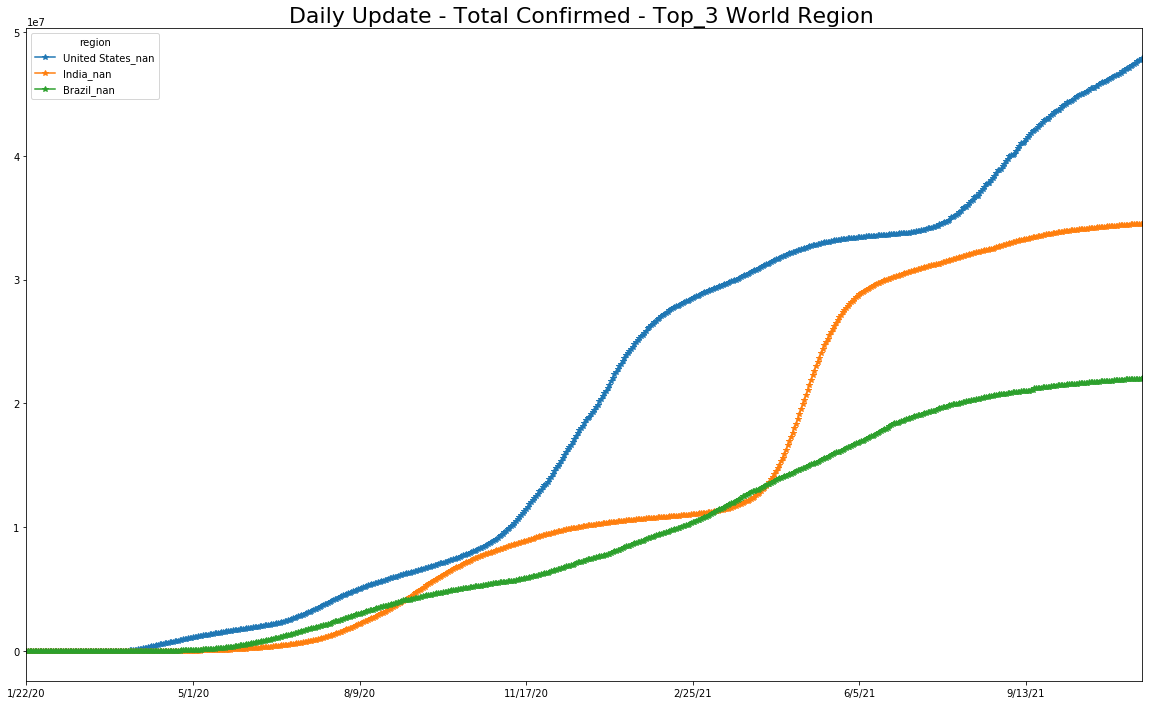

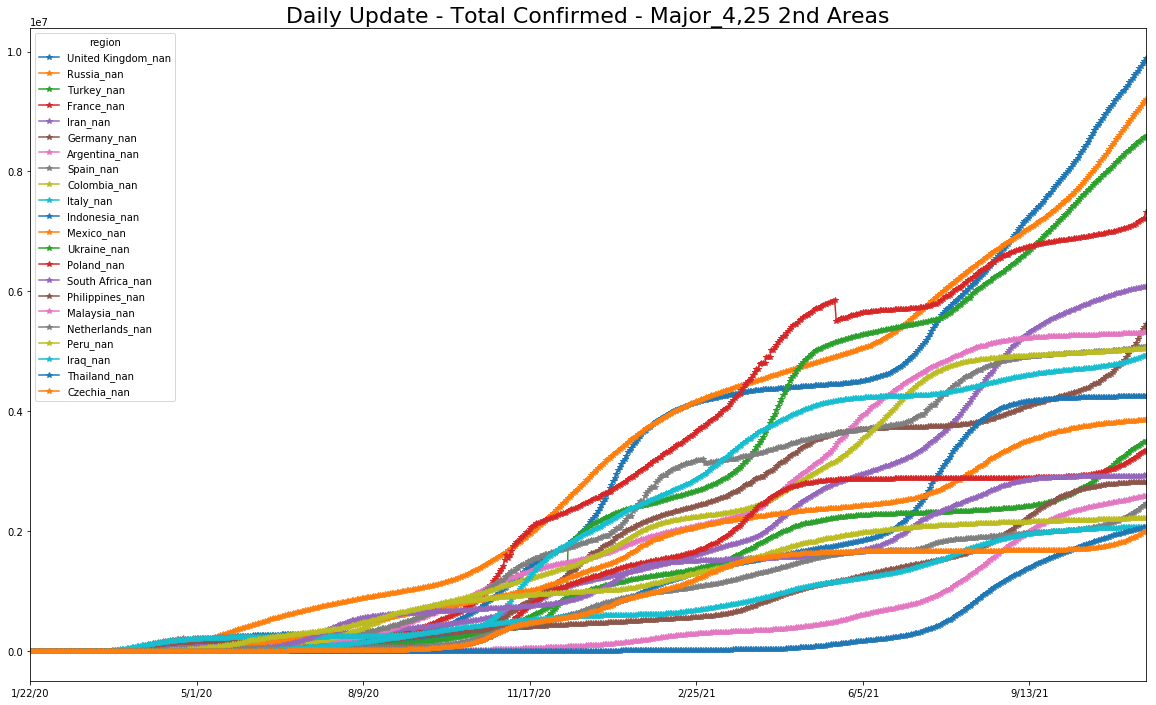

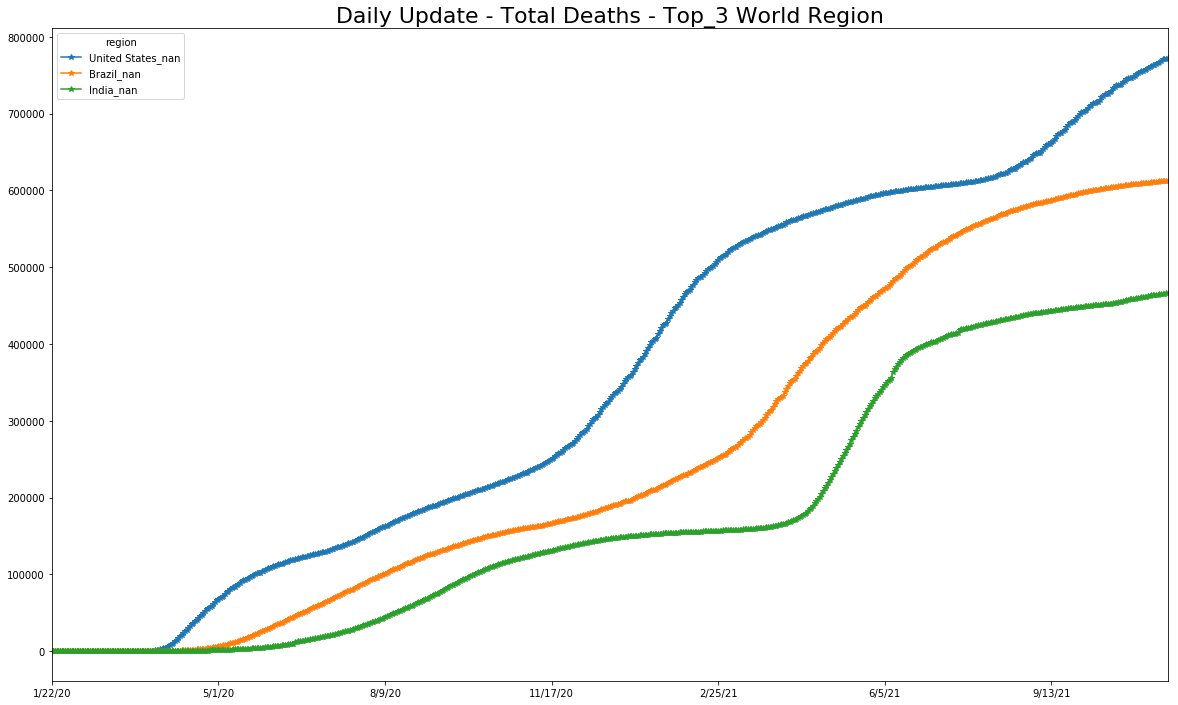

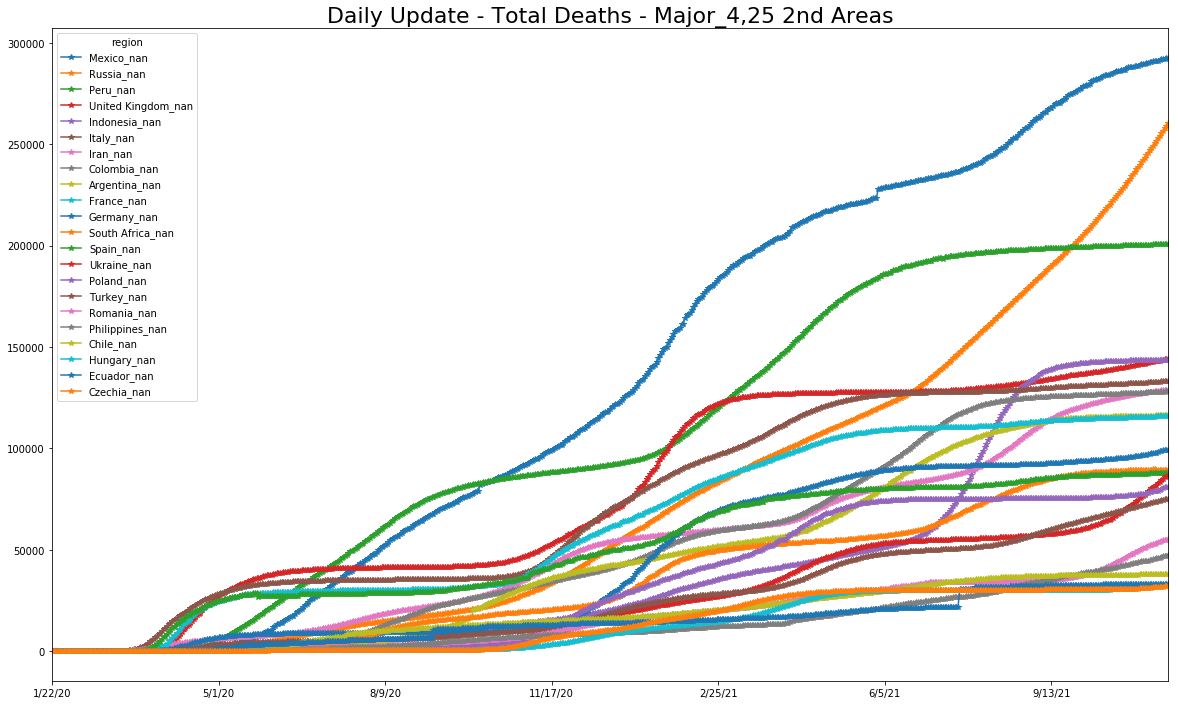

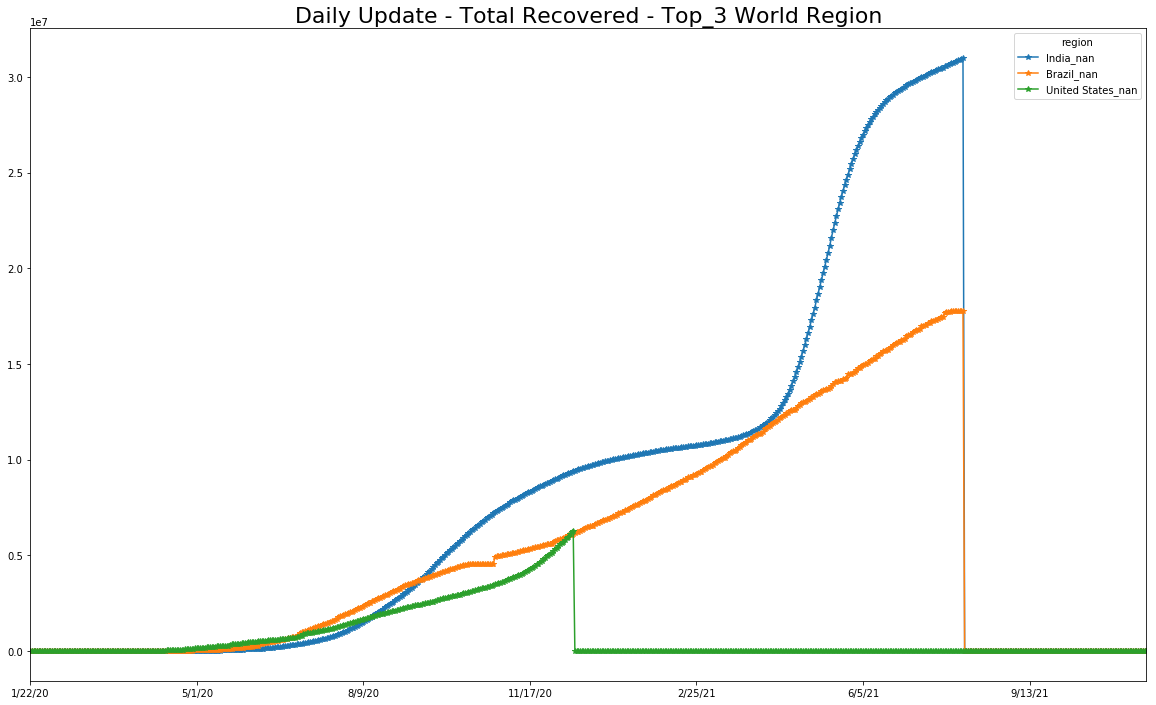

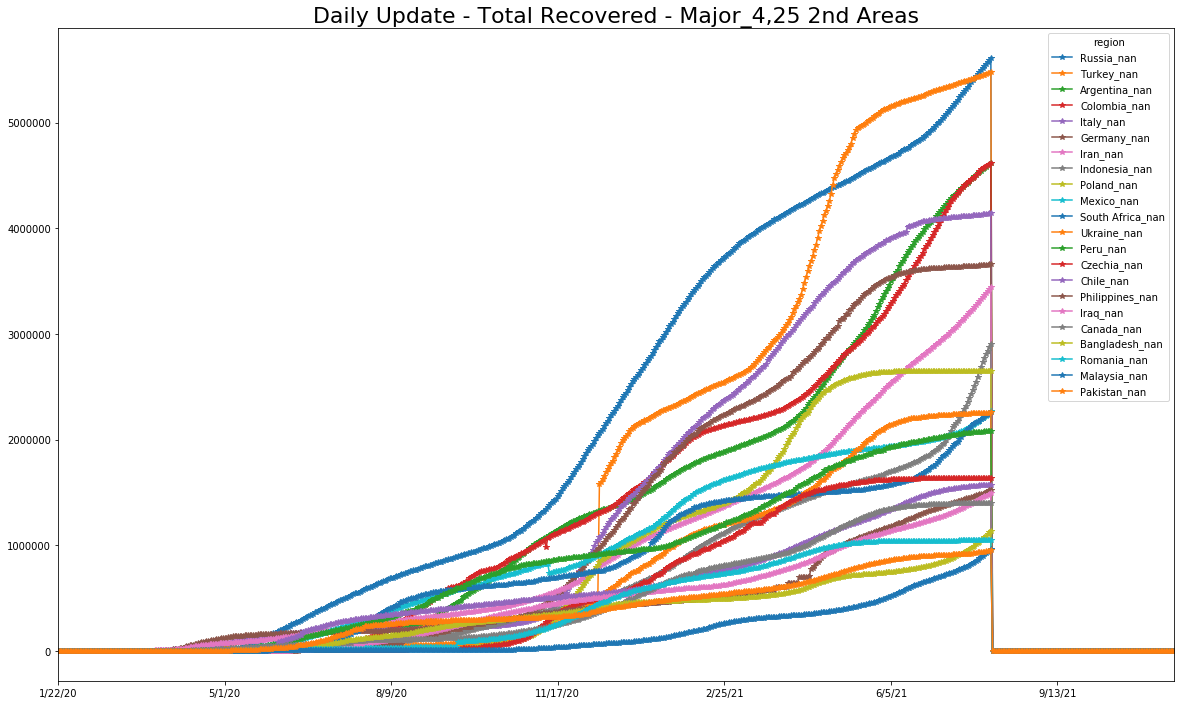

In [17]:
#
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Top_3 World Region ',fontdict={'fontsize': 22})
p.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts_d.max().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Top_3 World Region',fontdict={'fontsize': 22})
p_d.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_r=ts_rec.reindex(ts_rec.max().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Top_3 World Region',fontdict={'fontsize': 22})
p_r.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

### Extract Weather Data

In [18]:
#!pip install pyweatherbit
#
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 

### API - Joao
from datetime import datetime

#
api_key="29d9e51c56b94621b16297bcdeee9c4d" # hxj@mail.xcom
#

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.

#api.get_forecast(lat='Lat', lon='Lon')
#my_end_date=datetime.today().strftime('%Y-%m-%d')

#### United Kingdom
#lat1='55.378100'
#lon1='-3.436000'
#api.get_history(lat=lat1,lon=lon1, start_date='2020-03-29',end_date=my_end_date)


In [19]:
##
#### My List of Countries and Regions to train and represent data
my_train_list=[
 ### JOAO - LIST of Countries - Start here
     #   'Andorra_nan', 
        'United States_nan',
        'United Kingdom_nan',
        'Italy_nan',
        'Spain_nan',  
        'Netherlands_nan',
        'France_nan', 
        'Belgium_nan',
        'Portugal_nan',
        'Switzerland_nan',
        'Germany_nan',
        'Japan_nan',
        'Poland_nan',
  ### JOAO - LIST of Countries - Finish here
        'Korea, South_nan',
        'China_Hubei',
        'China_Beijing',
        'China_Guangdong',
        'China_Shanghai',
      #  'China_Shanxi',
      #  'China_Sichuan',  'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'China_Anhui', 'China_Beijing',
      #  'China_Chongqing', 'China_Fujian', 'China_Gansu',
      #  'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
      #  'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
      #  'China_Hubei', 'China_Hunan', 'China_Inner Mongolia',
      #  'China_Jiangsu', 'China_Jiangxi', 'China_Jilin', 'China_Liaoning',
      #  'China_Ningxia', 'China_Qinghai', 'China_Shaanxi',
      #  'China_Shandong', 'China_Shanghai', 'China_Shanxi',
      #  'China_Sichuan', 'China_Tianjin', 'China_Tibet', 'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'Morocco_nan',
        'Australia_New South Wales',
      # 'Australia_Queensland',
      # 'Australia_South Australia', 'Australia_Victoria', 
        'Brazil_nan',
      # 'Cambodia_nan',
      # 'Canada_British Columbia',
        'Canada_Ontario',
        'Canada_Quebec',
      # 'Egypt_nan',
        'China_Hong Kong',
        'China_Macau',
        'Finland_nan',
        'India_nan',
        'Iran_nan',
        'Malaysia_nan',
      # 'Nepal_nan',
        'Norway_nan',
        'Philippines_nan', 'Russia_nan', 'Singapore_nan',
     #  'Sri Lanka_nan', 'Thailand_nan', 'United Arab Emirates_nan',
        'Sweden_nan',
        'Austria_nan',
     #  'Taiwan*_nan', 
     #  'Vietnam_nan',
        'Turkey_nan',
        'Peru_nan',
        'Chile_nan',
        'Mexico_nan'
       ]
#

#### Weather History

In [20]:
# ################## already done since API is limited to 500 call per day
## consume Wether data From 15/03/2020 forward to end_date=30/03/2020
#
### Location in confirmed array to start in pos 1='Albania_nan' 61 = 'China_Hong Kong'
### Only run for Countries in above : my_train_list 
vpos=len(confirmed.iloc[1])-1 #90# 89 #88 #87 #86 #85 #84 #83 #82 #81 #80 #79 #78 #77 #76 #75 #74 #1 #73
print('xcountry_region='+confirmed.iloc[1,vpos])

my_weather_fetch_list= my_train_list # ['Canada_Quebec'] #  ['Iran_nan'] #['Brazil_nan'] #

start_date_init=pd.to_datetime('today').strftime('%Y/%m/%d') # '2020-04-18'
print('start_date_init=',start_date_init)
offset_days=-1 # -1 to start yesterday pick today # API free-tier just picks one per api call!
max_days=1 #1

w=pd.DataFrame(columns=['date','region','min','max'])
if bypass_weather != 1 :
    for h in range(0,max_days):
        offset_days=h
        start_date=pd.to_datetime(start_date_init)
        #
        end_date=(start_date+pd.DateOffset(days=offset_days+1)).strftime('%Y-%m-%d')
        start_date=(start_date+pd.DateOffset(days=offset_days)).strftime('%Y-%m-%d')
        prnt_start_date=pd.to_datetime(start_date).strftime('%Y/%m/%d')
        prnt_end_date=pd.to_datetime(end_date).strftime('%Y/%m/%d')
        #
        for i in range (1,len(confirmed)):
            if confirmed.iloc[i,vpos] not in my_weather_fetch_list:
                continue
            if confirmed.iloc[i,vpos] in my_weather_fetch_list:
                #
                # Clean JSON structure return from API Call
                jas=""
                jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date,end_date=end_date).json
                if (((json_normalize(jas['data'])['min_temp'].values[0])=='')
                     or (np.isnan((json_normalize(jas['data'])['min_temp'].values[0])) == True )):
                    continue
                try:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
                except Exception:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':None,'max':None}, ignore_index=True)
    #        
#
table_columns=['date','region','min','max']
w = w[w.columns.intersection(table_columns)]

xcountry_region=Albania_nan
start_date_init= 2021/11/23


In [21]:
w.to_csv('data/w_v2_v227.csv', index = False, header=True)

In [22]:
w[:]

Empty DataFrame
Columns: [date, region, min, max]
Index: []

## Kalman Filter With R

In [23]:
# Joao - FIX - Improve Performance 
### Drop the Months of Jan, Feb < 06/02 as
### they are too in the Past and model no longuer trains in China Hubei only!
#
## DROP_N=75 => 07/04

drop_n=drop_n_dataset_days

ts=ts[drop_n:]
ts_d=ts_d[drop_n:]
ts_rec=ts_rec[drop_n:]

In [24]:
ts[:3]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
4/13/21            57364       128752       118799        12614       23697   
4/14/21            57492       128959       118975        12641       23841   
4/15/21            57534       129128       119142        12641       23951   

region   Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
4/13/21                     1201        2579000       204053   
4/14/21                     1201        2604157       205128   
4/15/21                     1209        2629156       206142   

region   Australia_Australian Capital Territory  Australia_New South Wales  \
4/13/21                                     123                       5347   
4/14/21                                     123                       5356   
4/15/21                                     123                       5363   

region   ...  United States_nan  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  \
4/13/21  ...           31420461       149430           85291            3   
4/14/21  ...           31495777       152089           85503            3   
4/15/21  ...           31569687       156499           85730            3   

region   Venezuela_nan  Vietnam_nan  West Bank and Gaza_nan  Yemen_nan  \
4/13/21         176972         2714                  272767       5507   
4/14/21         178094         2733                  274690       5582   
4/15/21         179365         2758                  276407       5657   

region   Zambia_nan  Zimbabwe_nan  
4/13/21       90218         37330  
4/14/21       90389         37369  
4/15/21       90532         37422  

[3 rows x 280 columns]

In [25]:
ts[-4:]

region    Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
11/19/21           156812       195523       208695        16086       64997   
11/20/21           156864       195988       208839        16086       65011   
11/21/21           156896       195988       208952        16086       65024   
11/22/21           156911       196611       209111        16299       65033   

region    Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
11/19/21                     4131        5313607       332713   
11/20/21                     4135        5314702       333583   
11/21/21                     4135        5315348       334075   
11/22/21                     4136        5315989       334347   

region    Australia_Australian Capital Territory  Australia_New South Wales  \
11/19/21                                    2027                      79646   
11/20/21                                    2042                      79821   
11/21/21                                    2053                      79997   
11/22/21                                    2072                      80163   

region    ...  United States_nan  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  \
11/19/21  ...           47660379       397549          190850            6   
11/20/21  ...           47701872       397712          191122            6   
11/21/21  ...           47730591       397841          191334            6   
11/22/21  ...           47888171       397990          191576            6   

region    Venezuela_nan  Vietnam_nan  West Bank and Gaza_nan  Yemen_nan  \
11/19/21         423633      1075094                  457950       9954   
11/20/21         424441      1084625                  457950       9955   
11/21/21         425213      1094514                  457950       9955   
11/22/21         426014      1104835                  458448       9961   

region    Zambia_nan  Zimbabwe_nan  
11/19/21      210043        133593  
11/20/21      210057        133615  
11/21/21      210070        133647  
11/22/21      210073        133674  

[4 rows x 280 columns]

In [26]:
# Create data for R script
ts_conf=ts.reset_index()
ts_conf=ts_conf.rename(columns = {'index':'date'})
ts_conf['date']=pd.to_datetime(ts_conf['date'] ,errors ='coerce')
ts_conf.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv')

ts_rec=ts_rec.reset_index()
ts_rec=ts_rec.rename(columns = {'index':'date'})
ts_rec['date']=pd.to_datetime(ts_rec['date'] ,errors ='coerce')
ts_rec.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_rec_r.csv')


ts_d=ts_d.reset_index()
ts_d=ts_d.rename(columns = {'index':'date'})
ts_d['date']=pd.to_datetime(ts_d['date'] ,errors ='coerce')
ts_d.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_d_r.csv')


In [27]:
%%R

#install.packages('pracma')
#install.packages('Metrics')
#install.packages('readr')
#install.packages('reshape')

Sys.setenv(TZ='GMT')
Sys.timezone()

[1] "GMT"


In [28]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: pracma

R[write to console]: Loading required package: Metrics

R[write to console]: Loading required package: readr

R[write to console]: 
── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [29]:
p=%R pred_all

In [30]:
############ Merge R output due to package problem
### Joao FIX - 
# t=ts_d    -  deaths
# t=ts_rec  -  recovered
# t=ts      -  confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

# JOAO - FIX - temp fixed
# Y,X,X2 nan issue from p revolved

p_pd=pd.DataFrame(p,columns=['Y','X','X2'])

p_pd['nindex'] = range(1, 1+len(p_pd))
temp['nindex']= range(1,1+len(temp))

#temp_1 = temp.join(p_pd)
temp_1 = temp.merge(p_pd, on='nindex', how='inner', suffixes=('_1', '_2')).rename(columns={"Y_2": "Y", "X_2": "X", "X2_2" : "X2"})
temp_1 = temp_1.drop(columns=['Y_1', 'X_1','X2_1','nindex'])


temp=temp_1
temp.to_csv(r'/home/notebookuser/notebooks/covid19/data/temp.csv')

## Pre Proccessing Data for ML Model

### Extract Weather Forecast Data

In [31]:
#
### Joao - Test Later Weather from new file : w_v2.csv and w_v2_v2.csv
w_v2=pd.read_csv('data/w_v2.csv', sep=',', encoding='latin1')
w_v2['date']=pd.to_datetime(w_v2['date'],format='%Y/%m/%d')

w_v2_v2=pd.read_csv('data/w_v2_v2.csv', sep=',', encoding='latin1')
w_v2_v2['date']=pd.to_datetime(w_v2_v2['date'],format='%Y/%m/%d')

w_v2_v227=pd.read_csv('data/w_v2_v227.csv', sep=',', encoding='latin1')
w_v2_v227['date']=pd.to_datetime(w_v2_v227['date'],format='%Y/%m/%d')

w=pd.read_csv('data/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')

w_forecast=pd.read_csv('data/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Append Weather fetched now to file w_v2_v2
w_n_forward=w_v2_v2.append(w_v2_v227) 
w_n_forward=w_n_forward.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_n_forward=w_n_forward.sort_values(by=['region','date'], ascending=True)
w_n_forward.to_csv(r'data/w_v2_v2.csv', index = False, header=True)

In [32]:
w_total=pd.DataFrame(columns=['date','region','min','max'])
w_total=w.append(w_forecast).append(w_v2).append(w_v2_v2).append(w_v2_v227) 
w_total=w_total.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_total=w_total.sort_values(by=['region','date'], ascending=True)

w_total.to_csv(r'data/w_total.csv', index = False, header=True)

In [33]:
w_in_model=pd.read_csv('data/w_total.csv', sep=',', encoding='latin1')
#
w_in_model['date']=pd.to_datetime(w_in_model['date'],format='%Y/%m/%d')
w_in_model.to_csv(r'data/w_in_model.csv', index = False, header=True)

In [34]:
w_in_model.tail(2)

date       region   min   max
8379 2020-05-10  Vietnam_nan  26.9  33.0
8380 2020-05-11  Vietnam_nan  25.0  33.0

### Build Train Set Data Structure

In [35]:
### JOAO - Fix -
## t=ts confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [36]:
### JOAO - Fix -
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
#
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
for i in range(1,len(t)):
    if(t.iloc[i,1] is t.iloc[i-2,1]):
        t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
        t.iloc[i,6]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-2,2]*100 -1 +1))*100
        t.iloc[i,9]=t.iloc[i-1,2]
    if(t.iloc[i,1] is t.iloc[i-4,1]):
        t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
        t.iloc[i,7]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-4,2]*100 -1 +1))*100
    if(t.iloc[i,1] is t.iloc[i-8,1]):
        t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
        t.iloc[i,8]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-8,2]*100 -1 +1))*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)

### Joao - Fix NaN Kalman_Filter
t['kalman_prediction']=np.nan_to_num(t['kalman_prediction'])
t['kalman_prediction']=round(t['kalman_prediction'])

#
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(10000000) ### Fill 10M if nan
train['population']=train['population'].astype('int32')
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
# train['infected_rate']=train['last_day']/train['population']*10000
train['infected_rate']=(((train['last_day'] +1)*100)/((train['population'] +1)*100000) *10) # *100 - % converter
 #
#### Joao , merge w weather only !?!
##train=train.merge(w,how='left',on=['date','region'])
train=train.merge(w_in_model,how='left',on=['date','region'])
#
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
    if(np.isnan(train.iloc[i,13])):
        if(train.iloc[i,1] is train.iloc[i-1,1]):
            train.iloc[i,13]=train.iloc[i-1,13]
            train.iloc[i,14]=train.iloc[i-1,14]

/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


In [37]:
# Joao - Fix - Nulls are an issue
train_notnull=train[train['kalman_prediction'] != 0.0 ] #.any(axis=1)]
train_notnull[:]

date           region  confirmed  1_day_change  3_day_change  \
1     2021-04-14  Afghanistan_nan      57492             0             0   
2     2021-04-15  Afghanistan_nan      57534           128             0   
3     2021-04-16  Afghanistan_nan      57612            42             0   
4     2021-04-17  Afghanistan_nan      57721            78           248   
5     2021-04-18  Afghanistan_nan      57793           109           229   
6     2021-04-19  Afghanistan_nan      57898            72           259   
7     2021-04-20  Afghanistan_nan      58037           105           286   
8     2021-04-21  Afghanistan_nan      58214           139           316   
9     2021-04-22  Afghanistan_nan      58312           177           421   
10    2021-04-23  Afghanistan_nan      58542            98           414   
11    2021-04-24  Afghanistan_nan      58730           230           505   
12    2021-04-25  Afghanistan_nan      58843           188           516   
13    2021-04-26  Afghanistan_nan      59015           113           531   
14    2021-04-27  Afghanistan_nan      59225           172           473   
15    2021-04-28  Afghanistan_nan      59370           210           495   
16    2021-04-29  Afghanistan_nan      59576           145           527   
17    2021-04-30  Afghanistan_nan      59745           206           561   
18    2021-05-01  Afghanistan_nan      59939           169           520   
19    2021-05-02  Afghanistan_nan      60122           194           569   
20    2021-05-03  Afghanistan_nan      60300           183           546   
21    2021-05-04  Afghanistan_nan      60563           178           555   
22    2021-05-05  Afghanistan_nan      60797           263           624   
23    2021-05-06  Afghanistan_nan      61162           234           675   
24    2021-05-07  Afghanistan_nan      61455           365           862   
25    2021-05-08  Afghanistan_nan      61755           293           892   
26    2021-05-09  Afghanistan_nan      61842           300           958   
27    2021-05-10  Afghanistan_nan      62063            87           680   
28    2021-05-11  Afghanistan_nan      62403           221           608   
29    2021-05-12  Afghanistan_nan      62718           340           648   
30    2021-05-13  Afghanistan_nan      63045           315           876   
...          ...              ...        ...           ...           ...   
64320 2021-10-25     Zimbabwe_nan     132688            63           111   
64321 2021-10-26     Zimbabwe_nan     132724            37           100   
64322 2021-10-27     Zimbabwe_nan     132808            36           136   
64323 2021-10-28     Zimbabwe_nan     132880            84           157   
64324 2021-10-29     Zimbabwe_nan     132926            72           192   
64325 2021-10-30     Zimbabwe_nan     132926            46           202   
64326 2021-10-31     Zimbabwe_nan     132977             0           118   
64327 2021-11-01     Zimbabwe_nan     133007            51            97   
64328 2021-11-02     Zimbabwe_nan     133047            30            81   
64329 2021-11-03     Zimbabwe_nan     133091            40           121   
64330 2021-11-04     Zimbabwe_nan     133112            44           114   
64331 2021-11-05     Zimbabwe_nan     133112            21           105   
64332 2021-11-06     Zimbabwe_nan     133168             0            65   
64333 2021-11-07     Zimbabwe_nan     133187            56            77   
64334 2021-11-08     Zimbabwe_nan     133205            19            75   
64335 2021-11-09     Zimbabwe_nan     133242            18            93   
64336 2021-11-10     Zimbabwe_nan     133302            37            74   
64337 2021-11-11     Zimbabwe_nan     133329            60           115   
64338 2021-11-12     Zimbabwe_nan     133329            27           124   
64339 2021-11-13     Zimbabwe_nan     133393             0            87   
64340 2021-11-14     Zimbabwe_nan     133428            64  

In [38]:
# Joao - Fix - Nulls are an issue
train_nulls=train[train['kalman_prediction'].isnull() ] #.any(axis=1)]
train_nulls[:]

Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [39]:
# Joao - Fix - Nulls are an issue

train_nulls=train[train.isnull().any(axis=1)]
train_nulls[:]
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
64349 2021-11-23  Zimbabwe_nan          0            27            81   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
64349           236          100.02021         100.060639         100.176869   

       last_day  kalman_prediction  population  infected_rate  min  max  
64349    133674           133707.0    14862924        0.00009  NaN  NaN

In [40]:
## JOAO - FIX Drop Duplicates
train=train.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
## JOAO - FIX Drop empty region='nan_nan'
train=train[train['region']!='nan_nan']
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
64349 2021-11-23  Zimbabwe_nan          0            27            81   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
64349           236          100.02021         100.060639         100.176869   

       last_day  kalman_prediction  population  infected_rate  min  max  
64349    133674           133707.0    14862924        0.00009  NaN  NaN

In [41]:
train.to_csv(r'data/train.csv', index = False, header=True)

##Shared -- Ratio in Confirmed - 21Day Forecast -- train 25April2020 - I
ratiod=pd.read_csv('data/train.csv', sep=',', encoding='latin1')
todayd=datetime.today().strftime('%Y-%m-%d')
ratiofn="World v2 -- Confirmed - "+str(num_days_R_prediction)+"Day Forecast -- train "+todayd+".csv"

ratiod['population_percentage : infected_rate confirmed']=ratiod['infected_rate']*100
### Assumption : Each affected person can contact up to 9 others that not report or are assimptomatic COVID19 cases.
ratiod['population_percentage : factor 9/10 infected_rate confirmed']=np.clip(ratiod['infected_rate']*900,0.0,1.0)
#
ratiod['delta : pred new_cases']=ratiod['kalman_prediction']-ratiod['last_day']
ratiod['delta : pred new_cases per 1M hab']=ratiod['delta : pred new_cases']/ratiod['population']*1000000

### roling 7day_AVG
ratiod['delta : roling 7day AVG']=ratiod['7_day_change']/7
ratiod['delta : aprox 14-day case notification rate per 100k hab']=(ratiod['7_day_change']*2)/ratiod['population']*100000
###

ratiod=ratiod.rename(columns={'kalman_prediction': 'confirmed_prediction', 'last_day': 'confirmed_yesterday'})
ratiod.to_csv(r'data/'+ratiofn, index = False, header=True)
ratiod[-3:]

date        region  confirmed  1_day_change  3_day_change  \
62997  2021-11-21  Zimbabwe_nan     133647            22            58   
62998  2021-11-22  Zimbabwe_nan     133674            32            54   
62999  2021-11-23  Zimbabwe_nan          0            27            81   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
62997           222         100.016475         100.043435         100.166433   
62998           219         100.023957         100.040429         100.164141   
62999           236         100.020210         100.060639         100.176869   

       confirmed_yesterday  ...  population  infected_rate  min  max  \
62997               133615  ...    14862924        0.00009  NaN  NaN   
62998               133647  ...    14862924        0.00009  NaN  NaN   
62999               133674  ...    14862924        0.00009  NaN  NaN   

       population_percentage : infected_rate confirmed  \
62997                                         0.008990   
62998                                         0.008992   
62999                                         0.008994   

       population_percentage : factor 9/10 infected_rate confirmed  \
62997                                           0.080909             
62998                                           0.080928             
62999                                           0.080945             

       delta : pred new_cases  delta : pred new_cases per 1M hab  \
62997                    50.0                           3.364076   
62998                    38.0                           2.556697   
62999                    33.0                           2.220290   

       delta : roling 7day AVG  \
62997                31.714286   
62998                31.285714   
62999                33.714286   

       delta : aprox 14-day case notification rate per 100k hab  
62997                                           2.987299         
62998                                           2.946930         
62999                                           3.175687         

[3 rows x 21 columns]

## Kalman 1 day Prediction with Evaluation

                region           mse          rmse          mae
270  United States_nan  1.038763e+13  3.222985e+06  276115.0625


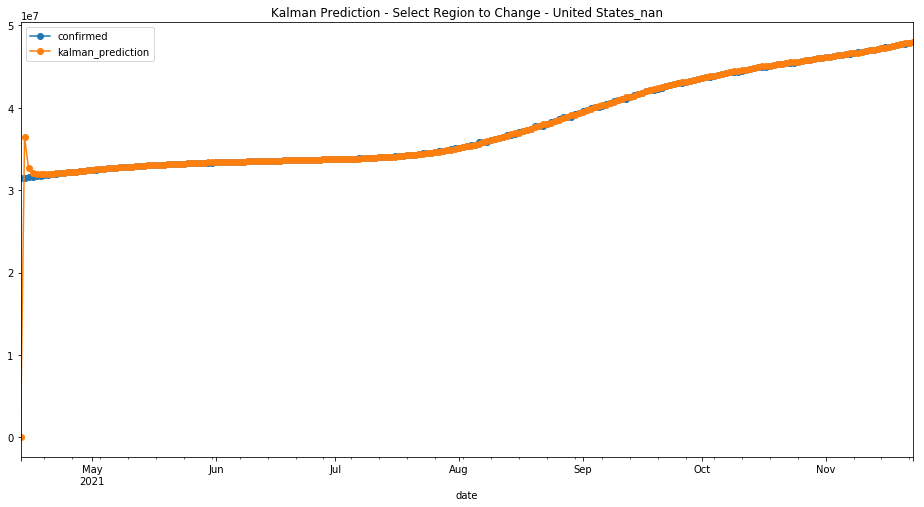

In [42]:
# Select region
region='United States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

         region           mse          rmse           mae
217  Russia_nan  3.838058e+11  619520.58166  47632.879464


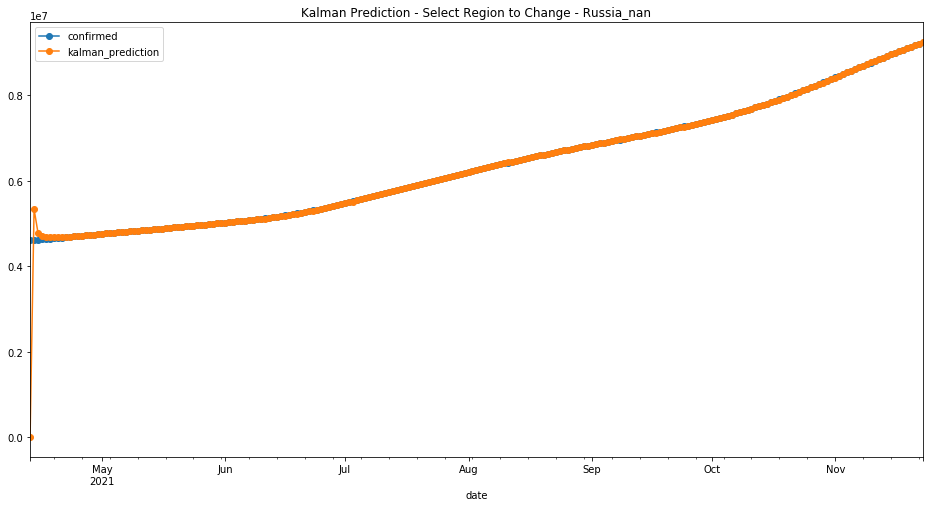

In [43]:
# Select region
region='Russia_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

        region           mse          rmse            mae
30  Brazil_nan  2.188377e+12  1.479317e+06  128360.950893


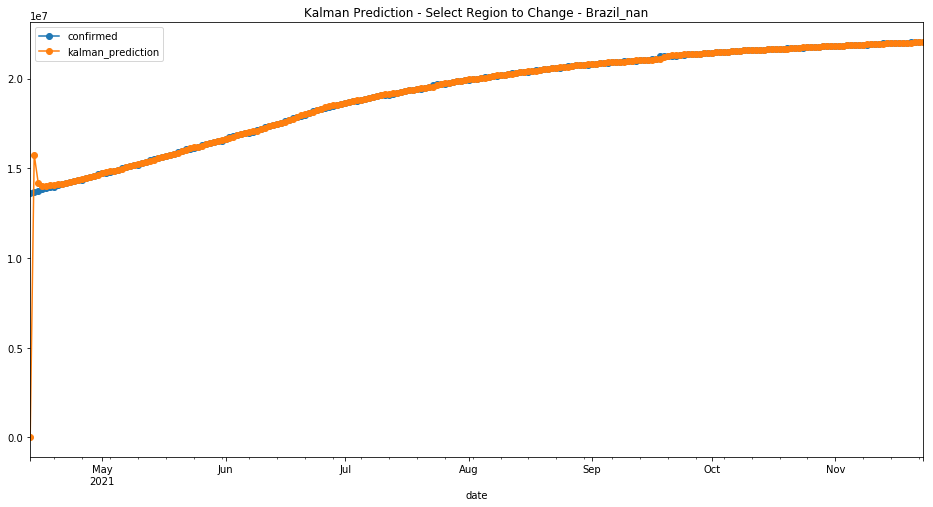

In [44]:
# Select region
region='Brazil_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

                 region           mse           rmse           mae
269  United Kingdom_nan  4.425389e+11  665235.972876  53634.258929


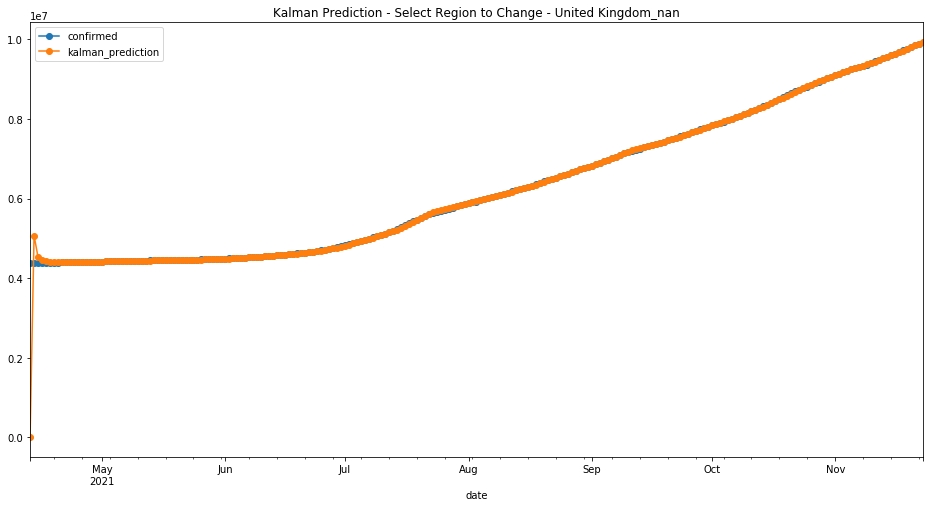

In [45]:
# Select region
region='United Kingdom_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

## Regression - 1 Day Prediction

In [46]:
#!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='3G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04); OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
  Starting server from /home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp6oajqqds
  JVM stdout: /tmp/tmp6oajqqds/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp6oajqqds/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


--------------------------  ----------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/GMT
H2O data parsing timezone:  UTC
H2O cluster version:        3.22.0.1
H2O cluster version age:    3 years and 27 days !!!
H2O cluster name:           H2O_from_python_unknownUser_wdcoco
H2O cluster total nodes:    1
H2O cluster free memory:    3.541 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  8
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.7.7 final
--------------------------  ----------------------------------------

In [47]:

train=train.fillna(0)

########################################################

### Joao - Training  progression - When growth happened 2020/03/05 to 2020/04/12
### Joao - FIX - Refresh this daily forward

### Old Fixed manual ### Last run 17April2020
##
#train_df=train[train['date']>'2020-03-04']
#train_df=train[train['date']<'2020-04-16']
#boots=train_df[train_df['date']>='2020-04-08'] # some bootstrap to give more weight for recent days
#train_df=train_df.append([boots[boots['date']>='2020-04-12']]*1000,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
#region_to_train=my_train_list
#train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
#test=train[train['date']>='2020-04-03']
#test=test[test['date']<'2020-04-17']
#test_v2=test[test['region'].isin(region_to_train)]
#valid_v2=test_v2[test_v2['date']>='2020-04-16']

########################################################

# Set minimum of 14 training day 2weeks.
#
if number_past_days_training>=7 : 
    ntraindays=number_past_days_training 
else : 
    ntraindays=7
#
to_day=pd.to_datetime('today')
first_train_date=(to_day+pd.DateOffset(days=-ntraindays)).strftime('%Y-%m-%d') # ntraindays/7 weeks =ntraindays days training
last_train_date=(to_day+pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
first_bootstrap_date=(to_day+pd.DateOffset(days=-9)).strftime('%Y-%m-%d')
boost_bootstrap_date=(to_day+pd.DateOffset(days=-4)).strftime('%Y-%m-%d')
first_test_date=(to_day+pd.DateOffset(days=-10)).strftime('%Y-%m-%d')
last_test_date=to_day.strftime('%Y-%m-%d')
first_valid_date=(to_day+pd.DateOffset(days=-2)).strftime('%Y-%m-%d')

print('first_train_date=',first_train_date)
print('last_train_date=',last_train_date)
print('first_bootstrap_date=',first_bootstrap_date)
print('boost_bootstrap_date=',boost_bootstrap_date)
print('first_test_date=',first_test_date)
print('last_test_date=',last_test_date)
print('first_valid_date=',first_valid_date)

train_df=train[train['date']>first_train_date]
train_df=train[train['date']<last_train_date]
boots=train_df[train_df['date']>=first_bootstrap_date] # some bootstrap to give more weight for recent days
train_df=train_df.append([boots[boots['date']>=boost_bootstrap_date]]*5,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
region_to_train=my_train_list
train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
test=train[train['date']>first_test_date]
test=test[test['date']<=last_test_date]
test_v2=test[test['region'].isin(region_to_train)]
valid_v2=test_v2[test_v2['date']>=first_valid_date]


first_train_date= 2021-10-27
last_train_date= 2021-11-22
first_bootstrap_date= 2021-11-14
boost_bootstrap_date= 2021-11-19
first_test_date= 2021-11-13
last_test_date= 2021-11-23
first_valid_date= 2021-11-21


In [48]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            '1_day_change_rate', 
            '3_day_change_rate',
            '7_day_change_rate', 
            'last_day',
            'min', 'max',
            'infected_rate',
            'kalman_prediction'
          #  ,'population_percent_infected_rate_confirmed'
          #  ,'delta_new_cases'
          #  ,'delta_new_cases_per_1M_hab'
          ]

In [49]:
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col]); pred2=pd.DataFrame(pred2); pred2=round(pred2)
pred2['confirmed']=test['confirmed'].values; pred2['date']=test['date'].values; pred2['region']=test['region'].values


In [50]:
pred2.iloc[:25]

0  confirmed       date           region
0   157559.0     156552 2021-11-14  Afghanistan_nan
1   157594.0     156610 2021-11-15  Afghanistan_nan
2   157647.0     156649 2021-11-16  Afghanistan_nan
3   157706.0     156739 2021-11-17  Afghanistan_nan
4   157771.0     156739 2021-11-18  Afghanistan_nan
5   157839.0     156812 2021-11-19  Afghanistan_nan
6   157874.0     156864 2021-11-20  Afghanistan_nan
7   157937.0     156896 2021-11-21  Afghanistan_nan
8   157988.0     156911 2021-11-22  Afghanistan_nan
9   158015.0          0 2021-11-23  Afghanistan_nan
10  193560.0     193075 2021-11-14      Albania_nan
11  194101.0     193269 2021-11-15      Albania_nan
12  194459.0     193856 2021-11-16      Albania_nan
13  194774.0     194472 2021-11-17      Albania_nan
14  195288.0     195021 2021-11-18      Albania_nan
15  195847.0     195523 2021-11-19      Albania_nan
16  196377.0     195988 2021-11-20      Albania_nan
17  196869.0     195988 2021-11-21      Albania_nan
18  197142.0     196611 2021-11-22      Albania_nan
19  197386.0          0 2021-11-23      Albania_nan
20  208984.0     207970 2021-11-14      Algeria_nan
21  209095.0     208104 2021-11-15      Algeria_nan
22  209211.0     208245 2021-11-16      Algeria_nan
23  209346.0     208380 2021-11-17      Algeria_nan
24  209487.0     208532 2021-11-18      Algeria_nan

In [51]:
pred2.iloc[175:195]

0  confirmed       date          region
175  570230.0     570322 2021-11-19  Azerbaijan_nan
176  572419.0     572085 2021-11-20  Azerbaijan_nan
177  574383.0     573974 2021-11-21  Azerbaijan_nan
178  576296.0     574799 2021-11-22  Azerbaijan_nan
179  577490.0          0 2021-11-23  Azerbaijan_nan
180   23227.0      22572 2021-11-14     Bahamas_nan
181   23224.0      22601 2021-11-15     Bahamas_nan
182   23146.0      22613 2021-11-16     Bahamas_nan
183   23215.0      22629 2021-11-17     Bahamas_nan
184   23224.0      22640 2021-11-18     Bahamas_nan
185   23252.0      22655 2021-11-19     Bahamas_nan
186   23255.0      22655 2021-11-20     Bahamas_nan
187   23307.0      22655 2021-11-21     Bahamas_nan
188   23307.0      22665 2021-11-22     Bahamas_nan
189   23277.0          0 2021-11-23     Bahamas_nan
190  276696.0     277223 2021-11-14     Bahrain_nan
191  276713.0     277246 2021-11-15     Bahrain_nan
192  276734.0     277262 2021-11-16     Bahrain_nan
193  276752.0     277282 2021-11-17     Bahrain_nan
194  276770.0     277304 2021-11-18     Bahrain_nan

In [52]:
pred2.iloc[220:240]

0  confirmed       date       region
220   627768.0     627478 2021-11-14  Belarus_nan
221   629681.0     629271 2021-11-15  Belarus_nan
222   631507.0     631025 2021-11-16  Belarus_nan
223   633262.0     632887 2021-11-17  Belarus_nan
224   635053.0     634731 2021-11-18  Belarus_nan
225   636855.0     636543 2021-11-19  Belarus_nan
226   638649.0     638402 2021-11-20  Belarus_nan
227   640473.0     640206 2021-11-21  Belarus_nan
228   642279.0     641919 2021-11-22  Belarus_nan
229   644018.0          0 2021-11-23  Belarus_nan
230  1497630.0    1484712 2021-11-14  Belgium_nan
231  1499079.0    1512474 2021-11-15  Belgium_nan
232  1517988.0    1524862 2021-11-16  Belgium_nan
233  1532058.0    1543299 2021-11-17  Belgium_nan
234  1550783.0    1559998 2021-11-18  Belgium_nan
235  1569479.0    1581500 2021-11-19  Belgium_nan
236  1591652.0    1581500 2021-11-20  Belgium_nan
237  1599091.0    1581500 2021-11-21  Belgium_nan
238  1601178.0    1623560 2021-11-22  Belgium_nan
239  1630281.0          0 2021-11-23  Belgium_nan

In [53]:
#
train_h20 = h2o.H2OFrame(train_df)
###train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
#
### Joao - Italian Model
train_h20_v2 = h2o.H2OFrame(train_df_v2) # different model for V2 region ### Spain This time


test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)
test_h20_v2 = h2o.H2OFrame(test_v2)

valid_h20_v2=h2o.H2OFrame(valid_v2)

#training_columns = ['region','1_day_change', '3_day_change', '7_day_change','1_day_change_rate','3_day_change_rate','7_day_change_rate','last_day', 'kalman_prediction','infected_rate', 'min', 'max']
training_cols_v2 = ['region']+x_col #+['population_percent_infected_rate_confirmed','delta_new_cases','delta_new_cases_per_1M_hab']
training_columns = training_cols_v2

# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)

###model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
###model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

### Joao - Model V2
model_v2 = H2ORandomForestEstimator(ntrees=500, max_depth=23)
model_v2.train(x=training_columns, y=response_column, training_frame=train_h20_v2, validation_frame=valid_h20_v2)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [54]:
#Print Model

print('# MSE on the training data = ',model_v2.mse())
print('# MSE on the validation data = ',model_v2.mse(valid=True))
print('# R^2 on the training data = ',model_v2.r2())
print('# R^2 on the validation data = ',model_v2.r2(valid=True))

# MSE on the training data =  97089332523.16197
# MSE on the validation data =  39223941008524.59
# R^2 on the training data =  0.998556403001423
# R^2 on the validation data =  0.4277669063133013


In [55]:
model_v2.show()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1637694651528_1


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 97089332523.16197
RMSE: 311591.61176636635
MAE: 16973.40825233479
RMSLE: 0.5361076609385936
Mean Residual Deviance: 97089332523.16197

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 39223941008524.59
RMSE: 6262901.963828317
MAE: 1716432.4000582257
RMSLE: 8.032337121406538
Mean Residual Deviance: 39223941008524.59
Scoring History: 


timestamp            duration    number_of_trees    training_rmse       training_mae        training_deviance    validation_rmse    validation_mae      validation_deviance
---  -------------------  ----------  -----------------  ------------------  ------------------  -------------------  -----------------  ------------------  ---------------------
     2021-11-23 19:11:00  0.094 sec   0.0                nan                 nan                 nan                  nan                nan                 nan
     2021-11-23 19:11:01  0.576 sec   1.0                298847.22028626455  41708.588297736744  89309661072.82712    6287627.38289491   1711757.234918268   39534258106129.89
     2021-11-23 19:11:01  0.801 sec   2.0                484710.2625293092   38889.35222958125   234944038601.23184   6306402.822677656  1713566.638972102   39770716561876.7
     2021-11-23 19:11:01  1.133 sec   3.0                428731.79802132124  33889.1318896687    183810954634.59497   6304039.971571744  1718593.619661898   39740919963174.28
     2021-11-23 19:11:01  1.243 sec   4.0                399371.397131268    31145.59284224382   159497512846.581     6263151.666082303  1716613.0396329863  39227068792349.52
---  ---                  ---         ---                ---                 ---                 ---                  ---                ---                 ---
     2021-11-23 19:11:16  16.177 sec  250.0              318129.0987016766   18118.00298545956   101206123440.74107   6260210.301330891  1715107.848263337   39190233016889.414
     2021-11-23 19:11:20  20.219 sec  330.0              320907.9850869042   17597.557574796487  102981934892.53674   6267616.952336238  1716286.7331925372  39283022261212.59
     2021-11-23 19:11:24  24.252 sec  404.0              317997.3256334497   17360.447337056416  101122299110.02626   6269206.947841335  1716380.4595439644  39302955754862.07
     2021-11-23 19:11:28  28.268 sec  482.0              311480.0702499893   17020.945179551636  97019834162.93825    6266010.661111796  1716656.6516010459  39262889605166.695
     2021-11-23 19:11:30  29.522 sec  500.0              311591.61176636635  16973.40825233479   97089332523.16197    6262901.963828317  1716432.4000582257  39223941008524.59


See the whole table with table.as_data_frame()
Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
kalman_prediction  8.91363e+19            1                    0.339004
last_day           7.42614e+19            0.833122             0.282432
region             5.4555e+19             0.61204              0.207484
7_day_change       1.89102e+19            0.21215              0.0719197
3_day_change       1.23572e+19            0.138633             0.0469971
1_day_change       7.58319e+18            0.0850741            0.0288405
infected_rate      3.25417e+18            0.0365078            0.0123763
7_day_change_rate  1.37828e+18            0.0154626            0.00524188
3_day_change_rate  7.94164e+17            0.00890954           0.00302037
1_day_change_rate  7.05713e+17            0.00791723           0.00268397

In [56]:
#model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF
### Joao -  Model V2
modlv2=model_v2.varimp(True).iloc[:,:] # Feature importance for Model V2 Global RF
modlv2.sort_values('percentage',ascending=False)

variable  relative_importance  scaled_importance  percentage
0  kalman_prediction         8.913630e+19           1.000000    0.339004
1           last_day         7.426138e+19           0.833122    0.282432
2             region         5.455499e+19           0.612040    0.207484
3       7_day_change         1.891024e+19           0.212150    0.071920
4       3_day_change         1.235720e+19           0.138633    0.046997
5       1_day_change         7.583186e+18           0.085074    0.028840
6      infected_rate         3.254167e+18           0.036508    0.012376
7  7_day_change_rate         1.378276e+18           0.015463    0.005242
8  3_day_change_rate         7.941636e+17           0.008910    0.003020
9  1_day_change_rate         7.057126e+17           0.007917    0.002684

In [57]:
## Joao - Model Predictions - Country_nan _v2
performance = model_v2.model_performance(test_data=test_h20_v2)
# # Model Create Predictions
pred=model_v2.predict(test_h20_v2);pred=pred.as_data_frame(); pred=round(pred)
# #pred['daily_outcome']=test['daily_outcome'].values
pred['confirmed']=test_v2['confirmed'].values
pred['date']=test_v2['date'].values
pred['region']=test_v2['region'].values

drf prediction progress: |████████████████████████████████████████████████| 100%


## Correlation Matrix And Temperature

Correlation Matrix


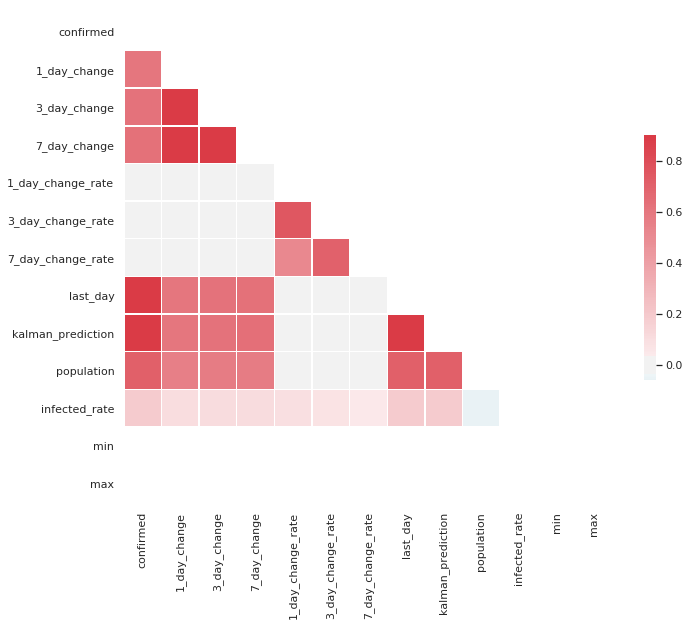

In [58]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [59]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.603854
3_day_change         0.624948
7_day_change         0.633201
1_day_change_rate    0.019268
3_day_change_rate    0.012888
7_day_change_rate    0.005577
last_day             0.994229
kalman_prediction    0.995383
population           0.715520
infected_rate        0.188049
min                       NaN
max                       NaN
Name: confirmed, dtype: float64


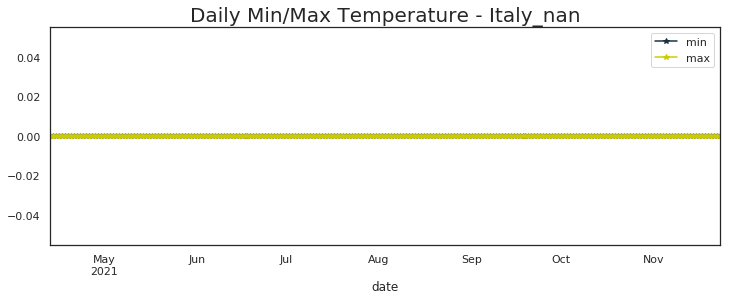

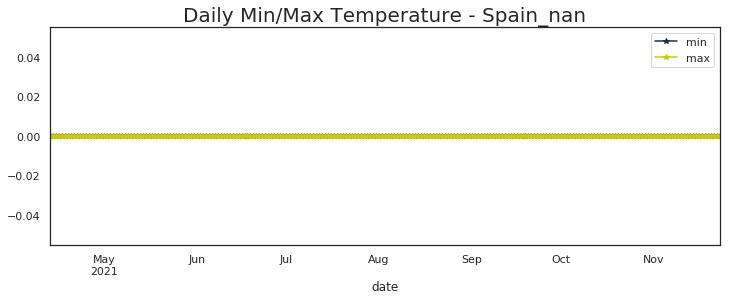

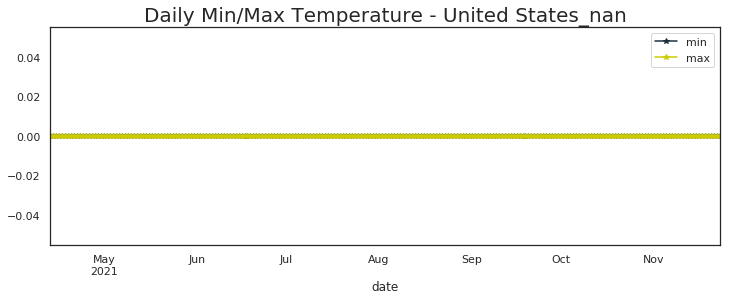

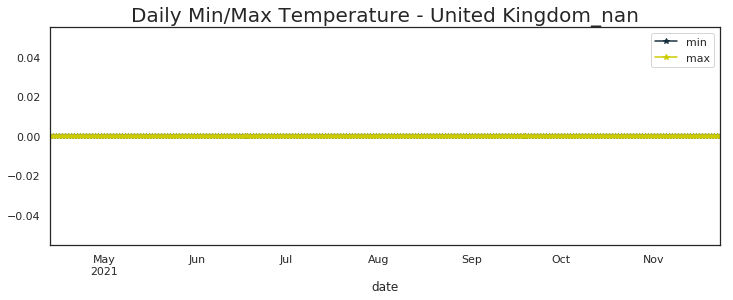

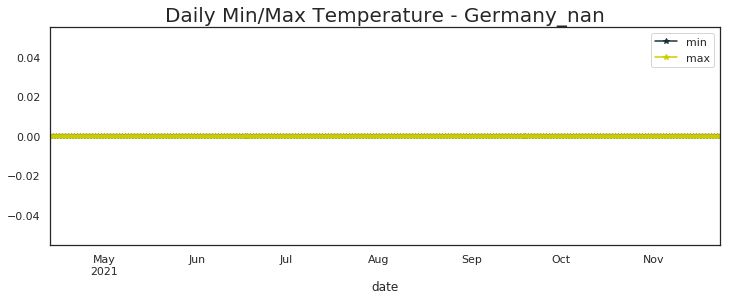

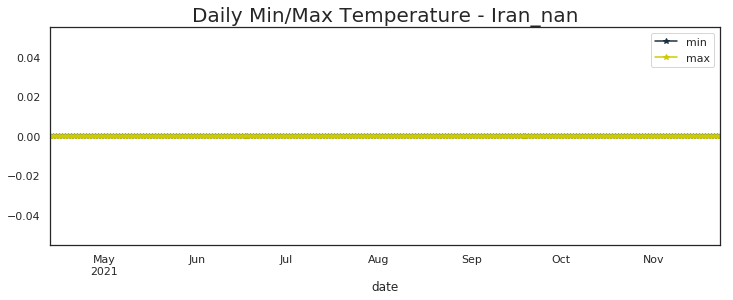

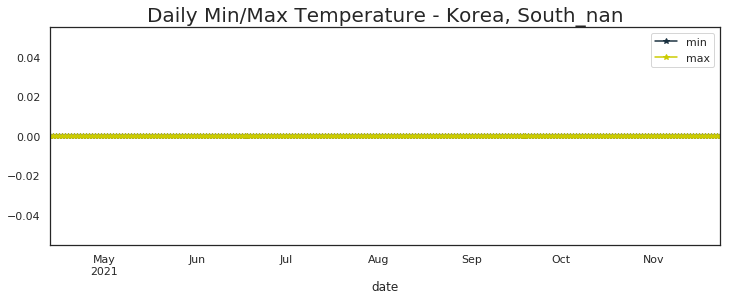

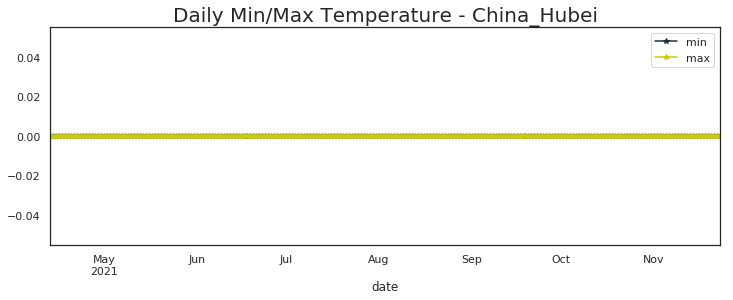

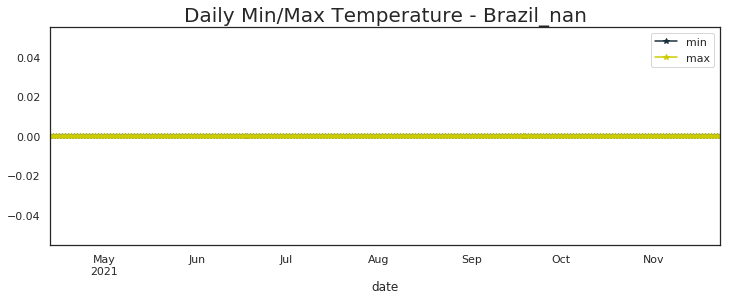

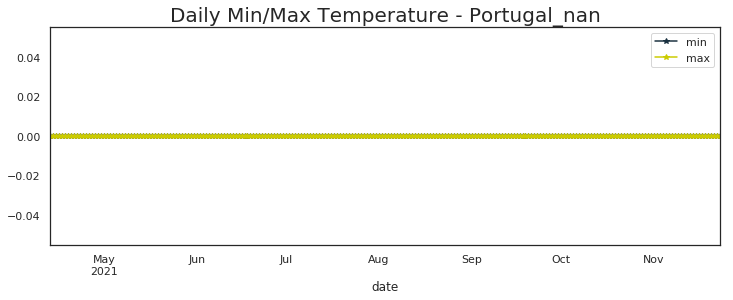

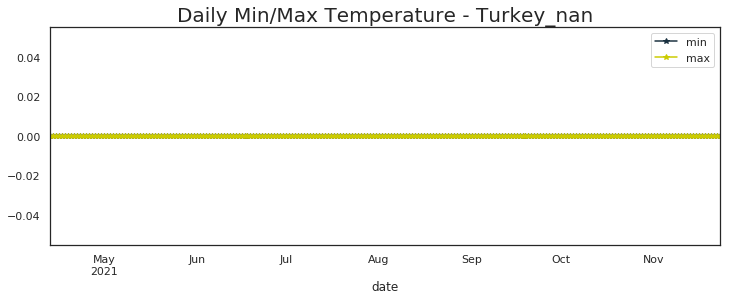

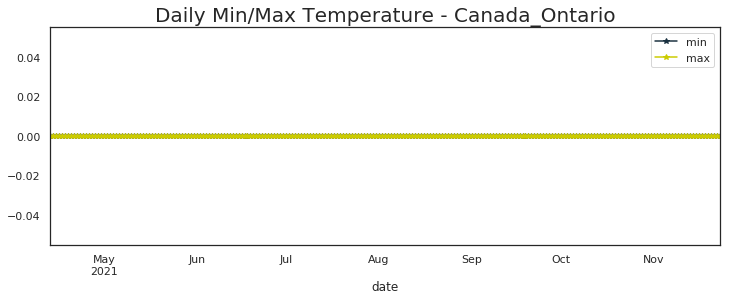

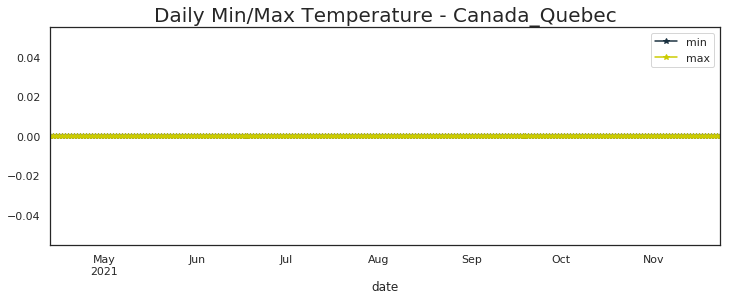

In [60]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
#
#rg1='China_Hubei'
#p=p[p['region']==rg1]
#p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+rg1,fontdict={'fontsize': 20})
#
## JOAO - Temp. Teast Italy - Data Supply finishes 13/03/2020
region_s=['Italy_nan','Spain_nan','United States_nan','United Kingdom_nan','Germany_nan','Iran_nan',
          'Korea, South_nan','China_Hubei','Brazil_nan','Portugal_nan','Turkey_nan',
          'Canada_Ontario','Canada_Quebec']
p=train[['date','region','min','max']].set_index('date')
for i in range(0,len(region_s)):     
    pv=p[p['region']==region_s[i]]
    pv.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+region_s[i],fontdict={'fontsize': 20})
#

In [61]:
avg_temp=train[['region','confirmed','min','max']]  # from 20-02-20 to 06-04-2020
avg_temp=avg_temp.groupby(by='region').max()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:100,1:])

Most infected Areas Avg Temperature
                            min  max
region                              
United States_nan           0.0  0.0
India_nan                   0.0  0.0
Brazil_nan                  0.0  0.0
United Kingdom_nan          0.0  0.0
Russia_nan                  0.0  0.0
Turkey_nan                  0.0  0.0
France_nan                  0.0  0.0
Iran_nan                    0.0  0.0
Germany_nan                 0.0  0.0
Argentina_nan               0.0  0.0
Spain_nan                   0.0  0.0
Colombia_nan                0.0  0.0
Italy_nan                   0.0  0.0
Indonesia_nan               0.0  0.0
Mexico_nan                  0.0  0.0
Ukraine_nan                 0.0  0.0
Poland_nan                  0.0  0.0
South Africa_nan            0.0  0.0
Philippines_nan             0.0  0.0
Malaysia_nan                0.0  0.0
Netherlands_nan             0.0  0.0
Peru_nan                    0.0  0.0
Iraq_nan                    0.0  0.0
Thailand_nan                0.0  0.0
Cz

### Kalman X Days Ahead Prediction

In [62]:
%%R

#install.packages('reshape')

NULL


In [63]:
%%R

require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL

### JOAO - FIX
#
### Flexy Days maximum forward prediction =A Hint!= "Error increases as number of days increases"
days_prediction<-max_days_prediction # Set i days prediction # max_days_prediction=90 days forward prediction with Kalman Filter

for (i in 1: days_prediction) { 
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [64]:
all_new=%R all_new

In [65]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction - Select Country/Region to Change - Spain_nan')

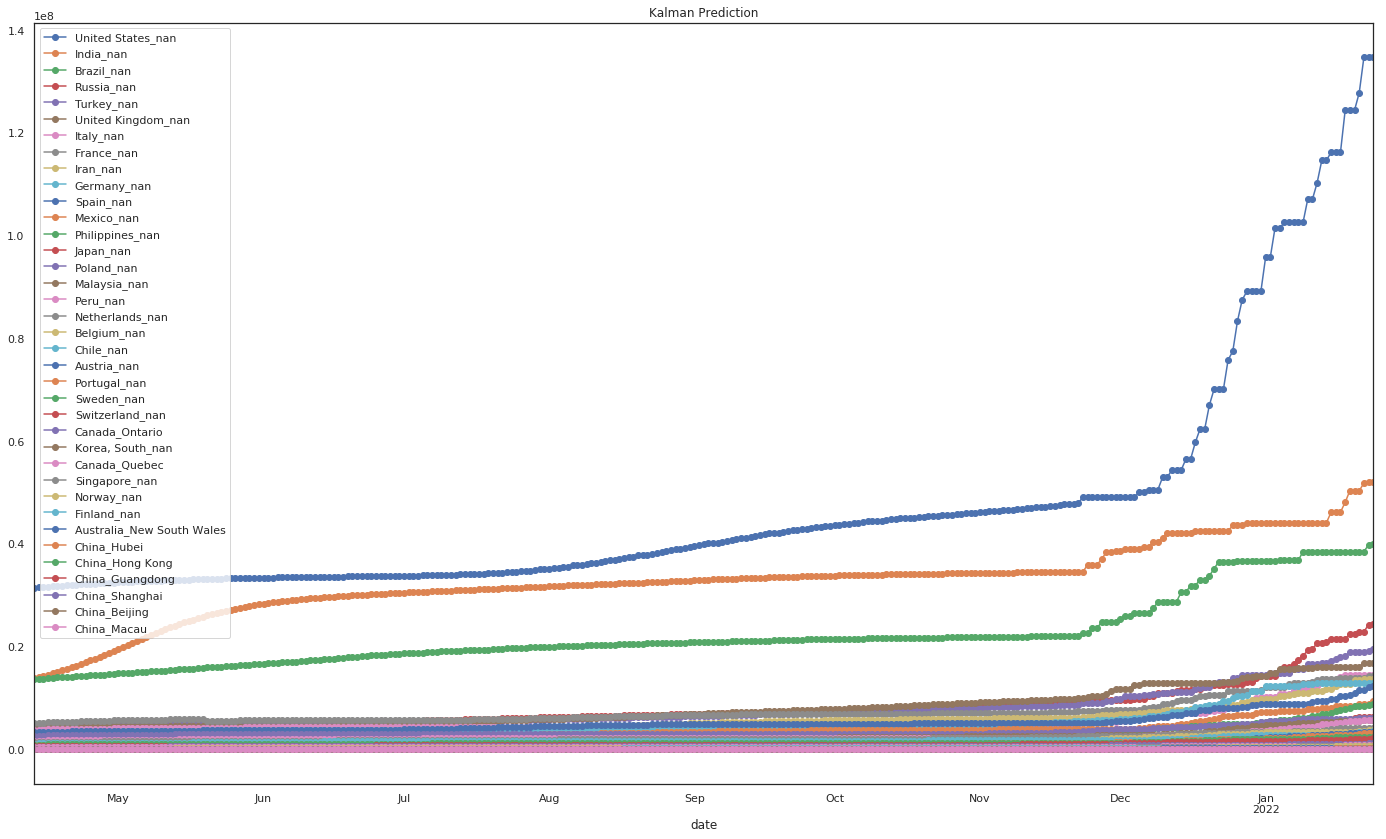

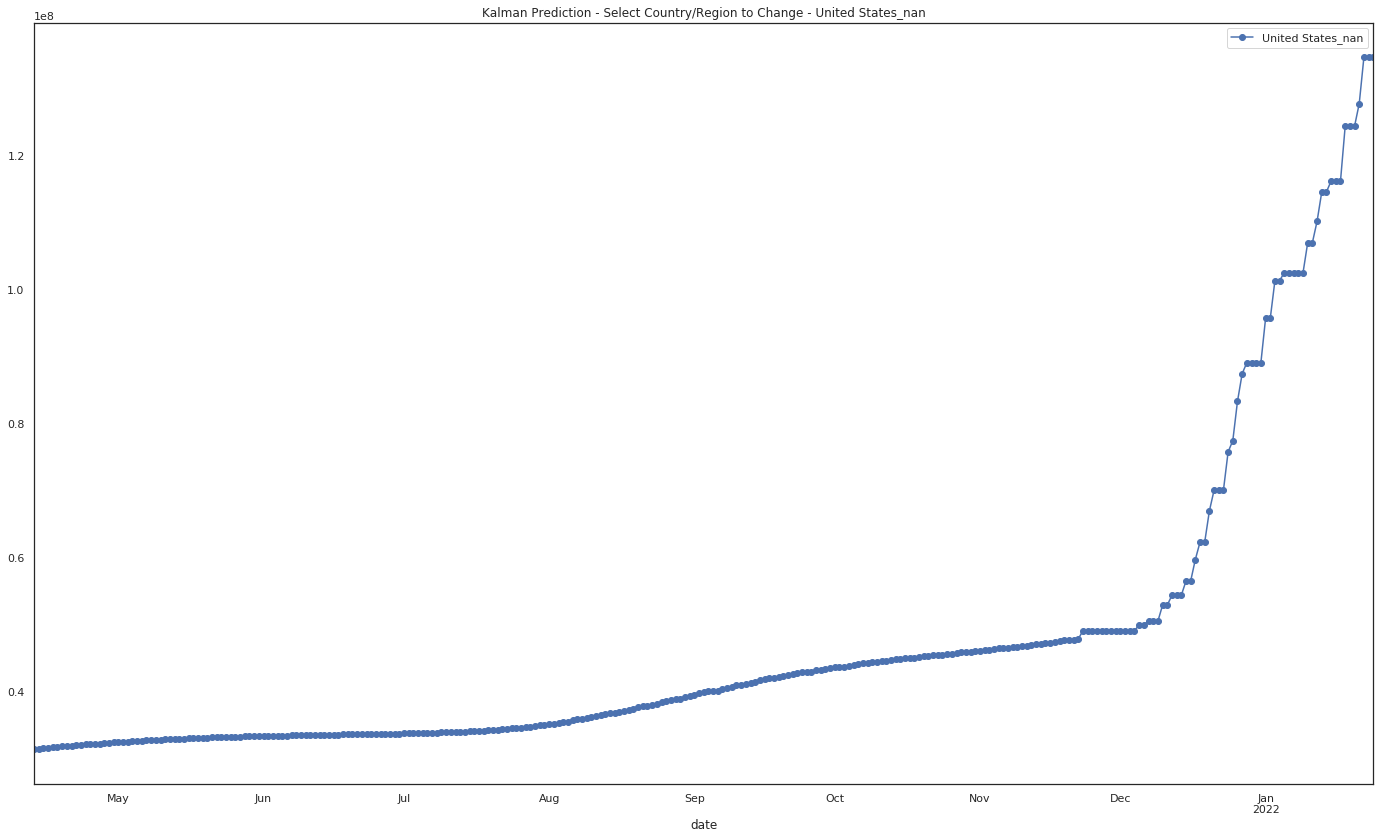

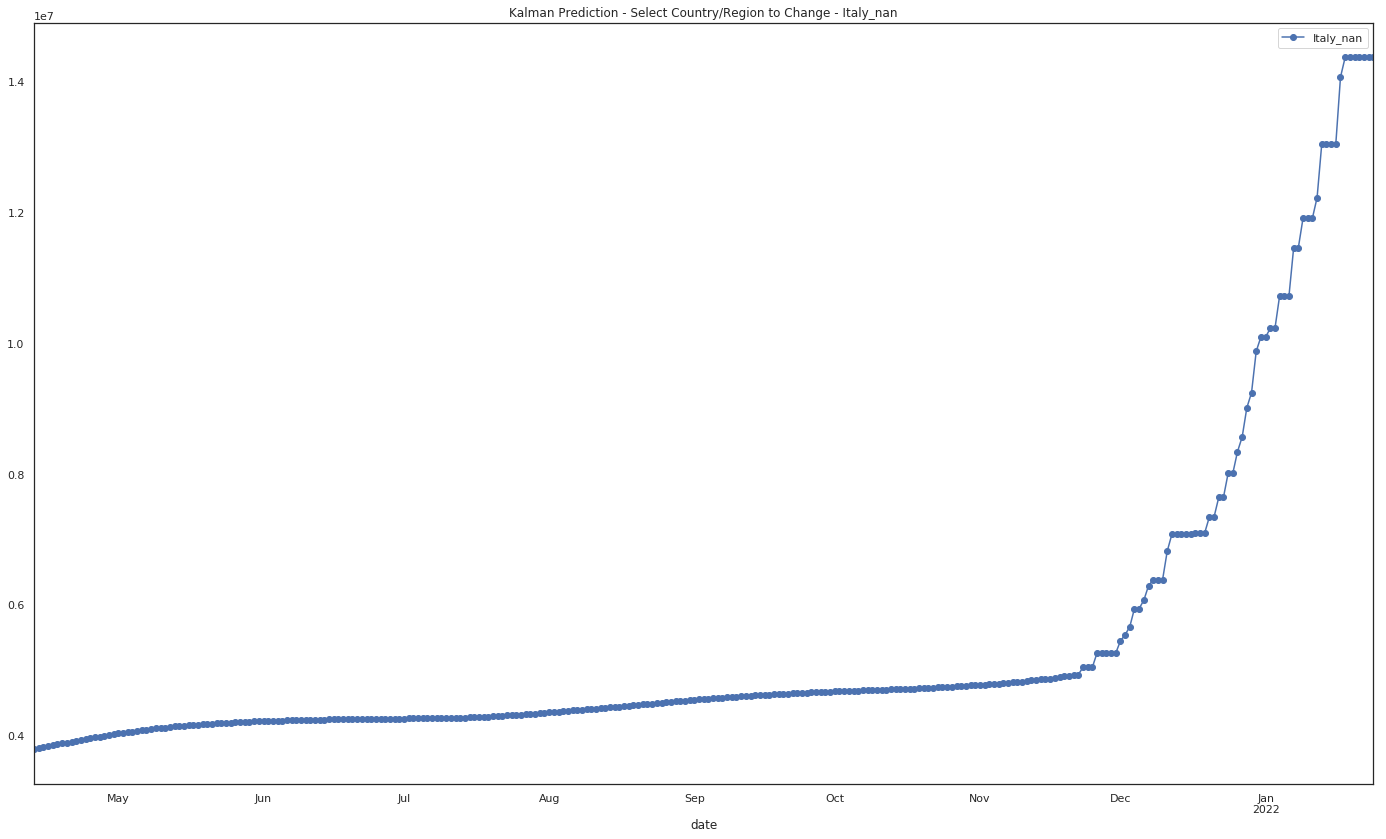

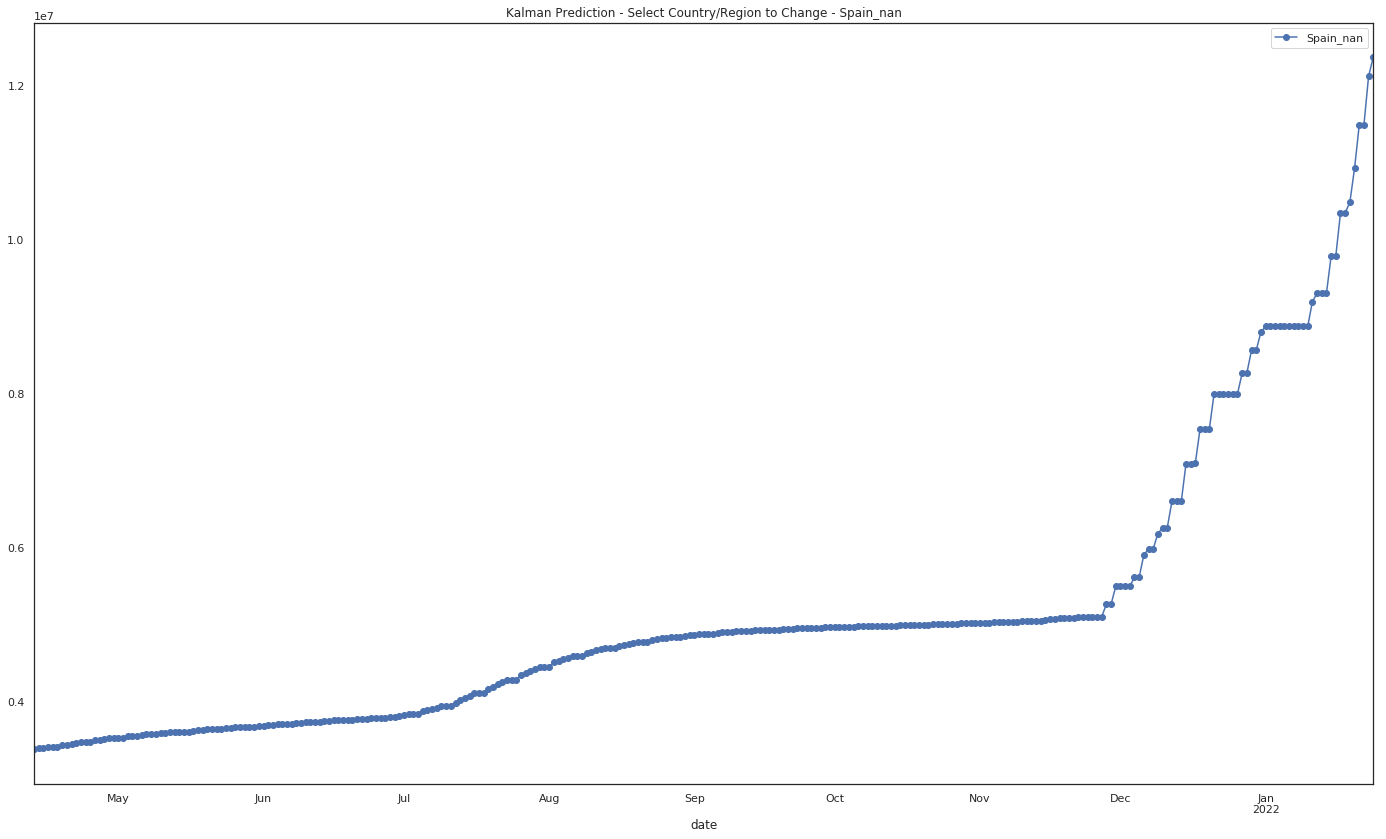

In [66]:
#
### Joao - Moving Forward ...
# Select regions From my_train_list
#
region=['date']+my_train_list
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman=p_kalman.reindex(p_kalman.max().sort_values(ascending=False).index, axis=1)
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')
#
p_kalman2=all_new[['date','United States_nan']] ## Joao
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman2.columns[0]))
#
p_kalman3=all_new[['date','Italy_nan']] ## Joao
p_kalman3=p_kalman3.set_index(['date'])
p_kalman3.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman3.columns[0]))
#
p_kalman4=all_new[['date','Spain_nan']] ## Joao
p_kalman4=p_kalman4.set_index(['date'])
p_kalman4.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman4.columns[0]))
#

/home/notebookuser/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


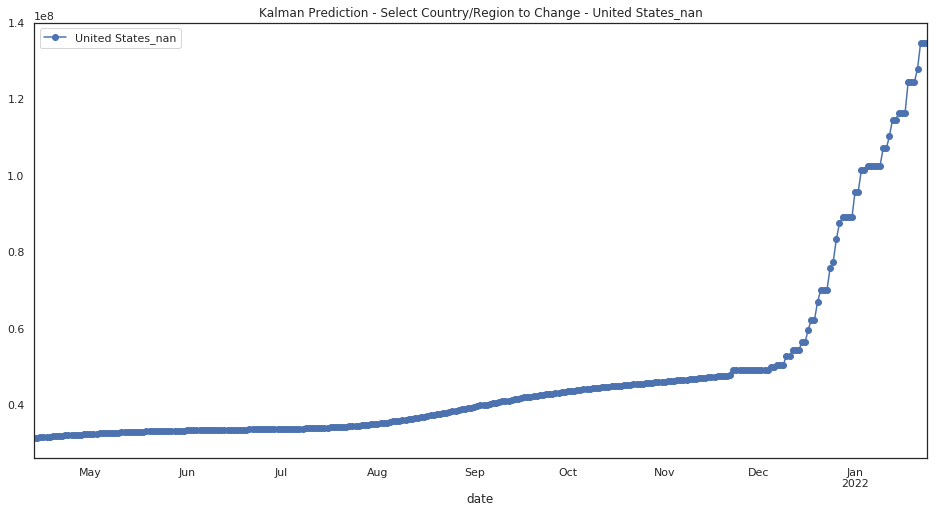

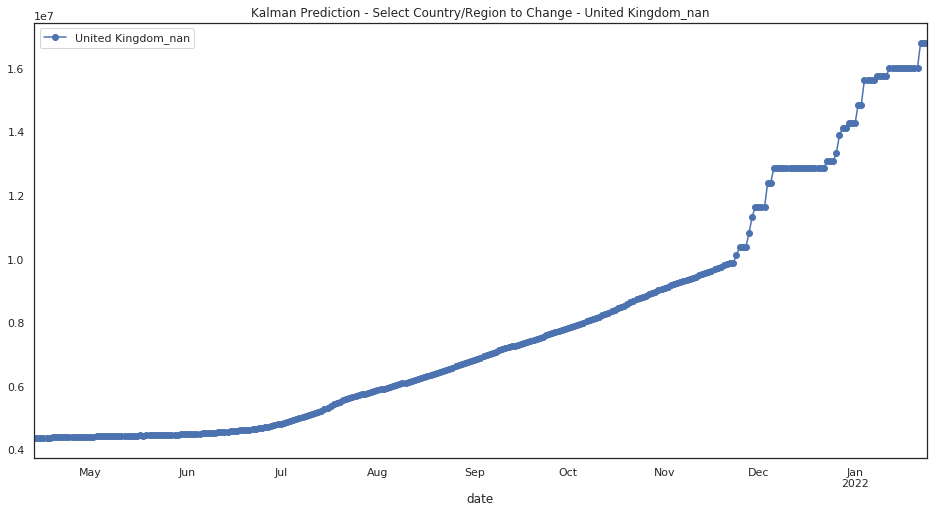

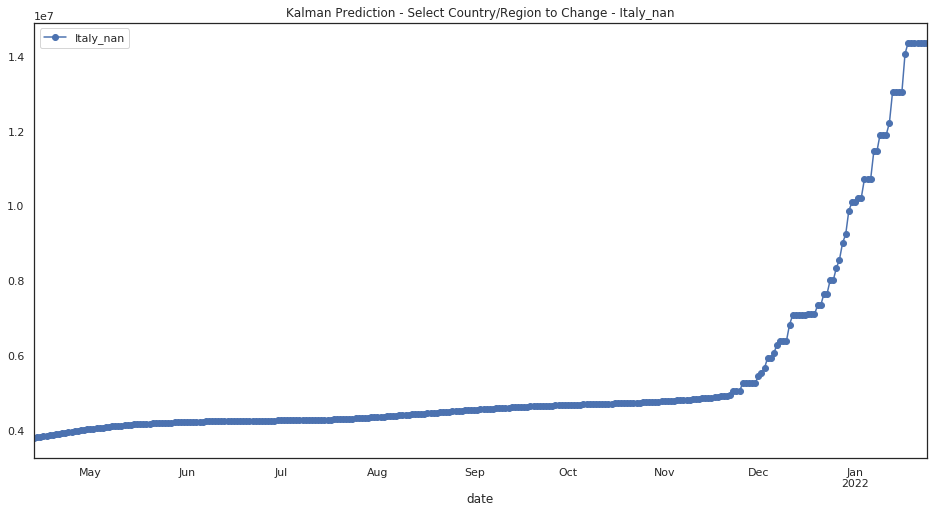

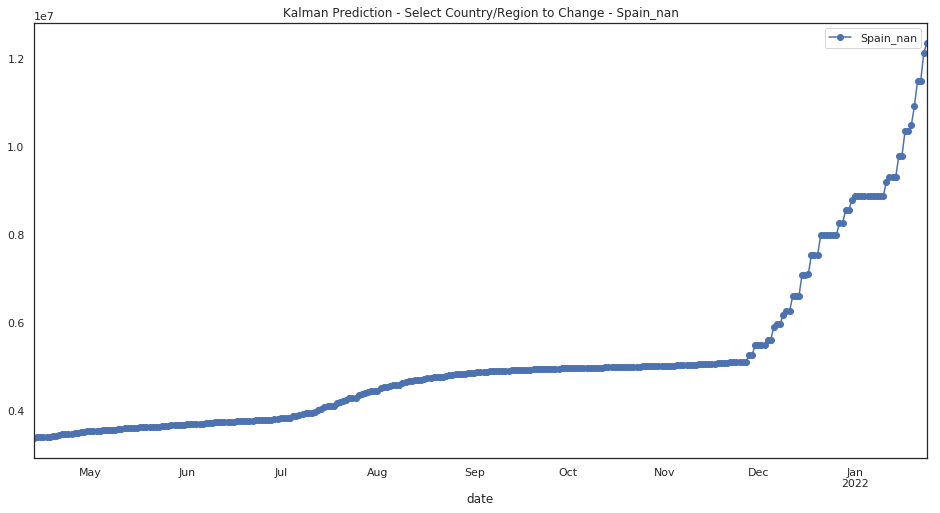

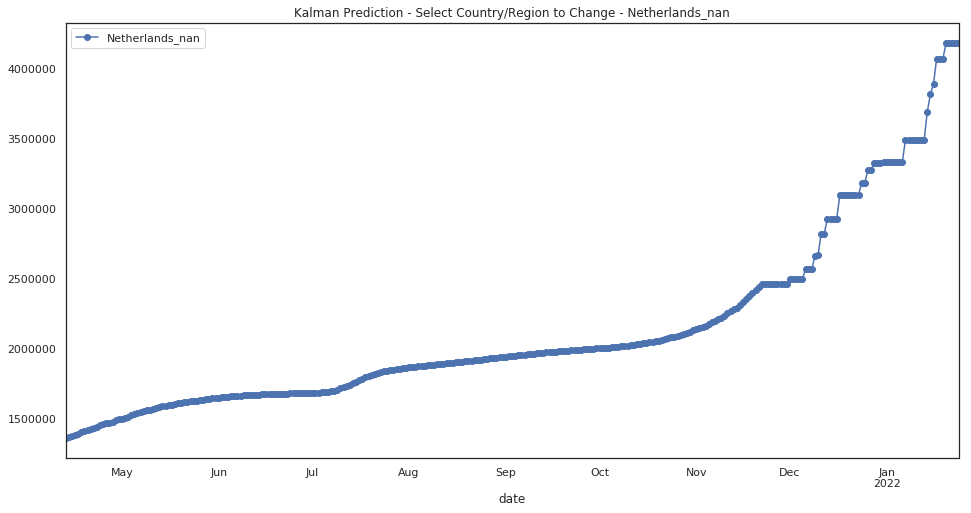

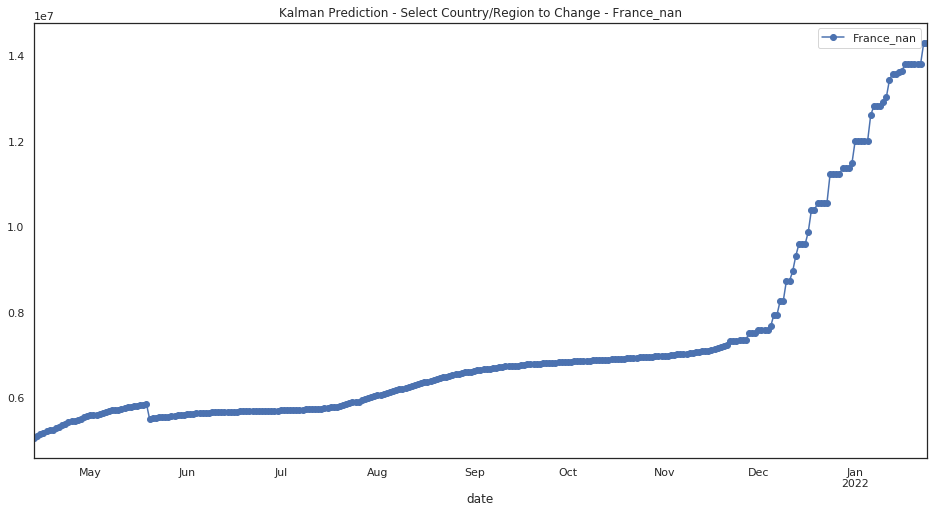

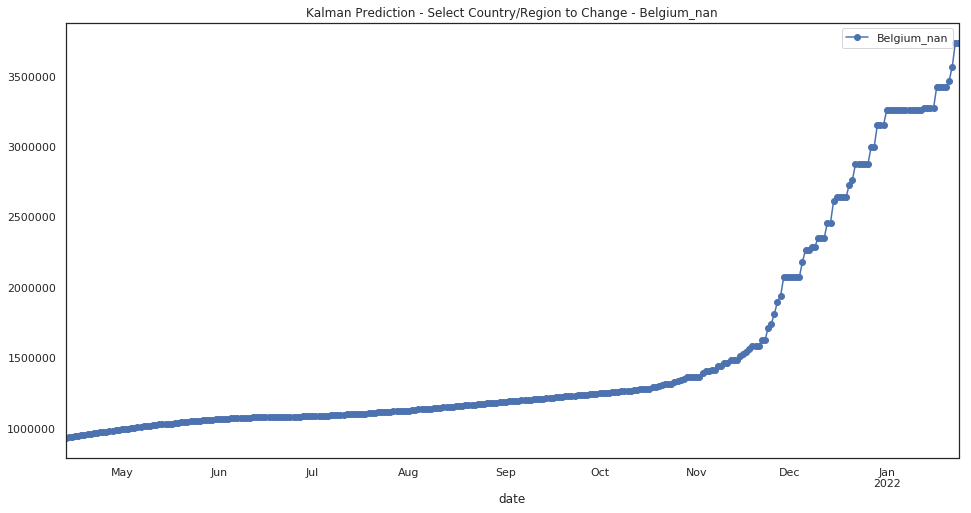

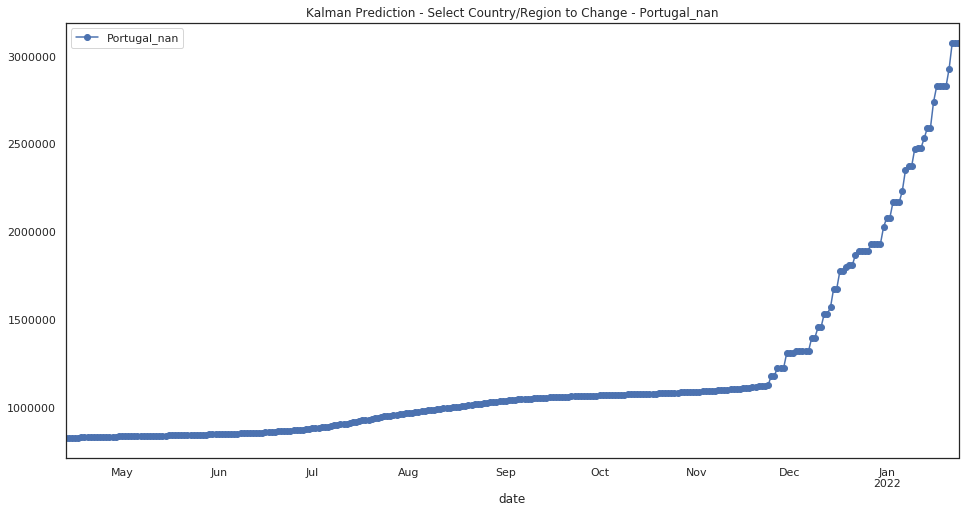

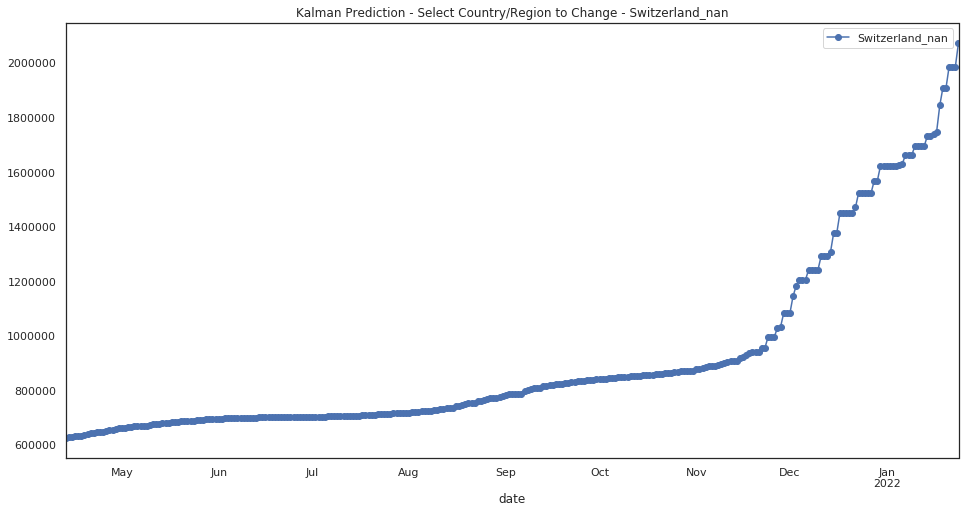

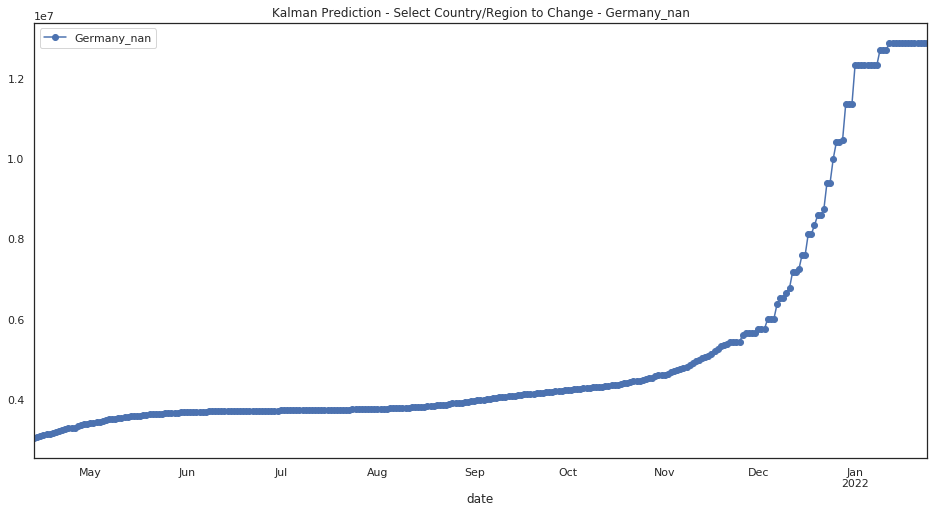

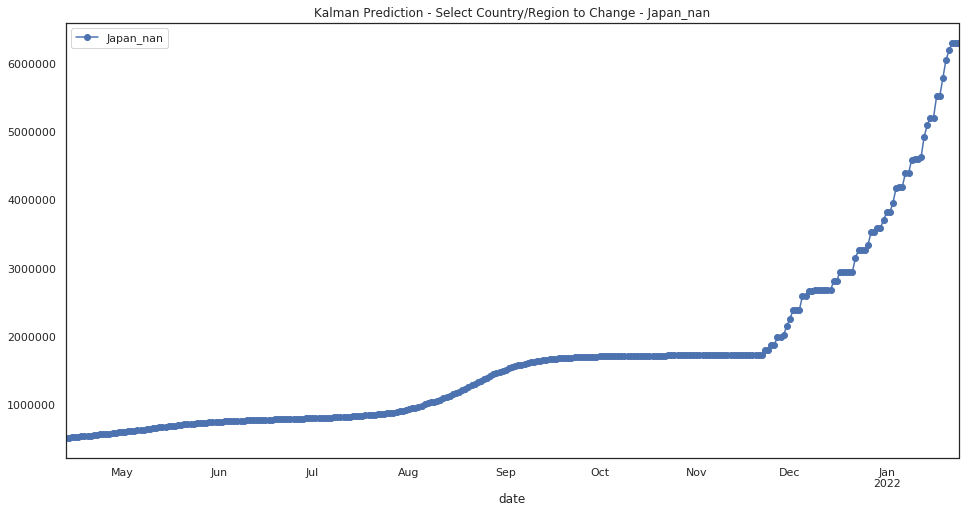

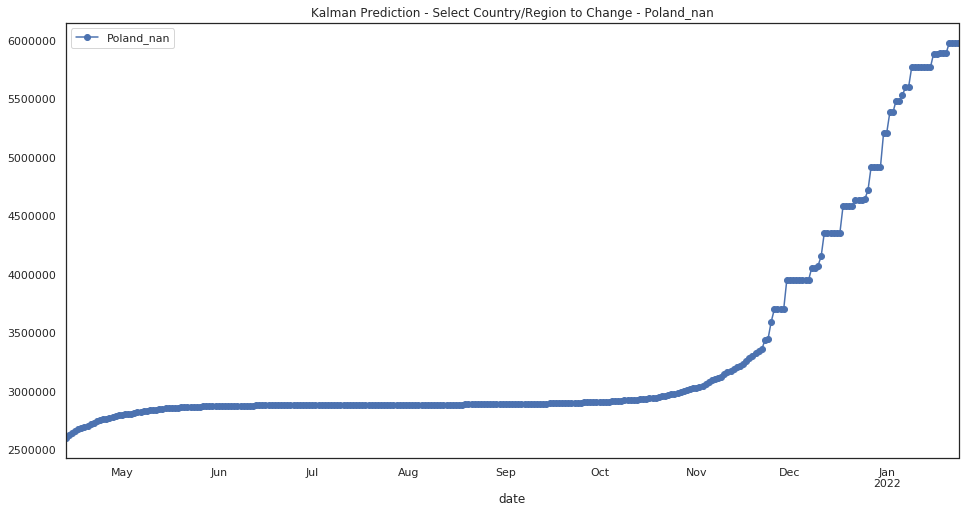

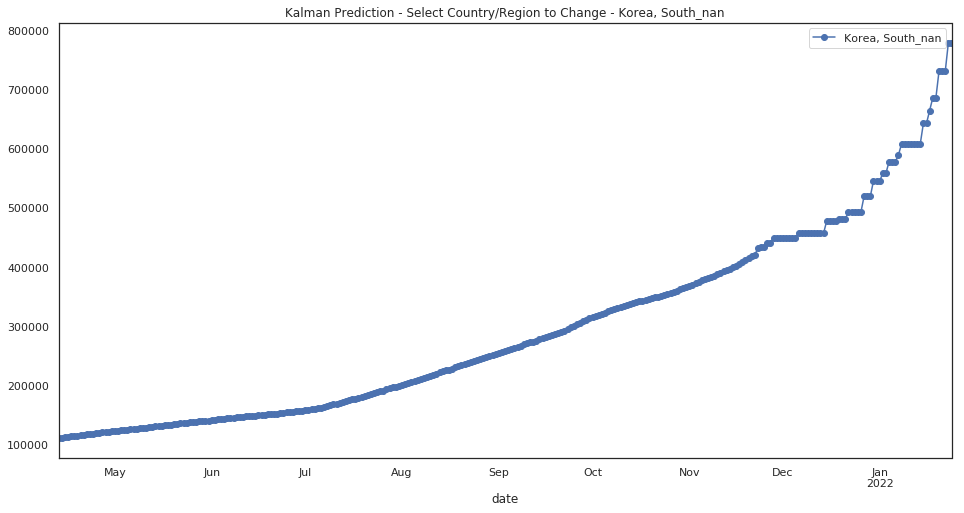

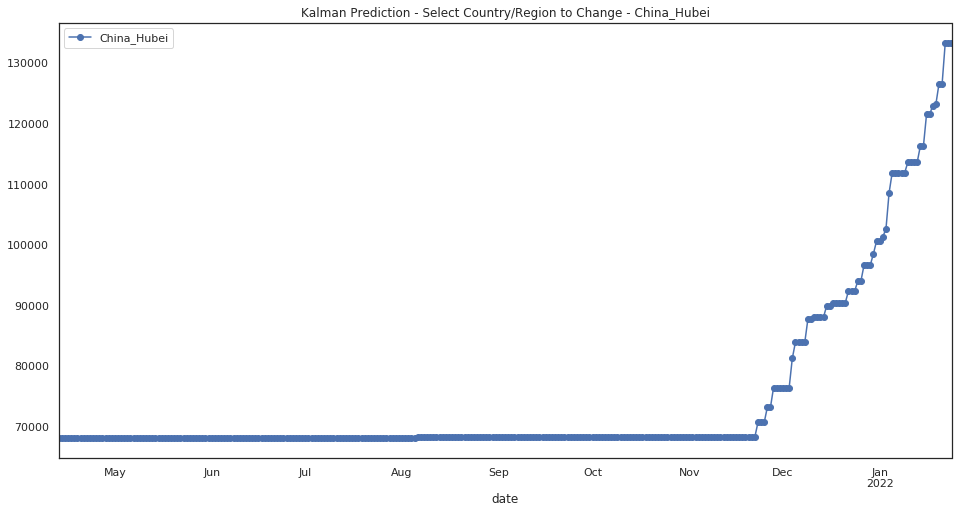

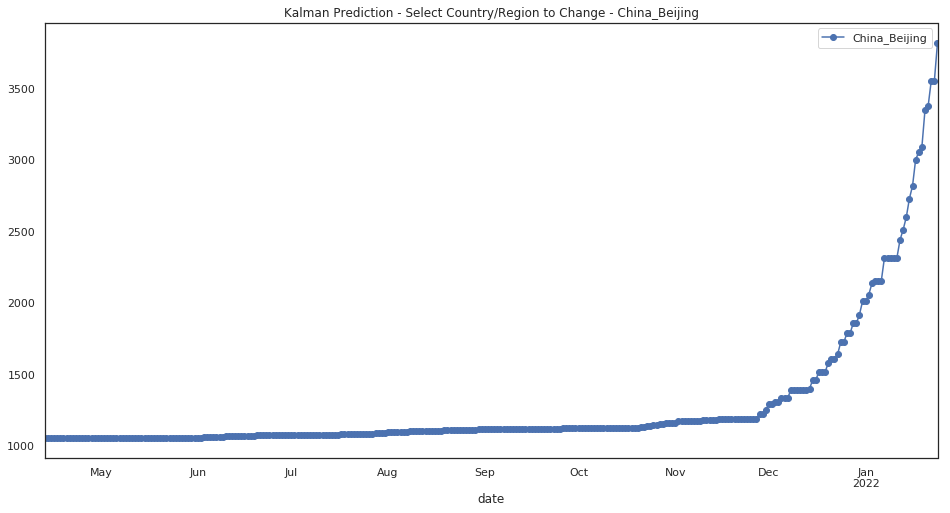

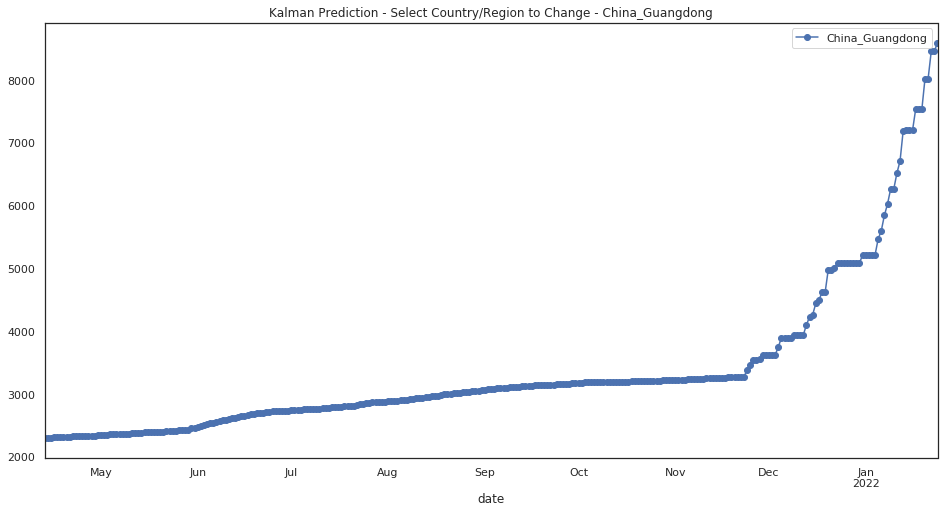

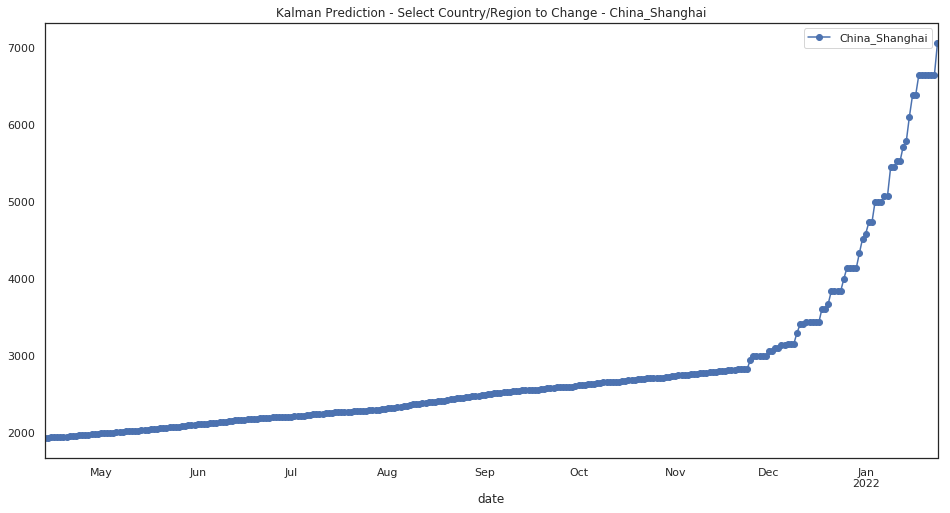

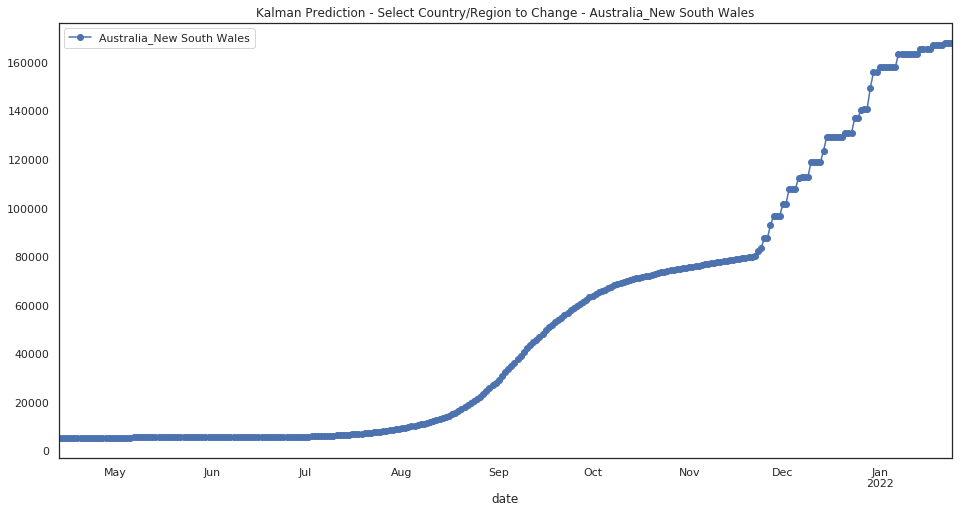

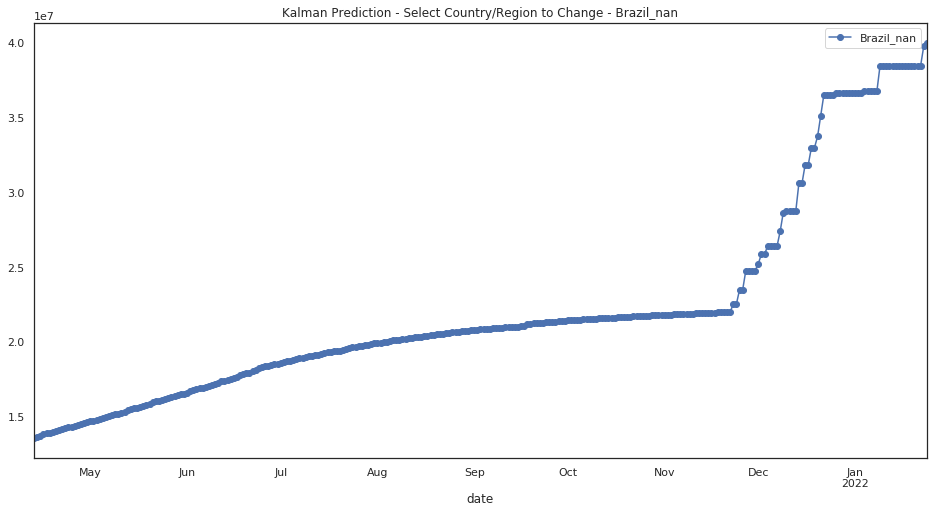

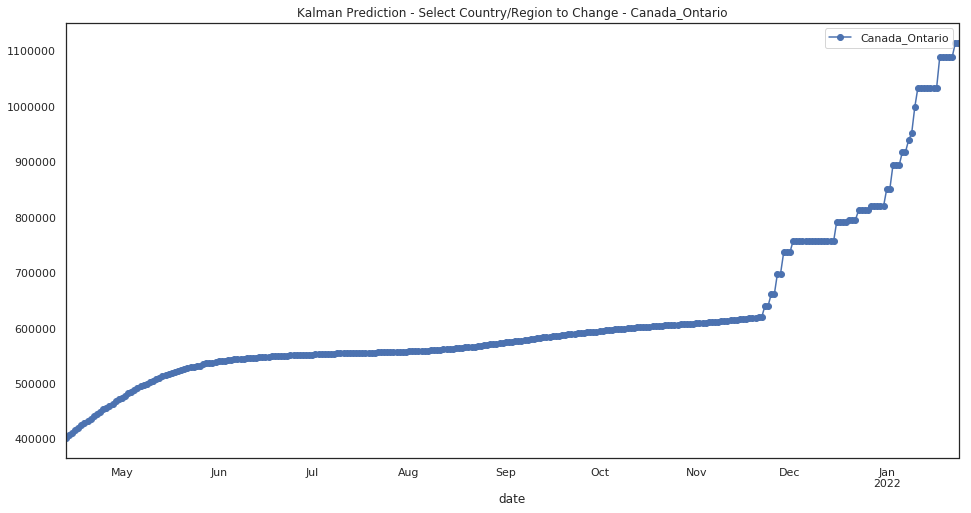

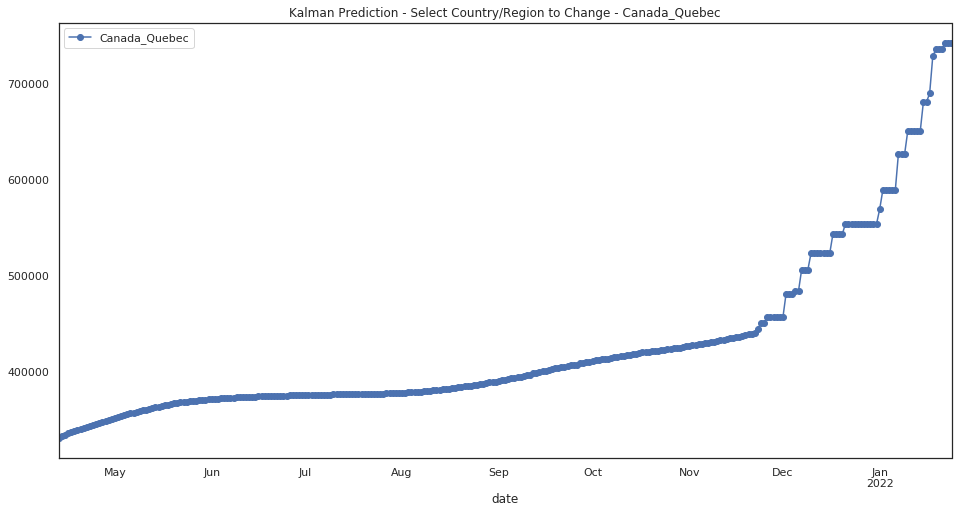

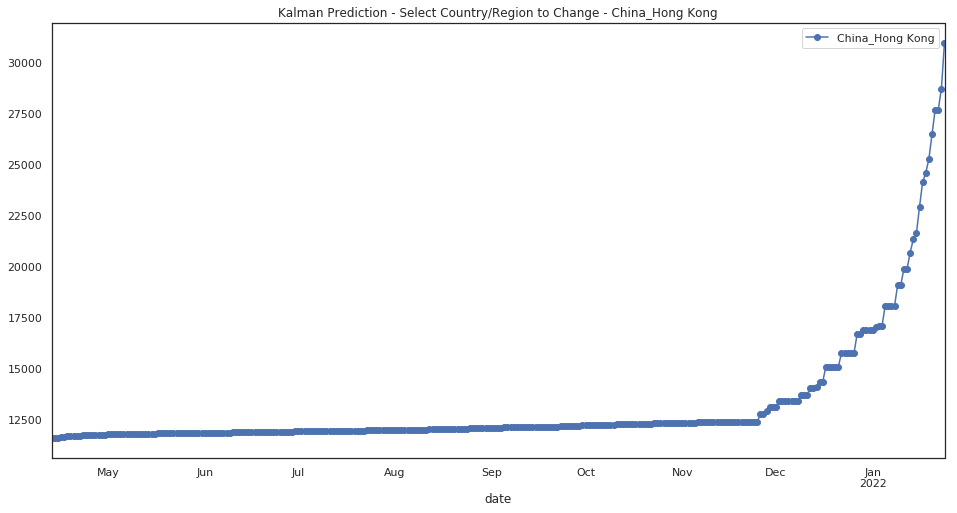

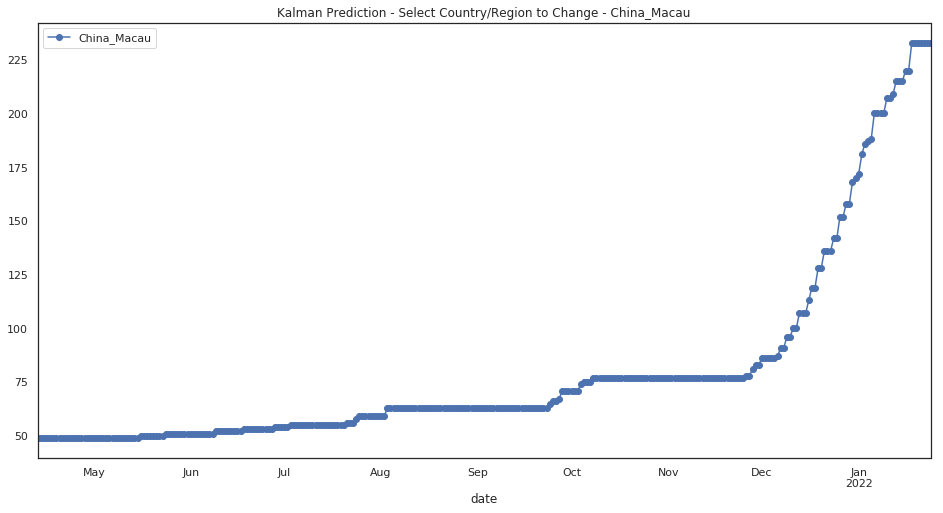

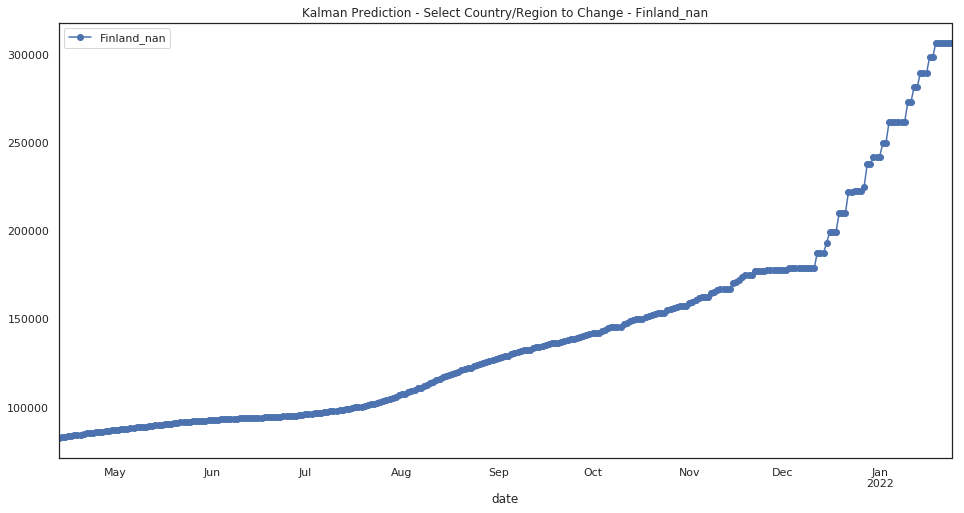

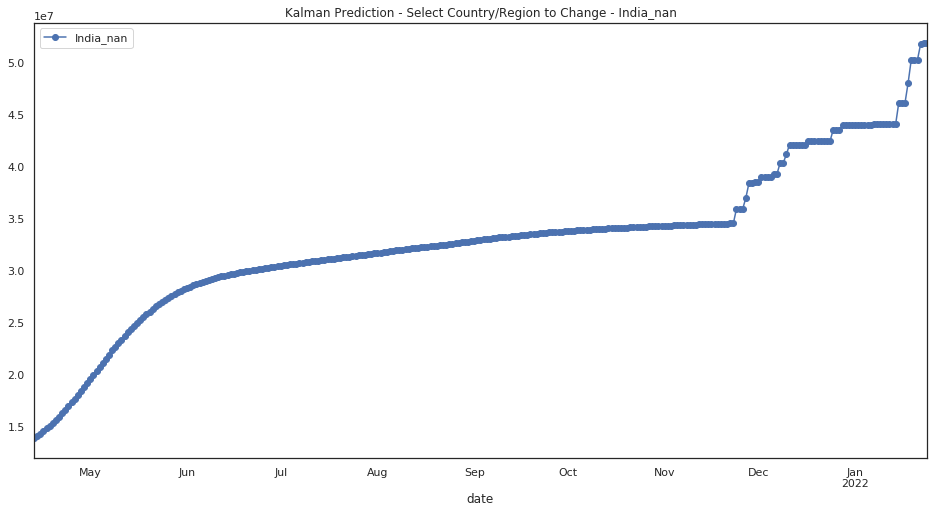

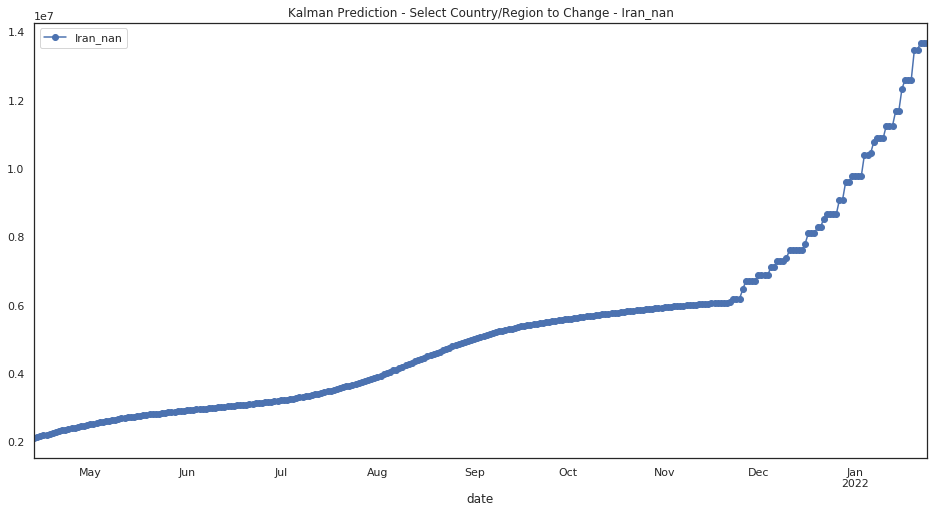

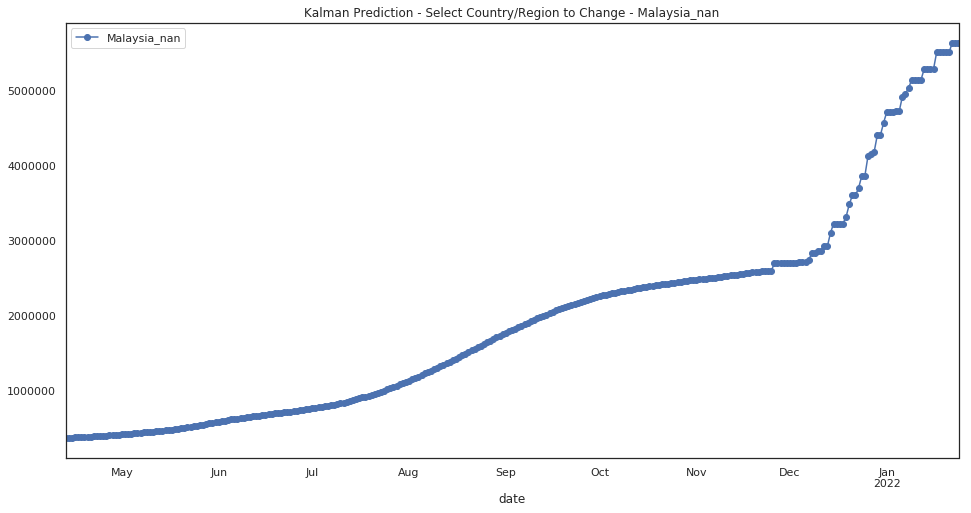

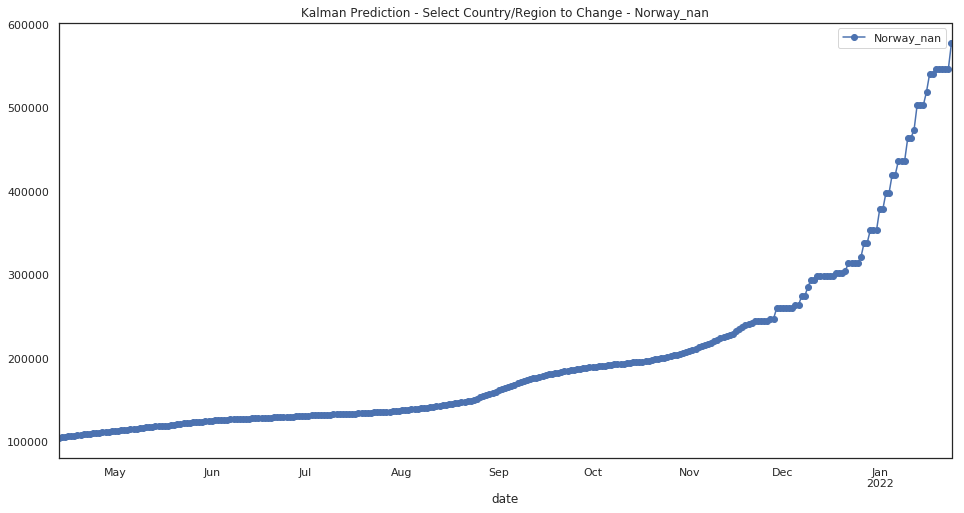

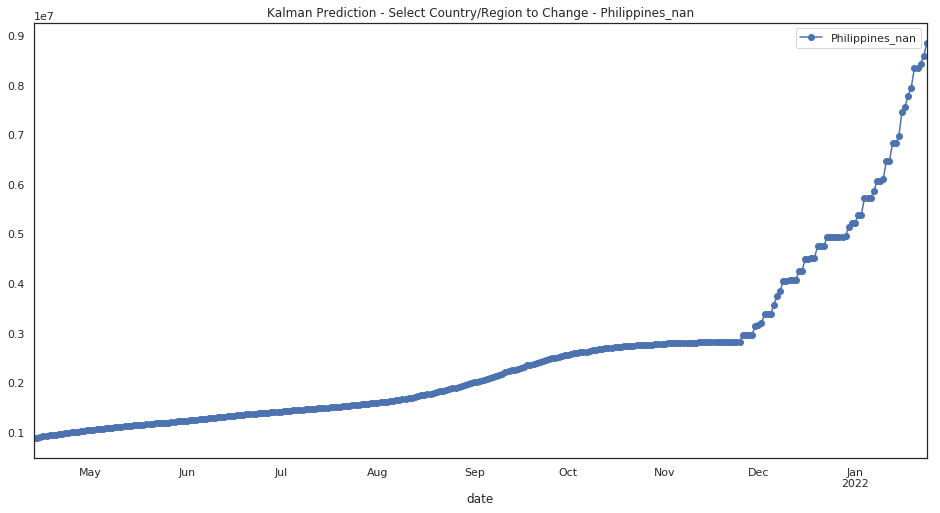

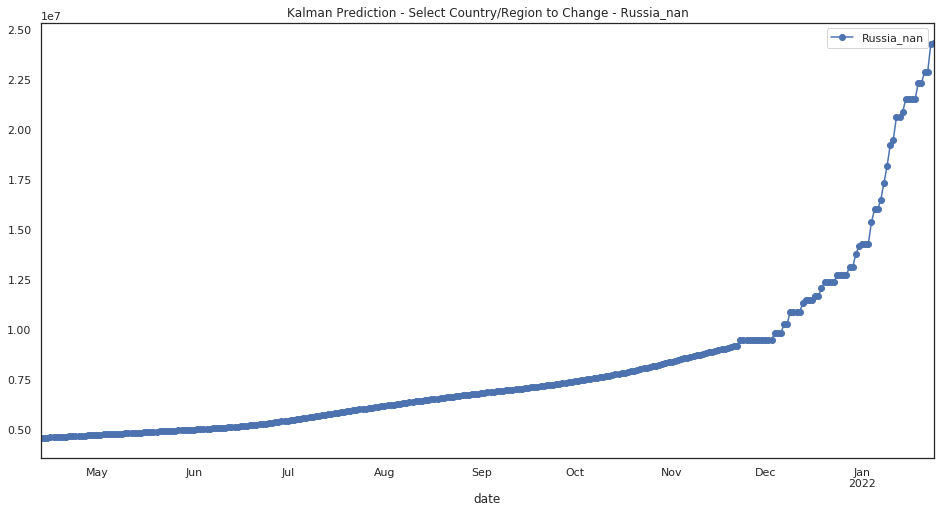

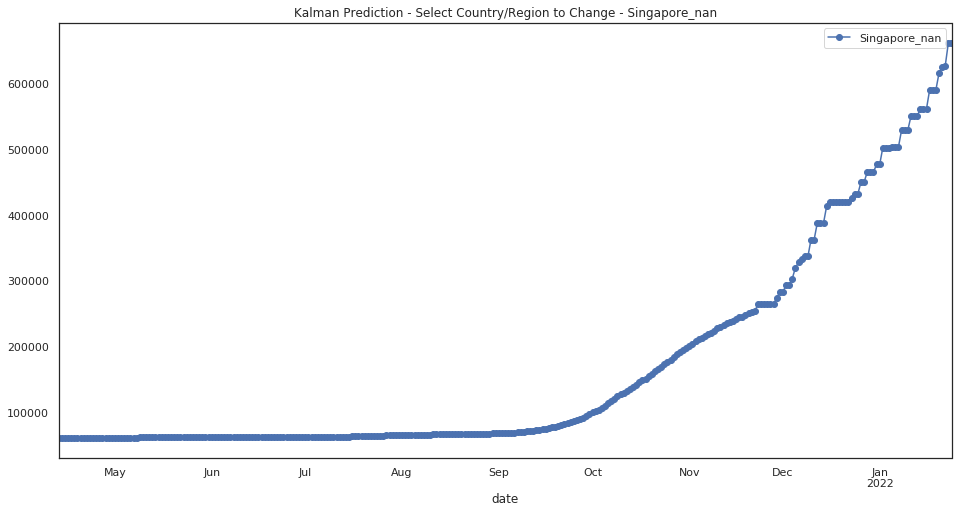

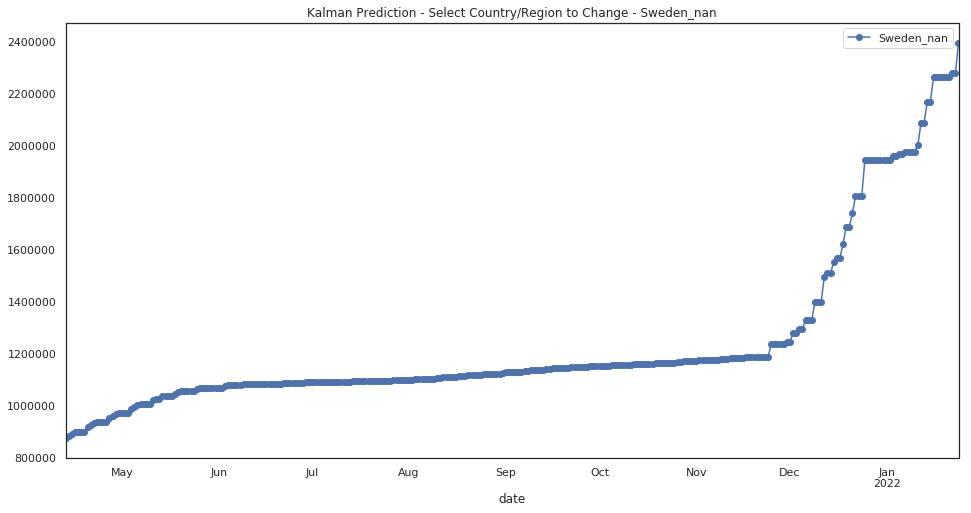

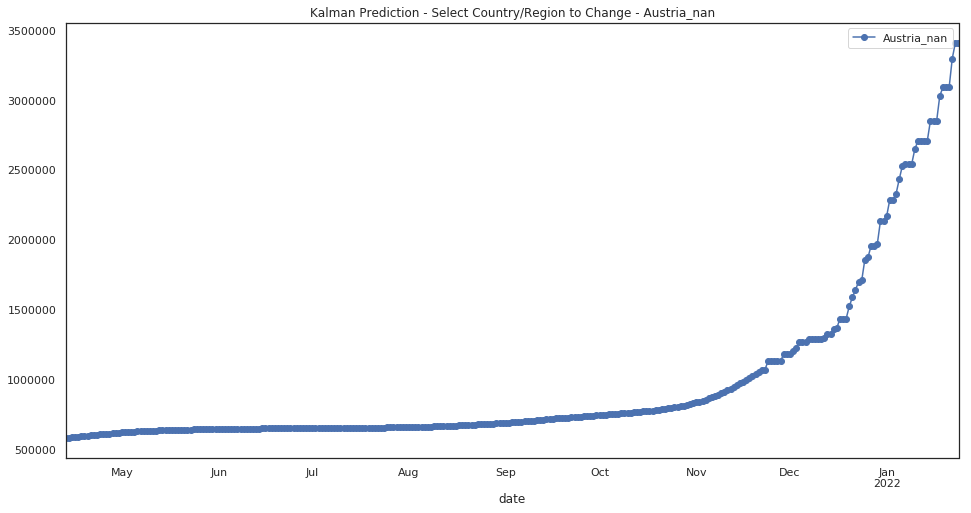

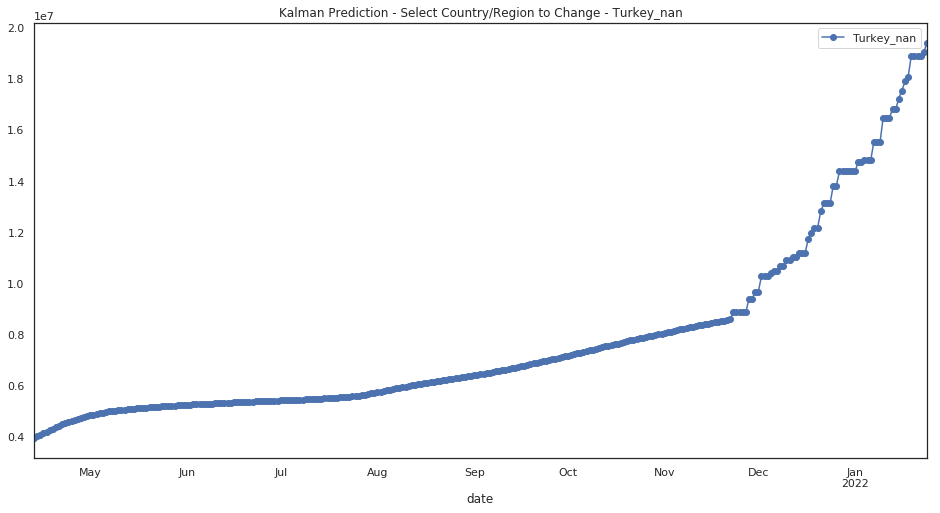

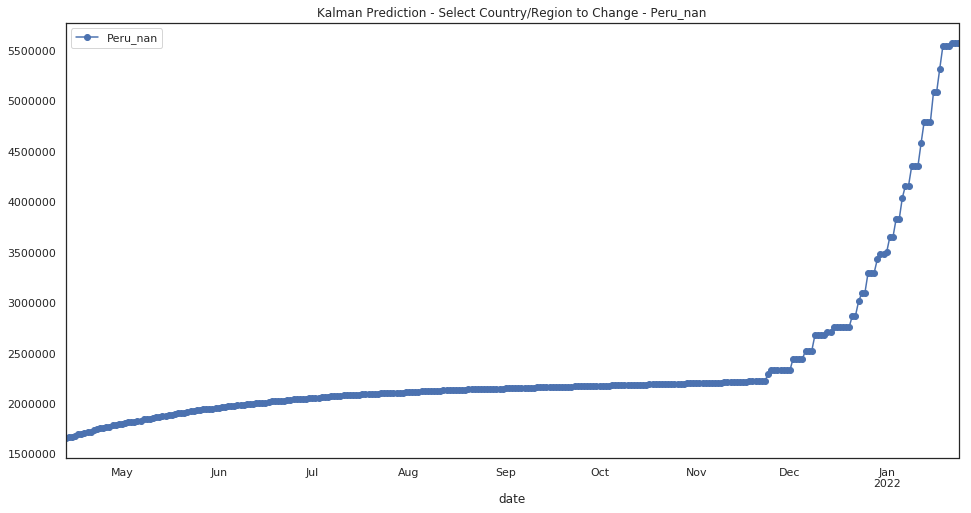

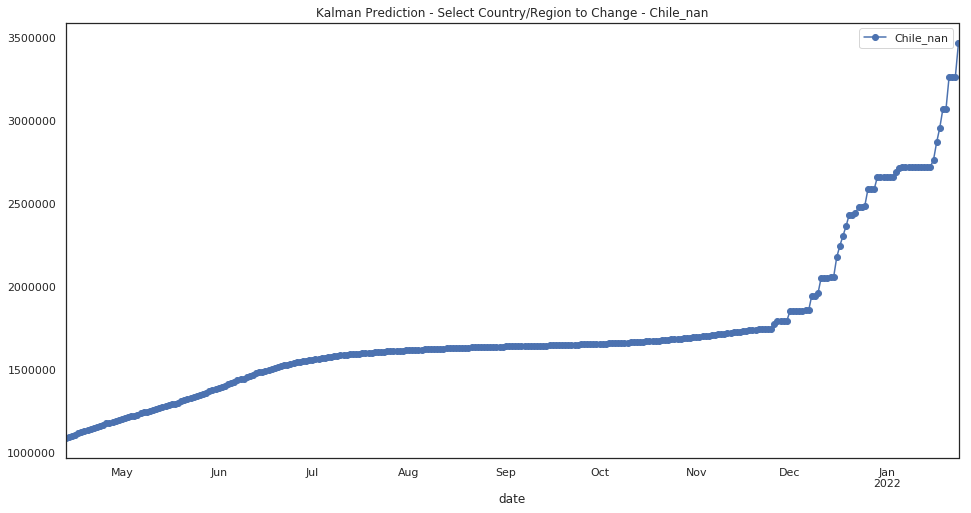

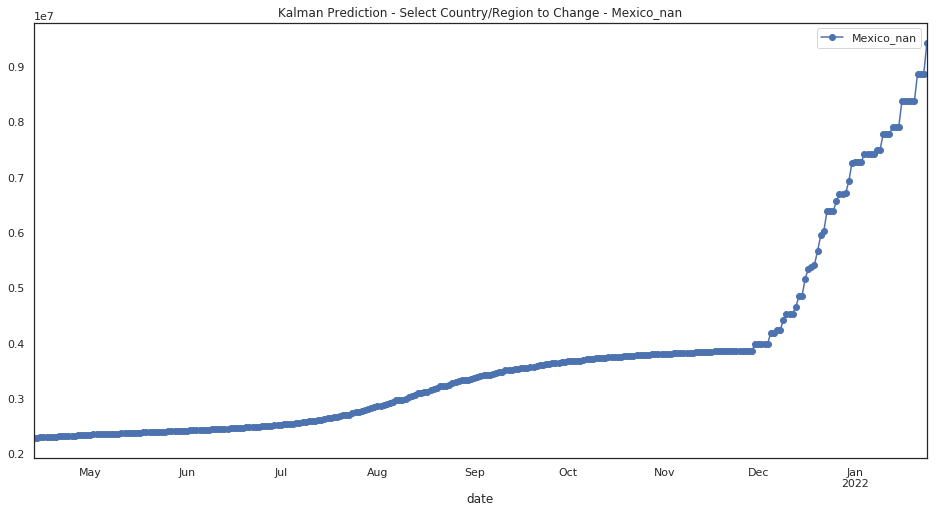

In [67]:
### Joao - Dynamic plot all regions individually
#print(region[:])
for i in range(1,len(region)):
    country_print=region[i]
    #print("here:"+country_print)
    p_kalman_rg=all_new[['date',country_print]]
    p_kalman_rg=p_kalman_rg.set_index(['date'])
    p_kalman_rg.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman_rg.columns[0]))
    

In [68]:
max_p0=all_new[:]
max_p0=max_p0.max()
max_date=max_p0[:1]
max_p0=max_p0[1:]
max_p0=pd.DataFrame(max_p0)
max_p0=max_p0.astype(str)
max_p0['pred_confirmed']=max_p0[max_p0.columns[0]].str.split(' ').str[-1].astype(float)
max_p0[max_p0.columns[0]]=max_p0[max_p0.columns[0]][:-len(max_p0['pred_confirmed'])]
max_p0=max_p0.sort_values(by='pred_confirmed', ascending=False)
#
print("### -- Confirmed max cases per country at last prediction date -- ###")
print(max_date)
max_p0[:]

### -- Confirmed max cases per country at last prediction date -- ###
date    2022-01-24 00:00:00
dtype: object


0  pred_confirmed
United States_nan                                   NaN     134712698.0
India_nan                                           NaN      51936798.0
Brazil_nan                                          NaN      40007089.0
Russia_nan                                          NaN      24345179.0
Turkey_nan                                          NaN      19420918.0
United Kingdom_nan                                  NaN      16812775.0
Italy_nan                                           NaN      14376563.0
France_nan                                          NaN      14307819.0
Iran_nan                                            NaN      13683021.0
Germany_nan                                         NaN      12887569.0
Spain_nan                                           NaN      12365124.0
Colombia_nan                                        NaN       9583753.0
Mexico_nan                                          NaN       9437832.0
Philippines_nan                                     NaN       8866109.0
Iraq_nan                                            NaN       8454675.0
Indonesia_nan                                       NaN       7854232.0
Argentina_nan                                       NaN       7734485.0
Ukraine_nan                                         NaN       6625198.0
Japan_nan                                           NaN       6304739.0
Poland_nan                                          NaN       5982698.0
Malaysia_nan                                        NaN       5644108.0
Peru_nan                                            NaN       5579581.0
South Africa_nan                                    NaN       5237560.0
Czechia_nan                                         NaN       4390480.0
Netherlands_nan                                     NaN       4188187.0
Thailand_nan                                        NaN       4023953.0
Belgium_nan                                         NaN       3738320.0
Chile_nan                                           NaN       3467561.0
Austria_nan                                         NaN       3412028.0
Romania_nan                                         NaN       3133937.0
...                                                 ...             ...
Canada_Prince Edward Island                         NaN           753.0
China_Guangxi                                       NaN           744.0
Australia_Northern Territory                        NaN           716.0
China_Gansu                                         NaN           579.0
China_Shanxi                                        NaN           500.0
China_Guizhou                                       NaN           434.0
China_Hainan                                        NaN           323.0
China_Ningxia                                       NaN           303.0
China_Macau                                         NaN           233.0
United Kingdom_Falkland Islands (Malvinas)          NaN           164.0
France_Saint Pierre and Miquelon                    NaN           120.0
China_Qinghai                                       NaN            68.0
United Kingdom_Montserrat                           NaN            63.0
Holy See_nan                                        NaN            53.0
Solomon Islands_nan                                 NaN            47.0
China_Unknown                                       NaN            37.0
Canada_Repatriated Travellers                       NaN            31.0
Canada_Grand Princess                               NaN            30.0
MS Zaandam_nan                                      NaN             9.0
Palau_nan                                           NaN             8.0
Vanuatu_nan                                         NaN             6.0
United Kingdom_Saint Helena, Ascension and Tris...  NaN             4.0
Marshall Islands_nan                                NaN             4.0
Samoa_nan                                           NaN             3.0
Kiribati_nan          

In [69]:
t.to_csv(r'data/t_confirmed_global.csv', index = False, header=True)

In [70]:
all_new.to_csv(r'data/prediction_kalman_filter_global.csv', index = False, header=True)

## Iterative Regression

In [71]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
    if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
        t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

### Joao - Fix - RuntimeWarning: divide by zero encountered in double_scalars
#
t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
    if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
        t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
        t_iter.iloc[i,6]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-2,2]*100 -1 +1))*100
        t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
    if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
        t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
        t_iter.iloc[i,7]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-4,2]*100 -1 +1))*100
    if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
        t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
        t_iter.iloc[i,8]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-8,2]*100 -1 +1))*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])

test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(10000000) # Fill 10M population if null
test_iter['population']=test_iter['population'].astype('int32')
## Joao - Fix Divid By Zero
#test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
#test_iter['infected_rate'] =((test_iter['last_day']+1)*10000)/((test_iter['population']+1)*100)*100
test_iter['infected_rate']=(((test_iter['last_day'] +1)*100)/((test_iter['population'] +1)*100000) *10)
#
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])

test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
    if(np.isnan(test_iter.iloc[i,13])):
        if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
            test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
            test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [72]:
test_iter=test_iter.fillna(0) 
test_iter[test_iter.isnull().any(axis=1)]


Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [73]:
### JOAO - ERROR - ValueError: Index contains duplicate entries, cannot reshape
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values

for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
        if(pred.iloc[i,0]<pred.iloc[i-1,1]):
            pred.iloc[i,0]=pred.iloc[i-1,1]
### JOAO - Drop Duplicates
pred=pred.drop_duplicates(subset=['date','region'], keep='last', inplace=False)        
### Joao - Save long term predictions
pred.to_csv('data/pred_'+str(num_days_R_prediction)+'_days.csv', index = False, header=True)
###
pred=pred.pivot(index='date',columns='region',values='prediction') # pivot pred df

In [74]:
pred[:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2021-04-13         121813.0     183213.0     174653.0      83323.0   
2021-04-14         121923.0     183391.0     174804.0      83346.0   
2021-04-15          57492.0     128959.0     118975.0      12641.0   
2021-04-16          57534.0     129128.0     119142.0      12641.0   
2021-04-17          57698.0     129307.0     119427.0      12712.0   
2021-04-18          57737.0     129456.0     119594.0      12771.0   
2021-04-19          57884.0     129594.0     119759.0      12805.0   
2021-04-20          57980.0     129694.0     119939.0      12805.0   
2021-04-21          59154.0     130624.0     121153.0      12874.0   
2021-04-22          59225.0     130762.0     121344.0      12917.0   
2021-04-23          59533.0     130917.0     121539.0      12942.0   
2021-04-24          59578.0     131047.0     121712.0      13007.0   
2021-04-25          59755.0     131184.0     121909.0      13024.0   
2021-04-26          60010.0     131266.0     122093.0      13060.0   
2021-04-27          60144.0     131412.0     122317.0      13083.0   
2021-04-28          60256.0     131507.0     122533.0      13121.0   
2021-04-29          60532.0     131628.0     122813.0      13148.0   
2021-04-30          60639.0     131740.0     123039.0      13198.0   
2021-05-01          60870.0     131845.0     123271.0      13232.0   
2021-05-02          61029.0     131907.0     123501.0      13232.0   
2021-05-03          61221.0     131966.0     123692.0      13282.0   
2021-05-04          61479.0     132020.0     123969.0      13295.0   
2021-05-05          61625.0     132098.0     124202.0      13316.0   
2021-05-06          62011.0     132170.0     124420.0      13340.0   
2021-05-07          62180.0     132241.0     124672.0      13363.0   
2021-05-08          62567.0     132338.0     124871.0      13390.0   
2021-05-09          62683.0     132389.0     125079.0      13406.0   
2021-05-10          63108.0     132436.0     125268.0      13423.0   
2021-05-11          63278.0     132495.0     125471.0      13429.0   
2021-05-12          63469.0     132528.0     125662.0      13447.0   
...                     ...          ...          ...          ...   
2021-12-27         226542.0     268078.0     247193.0      20915.0   
2021-12-28         226328.0     269420.0     256878.0      21296.0   
2021-12-29         228735.0     273152.0     257442.0      21296.0   
2021-12-30         228554.0     282360.0     263190.0      21296.0   
2021-12-31         228593.0     293404.0     265085.0      21364.0   
2022-01-01         238554.0     296296.0     266251.0      21364.0   
2022-01-02         247047.0     306058.0     269867.0      21364.0   
2022-01-03         249752.0     306683.0     269830.0      22560.0   
2022-01-04         251309.0     307312.0     278899.0      22560.0   
2022-01-05         260144.0     323514.0     285292.0      22560.0   
2022-01-06         260210.0     325520.0     286928.0      22560.0   
2022-01-07         271060.0     326199.0     288957.0      22560.0   
2022-01-08         271097.0     338730.0     290635.0      22560.0   
2022-01-09         282176.0     344110.0     290714.0      22560.0   
2022-01-10         282274.0     360690.0     290997.0      23379.0   
2022-01-11         288683.0     363155.0     304462.0      23379.0   
2022-01-12         288702.0     363864.0     305426.0      23379.0   
2022-01-13         289874.0     363617.0     317937.0      23379.0   
2022-01-14         289878.0     369387.0     318425.0      23379.0   
2022-01-15         289791.0     385126.0     319838.0      23379.0   
2022-01-16         292077.0     393782.0     330165.0      23379.0   
2022-01-17         303921.0     405652.0     330458.0      23379.0   
2022-01-18         313918.0     407353.0     331952.0      23379.0   
2022-01-19         316180.0     407721.0     331787.0      23379.0   
2022-01-20

In [75]:
### JOAO - FIX - issue if all source days ts[:]
## Comment for -35days start. 26feb.2020 ts=ts[35:]
## 06Aug2020 - For all
pred=pred[:-1]

In [76]:
region1=max_p0[max_p0.columns[0]].astype(str).reset_index().rename(columns={"index": "region"}).get_values()
region=[region[0] for region in region1]
region

['United States_nan',
 'India_nan',
 'Brazil_nan',
 'Russia_nan',
 'Turkey_nan',
 'United Kingdom_nan',
 'Italy_nan',
 'France_nan',
 'Iran_nan',
 'Germany_nan',
 'Spain_nan',
 'Colombia_nan',
 'Mexico_nan',
 'Philippines_nan',
 'Iraq_nan',
 'Indonesia_nan',
 'Argentina_nan',
 'Ukraine_nan',
 'Japan_nan',
 'Poland_nan',
 'Malaysia_nan',
 'Peru_nan',
 'South Africa_nan',
 'Czechia_nan',
 'Netherlands_nan',
 'Thailand_nan',
 'Belgium_nan',
 'Chile_nan',
 'Austria_nan',
 'Romania_nan',
 'Portugal_nan',
 'Pakistan_nan',
 'Israel_nan',
 'Slovakia_nan',
 'Serbia_nan',
 'Bangladesh_nan',
 'Sweden_nan',
 'Hungary_nan',
 'Vietnam_nan',
 'Georgia_nan',
 'Greece_nan',
 'Switzerland_nan',
 'Kazakhstan_nan',
 'Lebanon_nan',
 'Morocco_nan',
 'Nepal_nan',
 'United Arab Emirates_nan',
 'Croatia_nan',
 'Cuba_nan',
 'Jordan_nan',
 'Ecuador_nan',
 'Guatemala_nan',
 'Bulgaria_nan',
 'Paraguay_nan',
 'Belarus_nan',
 'Moldova_nan',
 'Azerbaijan_nan',
 'Sri Lanka_nan',
 'Burma_nan',
 'Saudi Arabia_nan',
 'Mo

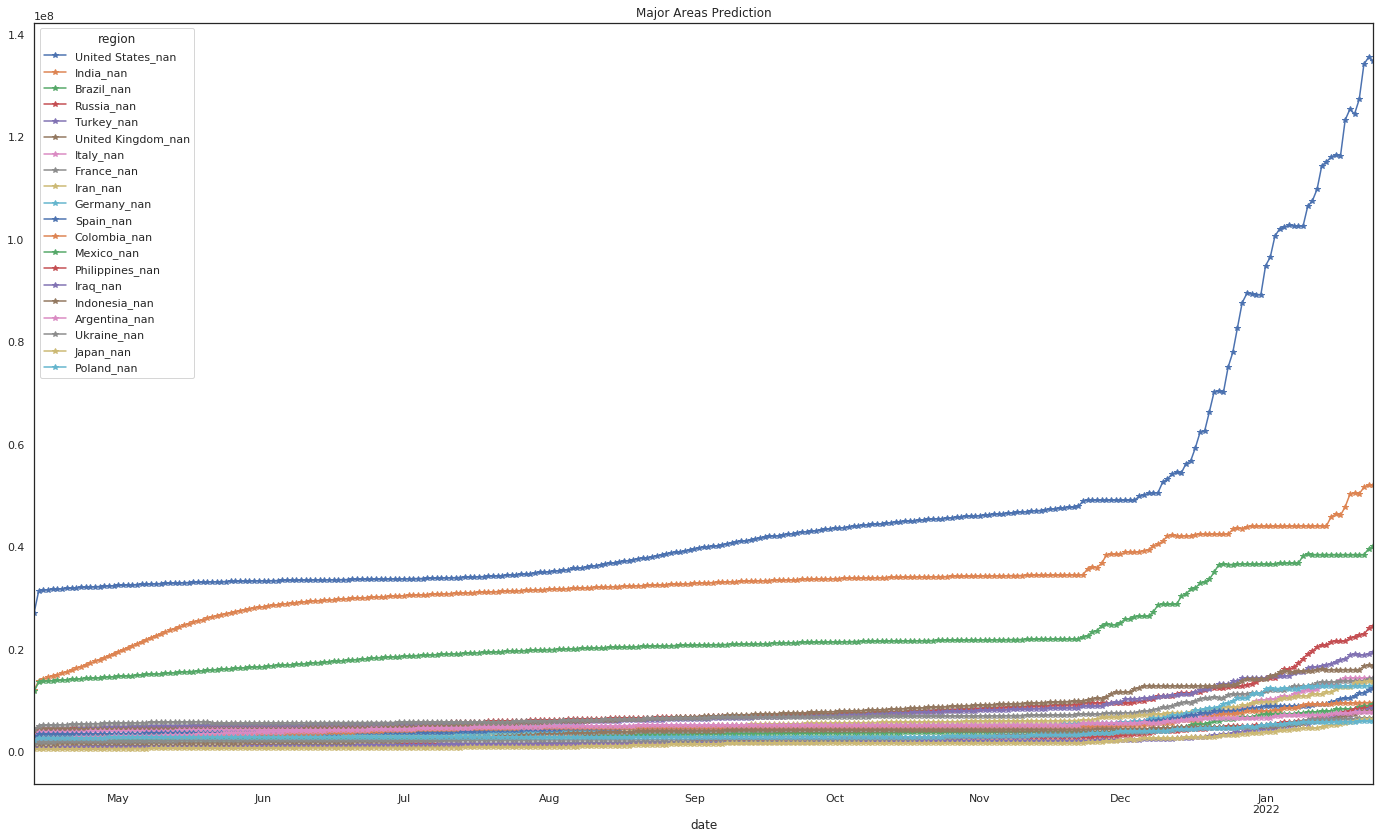

In [77]:
#
p=pred[region[:20]]
p[:].reindex(p.max().sort_values(ascending=False).index, axis=1).plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

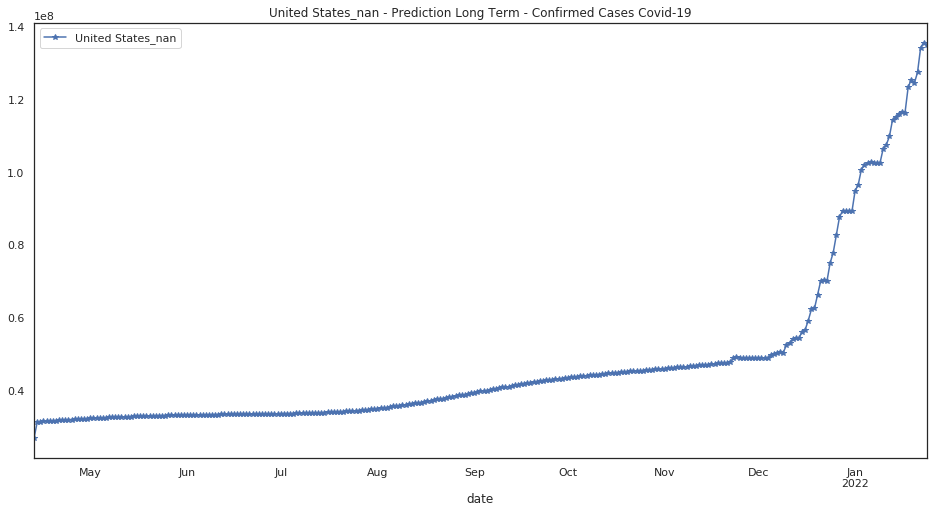

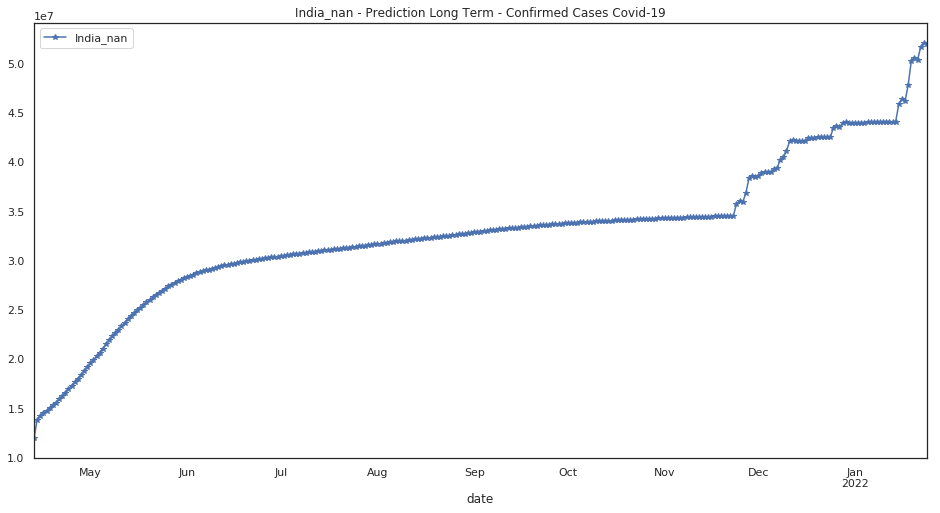

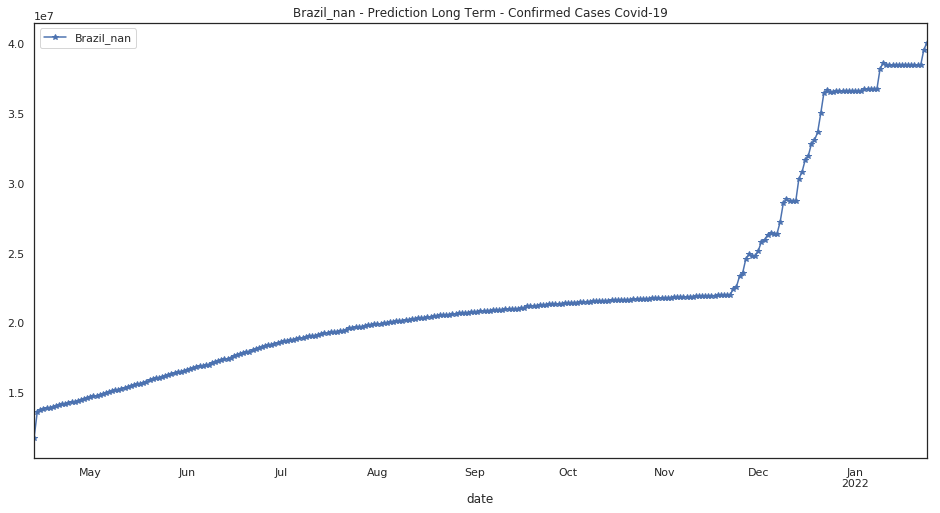

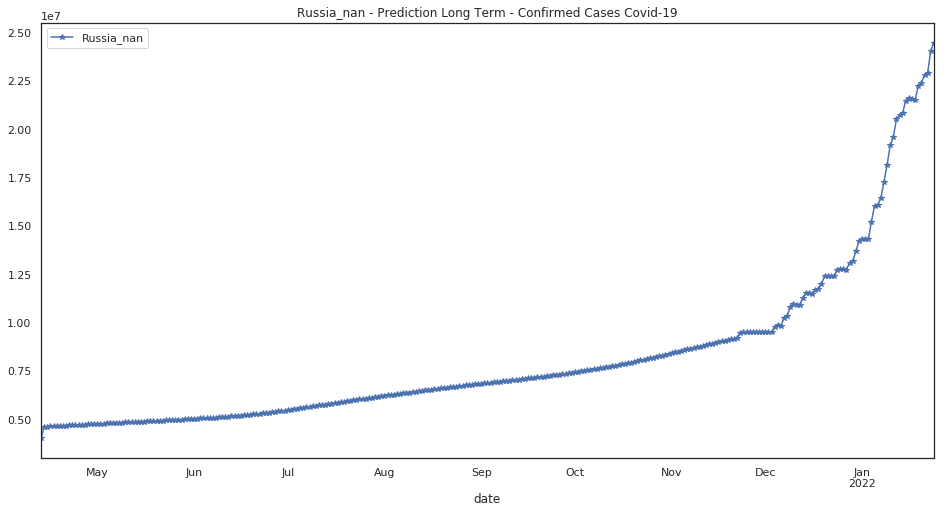

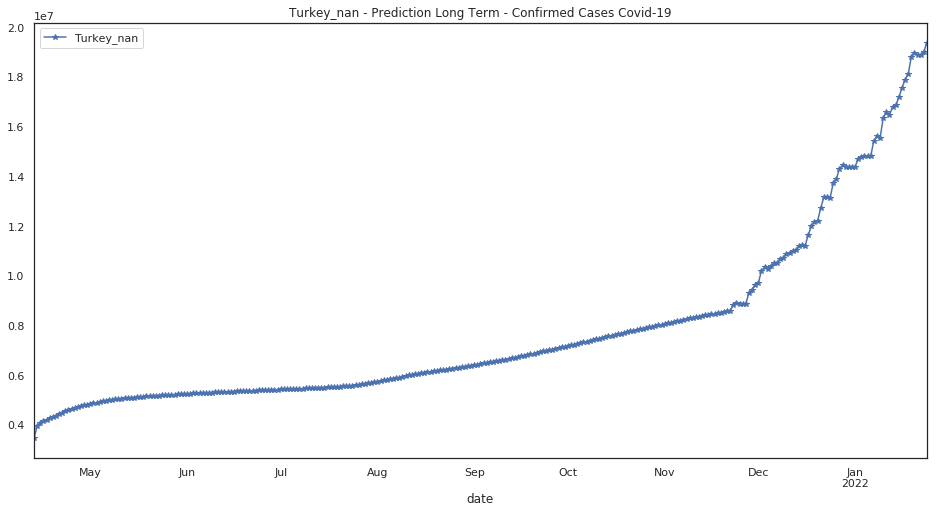

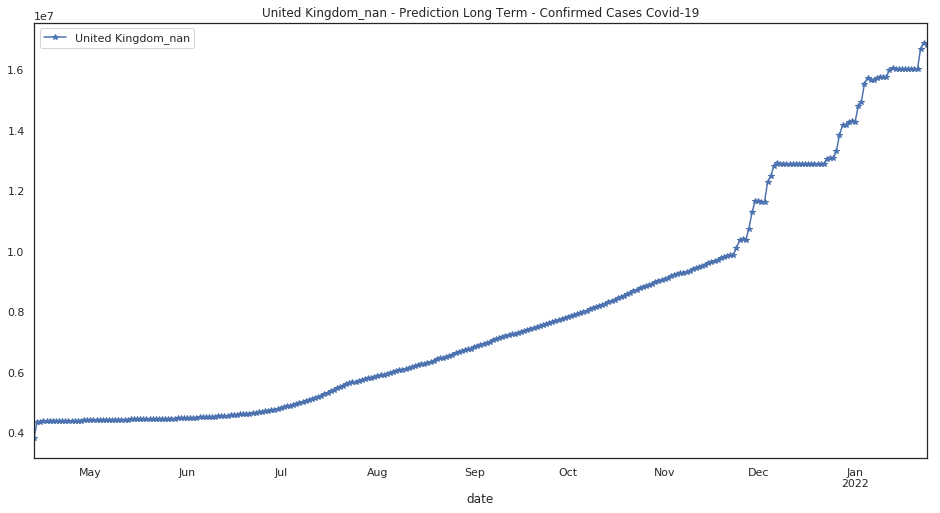

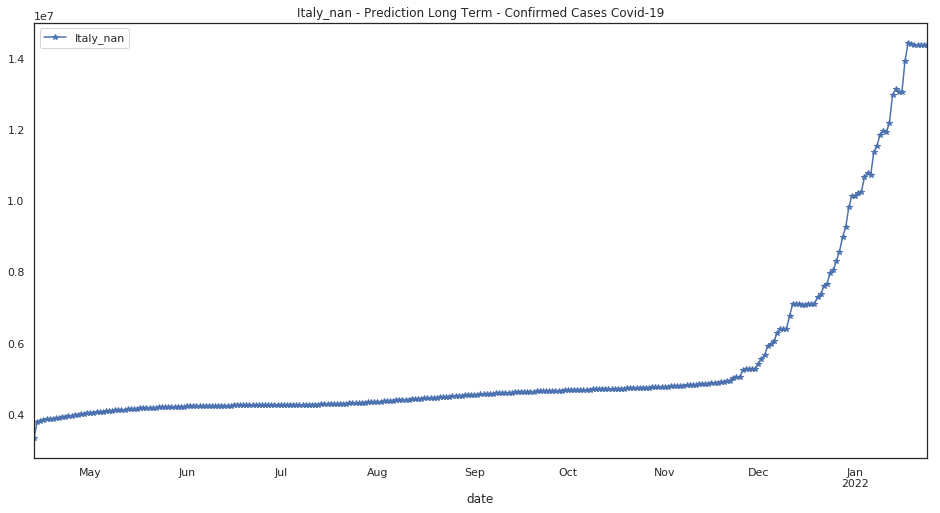

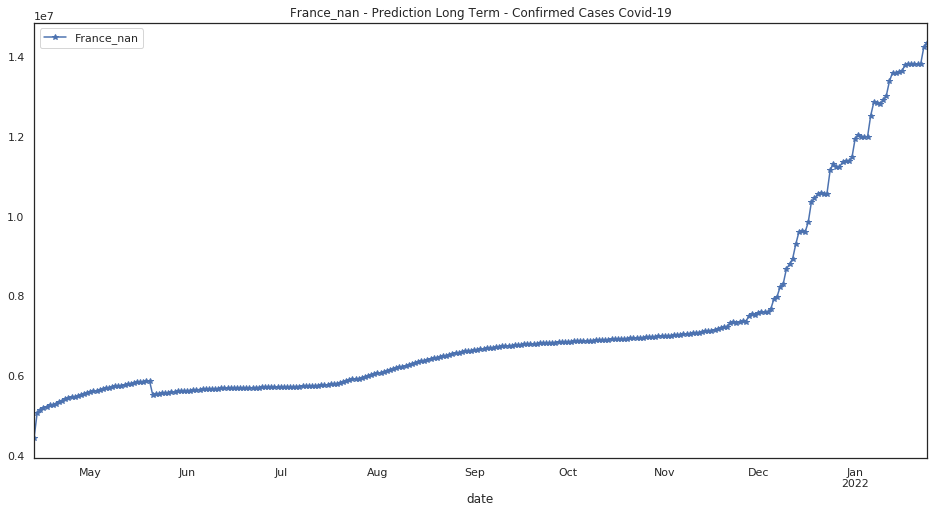

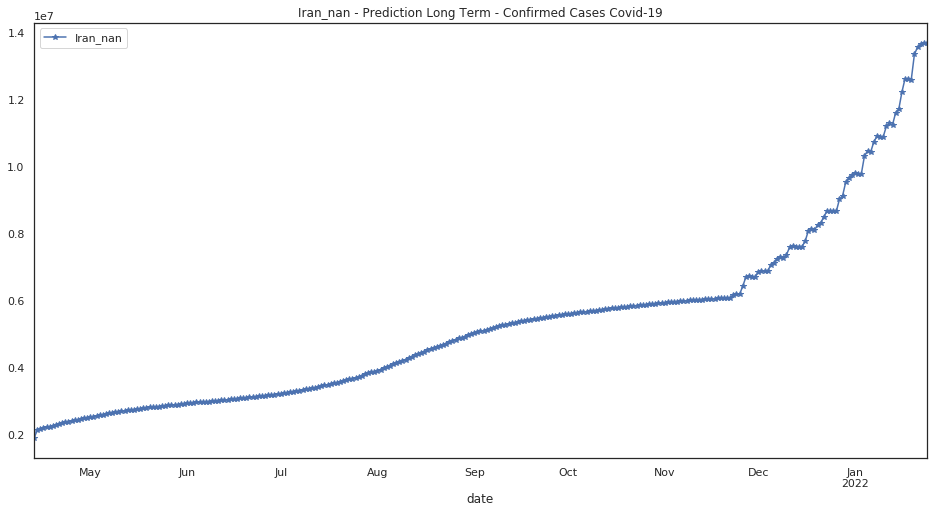

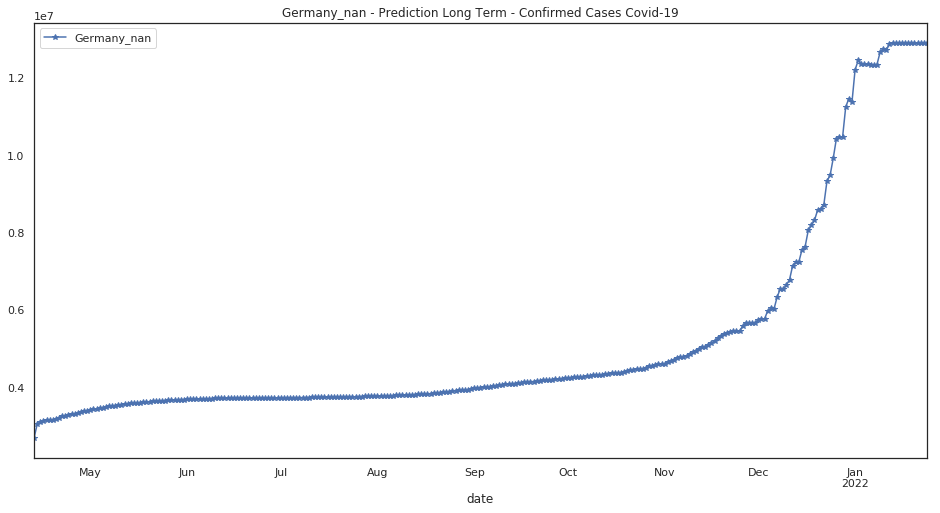

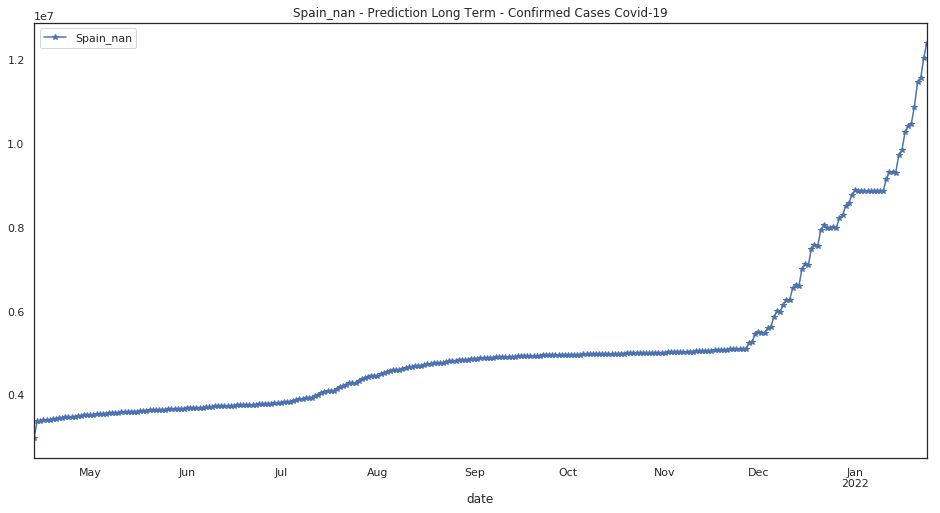

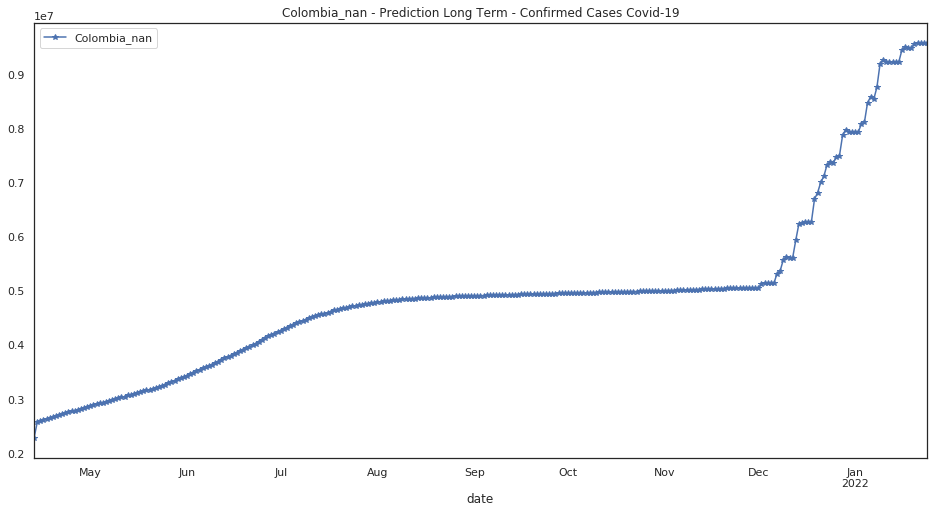

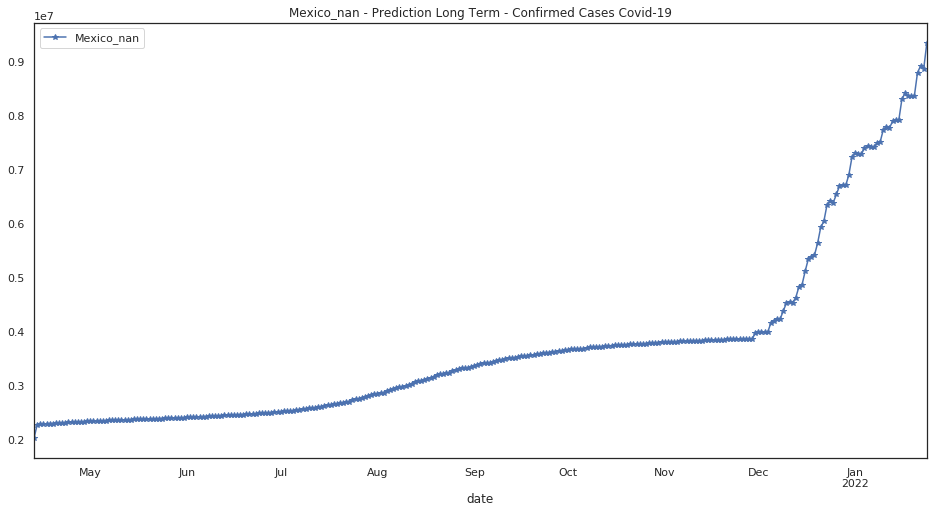

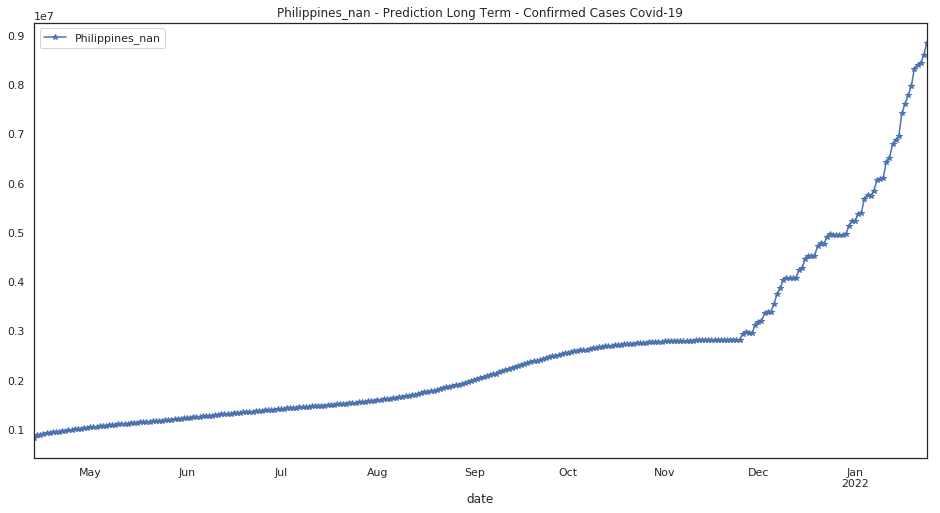

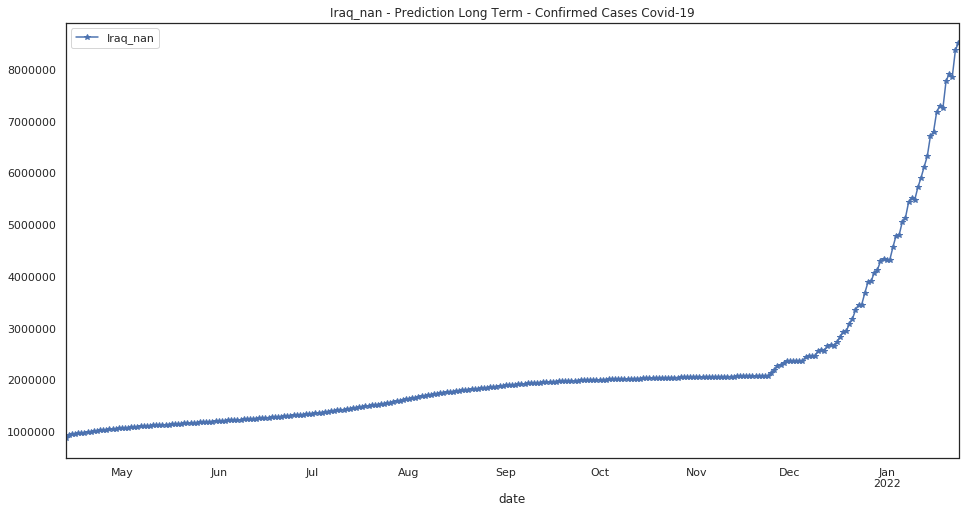

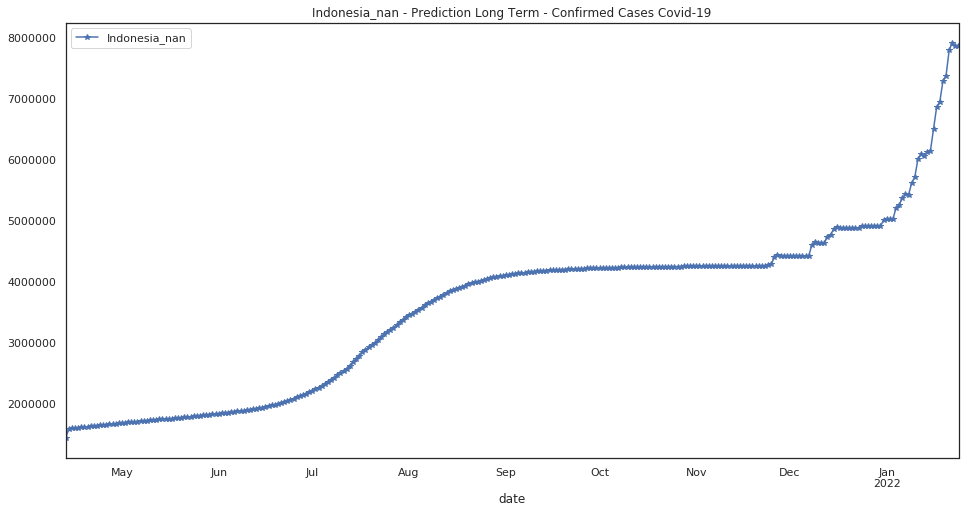

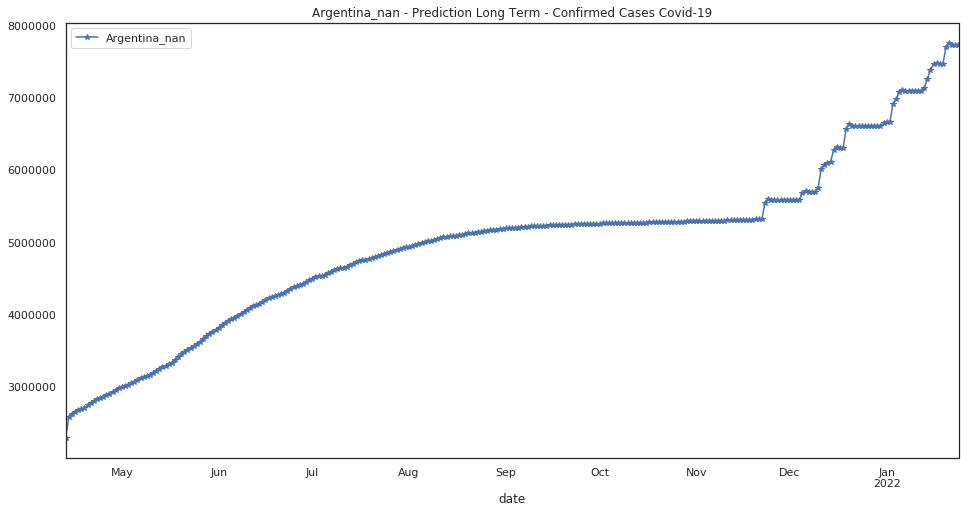

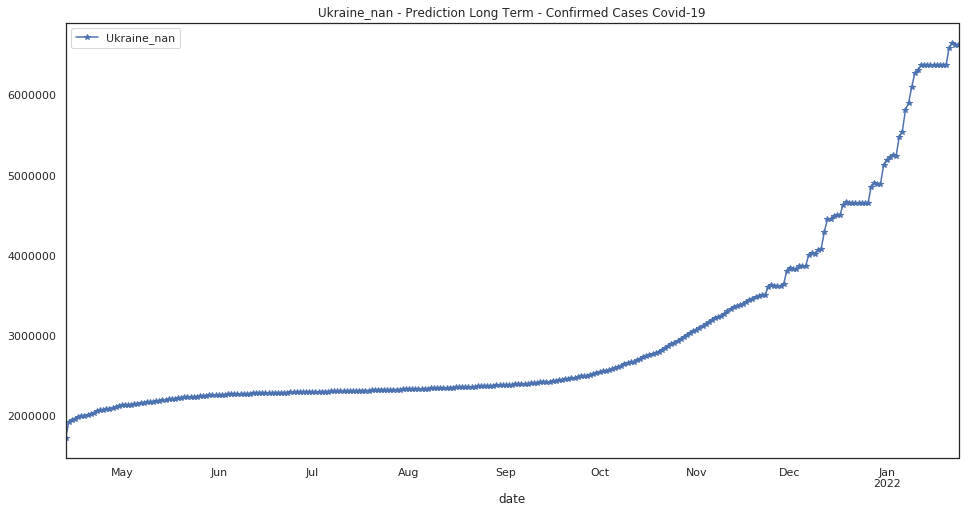

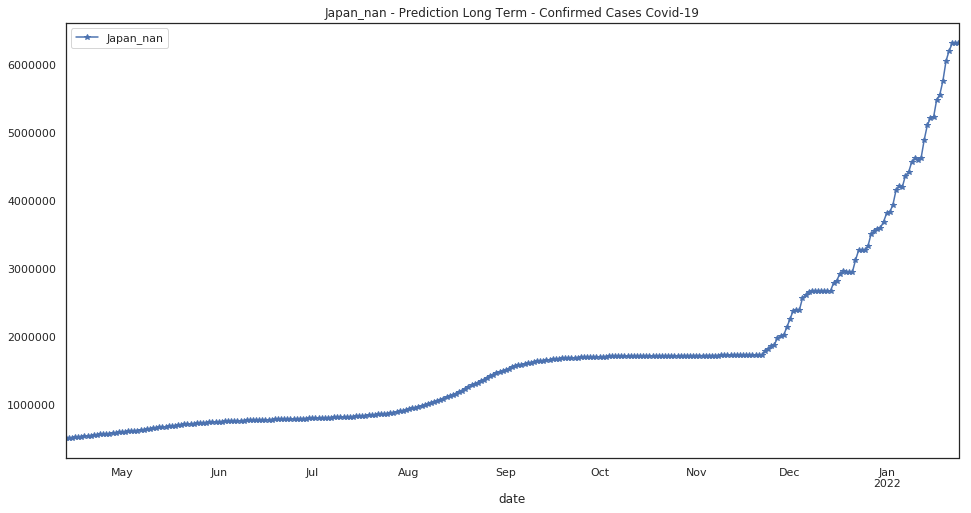

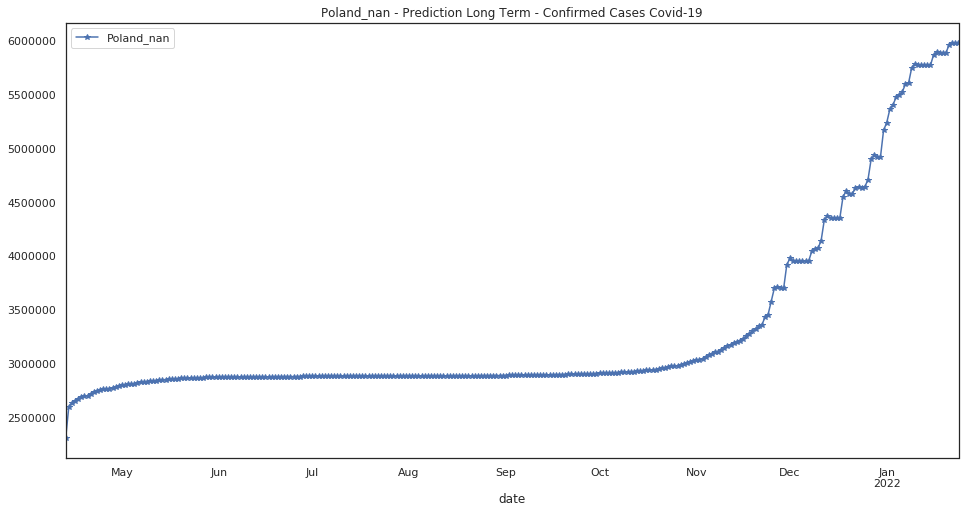

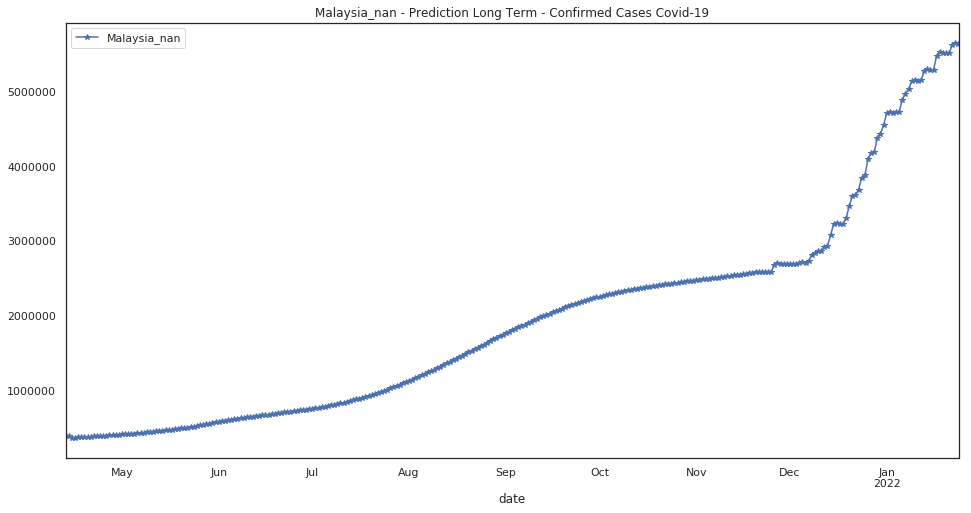

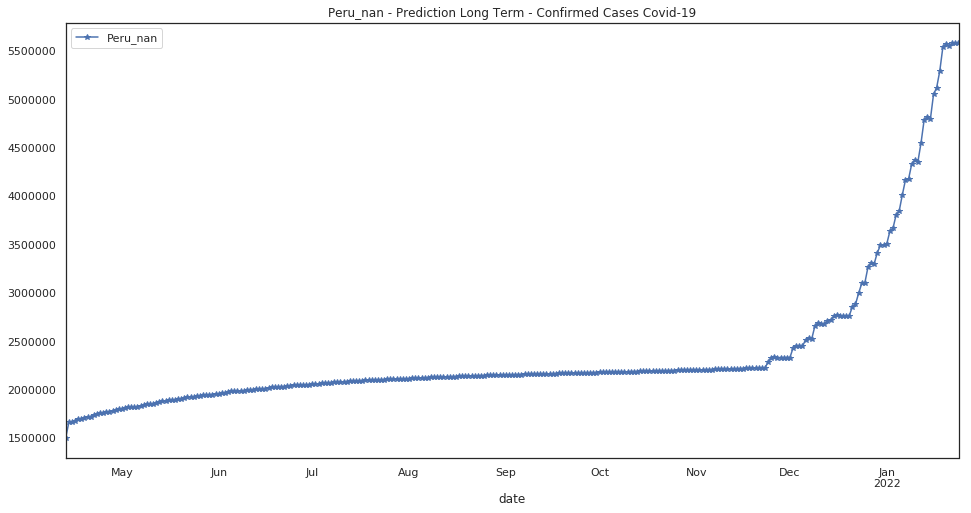

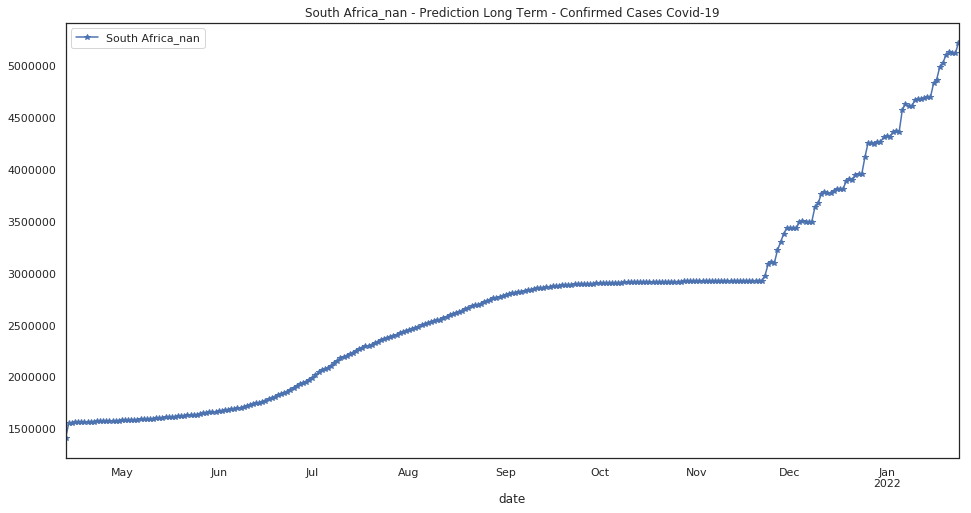

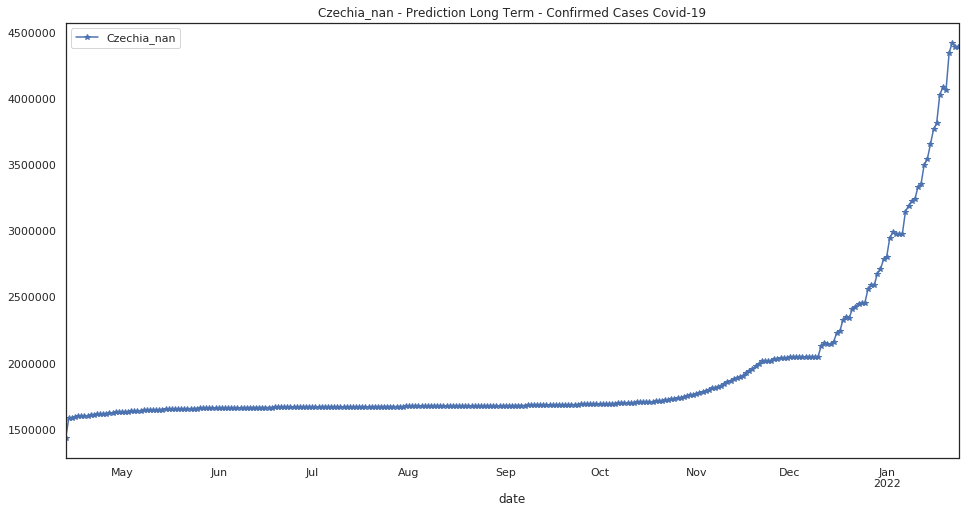

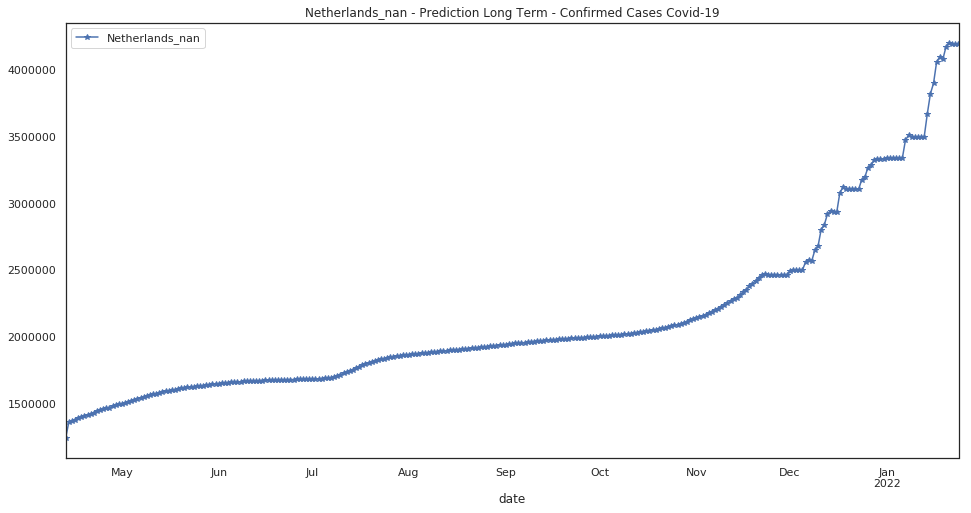

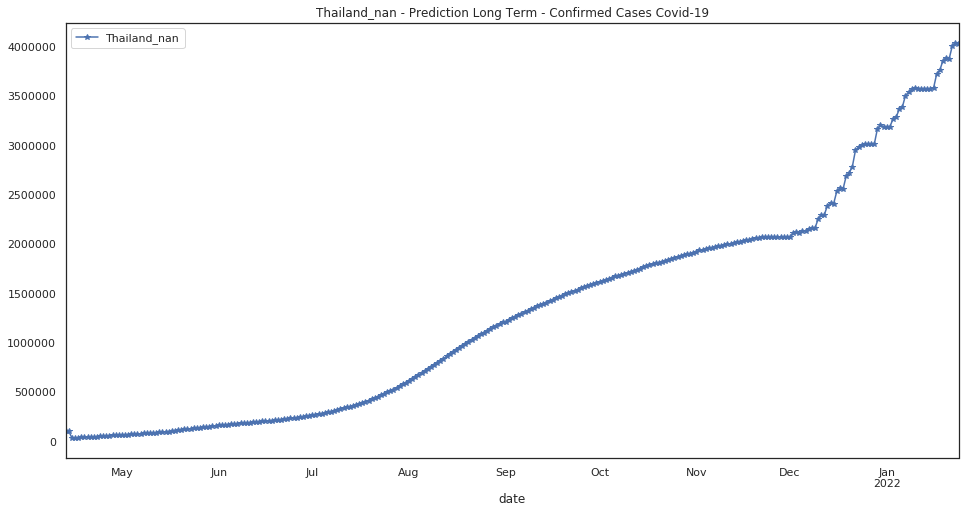

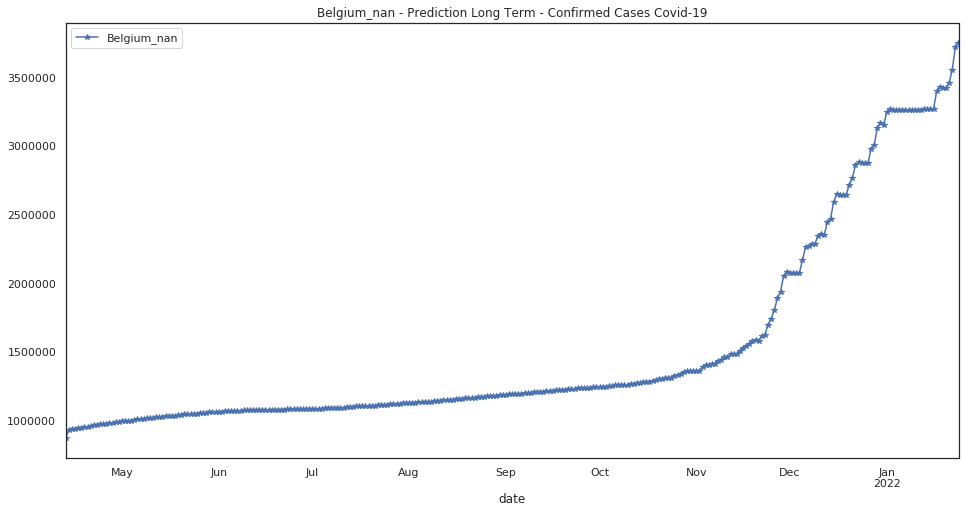

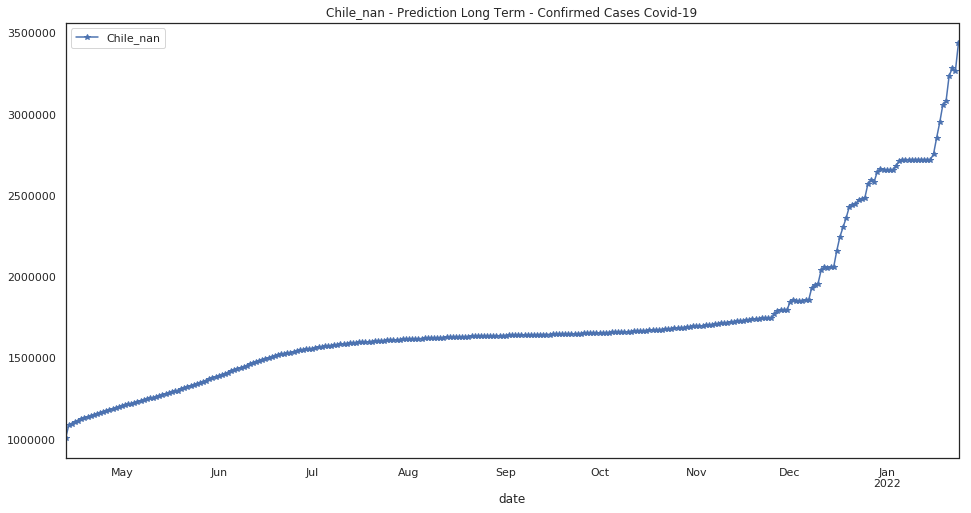

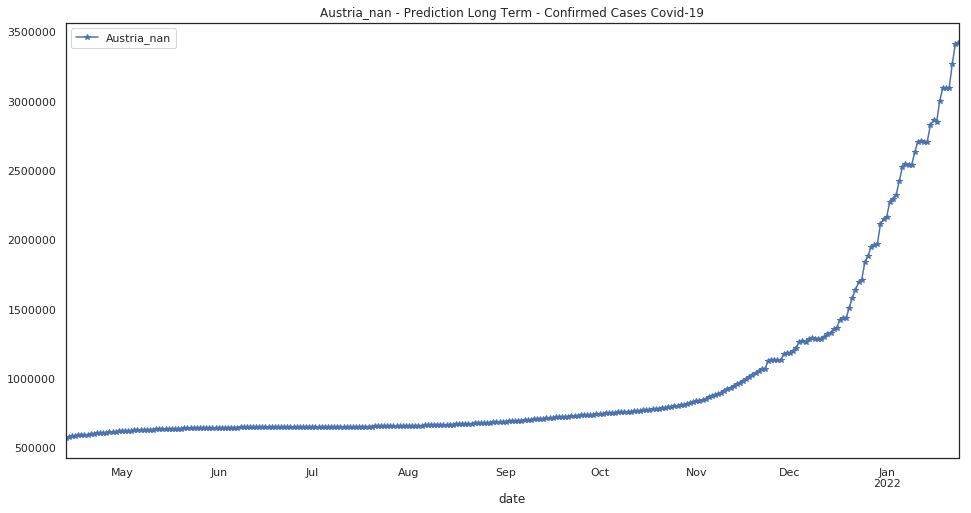

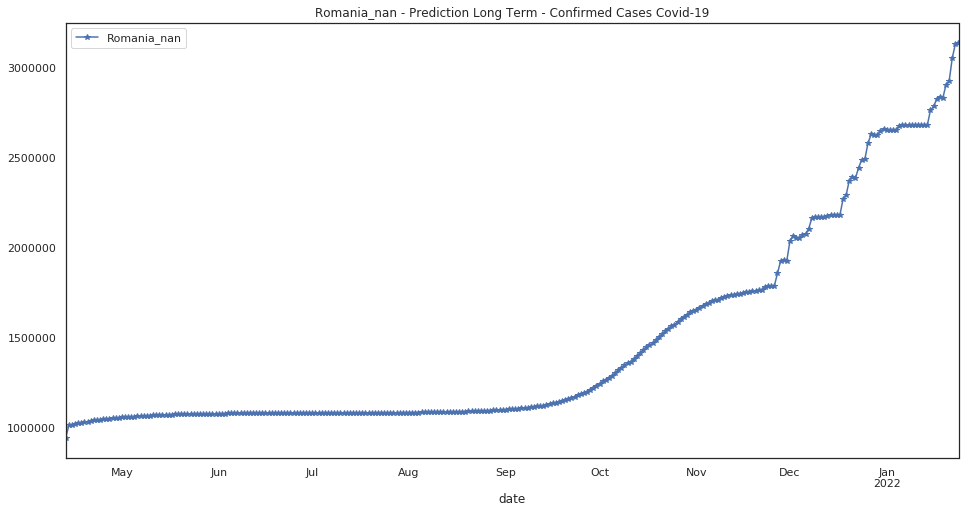

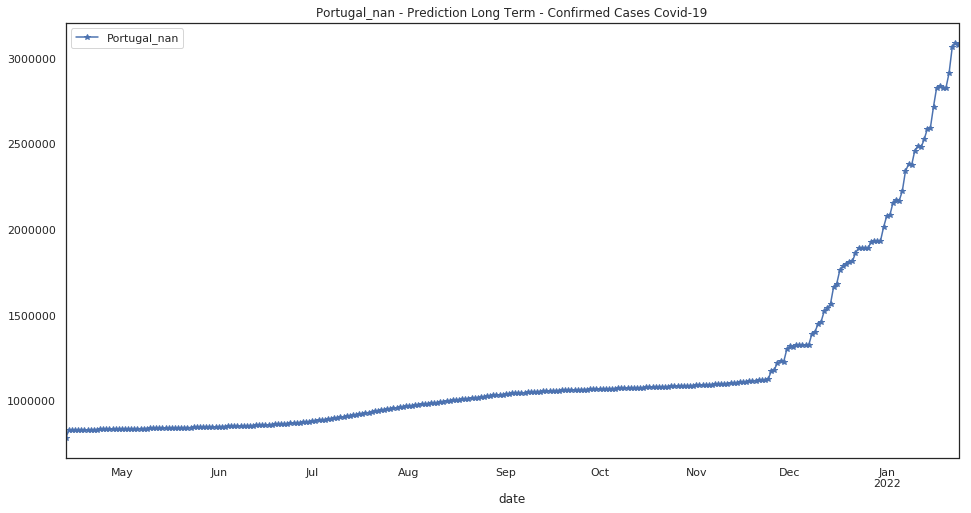

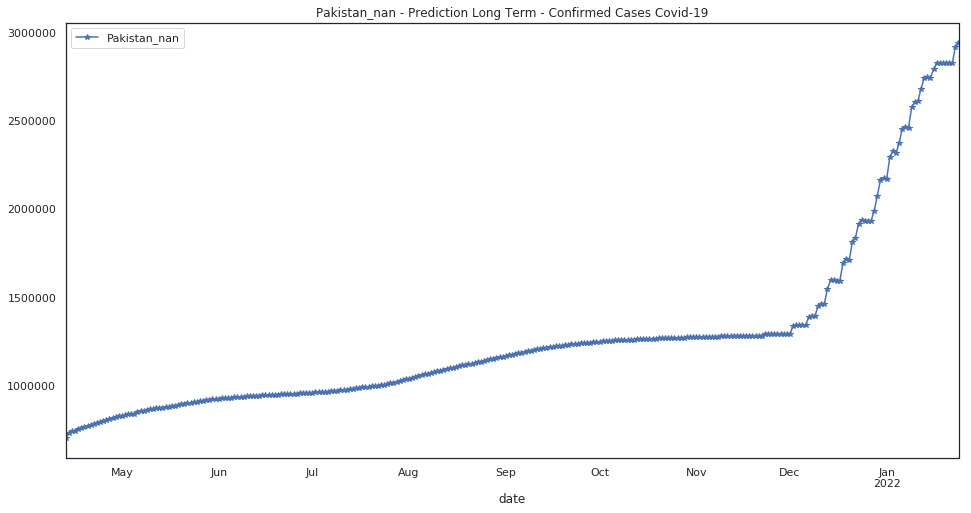

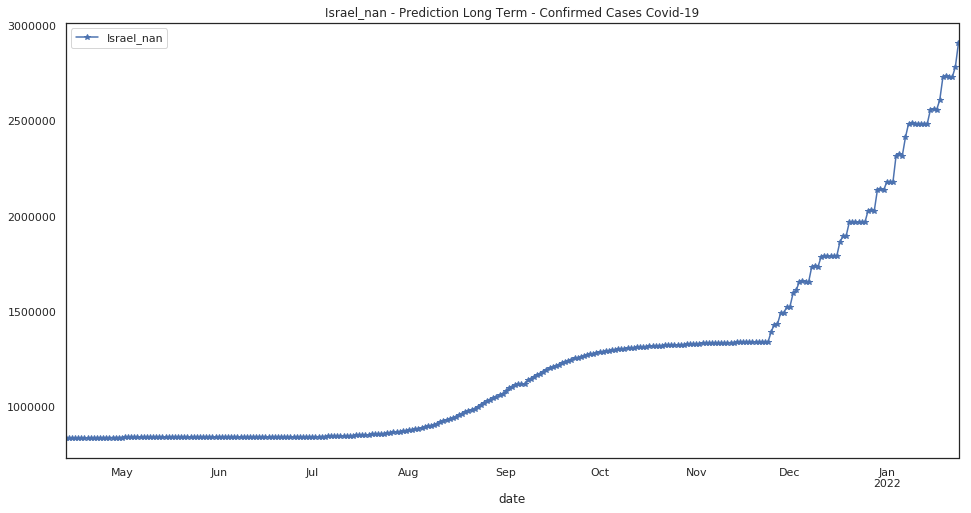

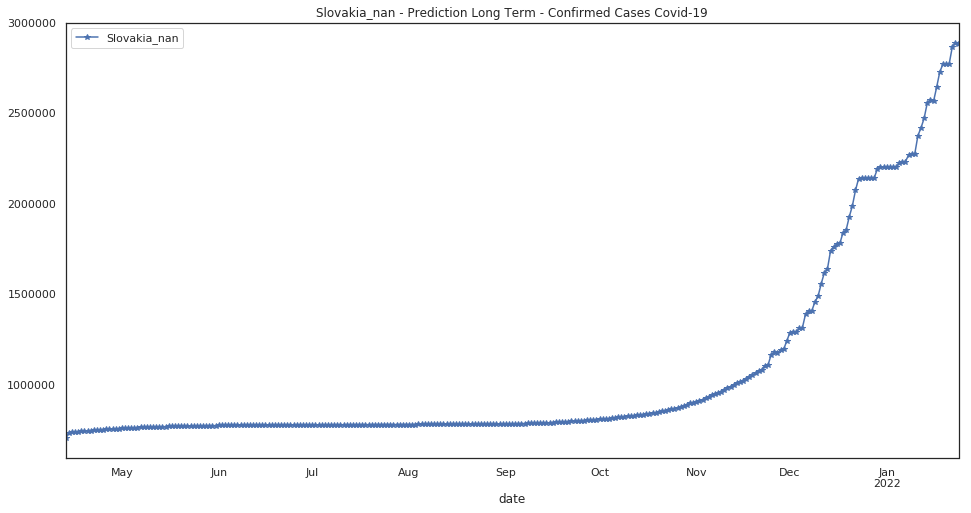

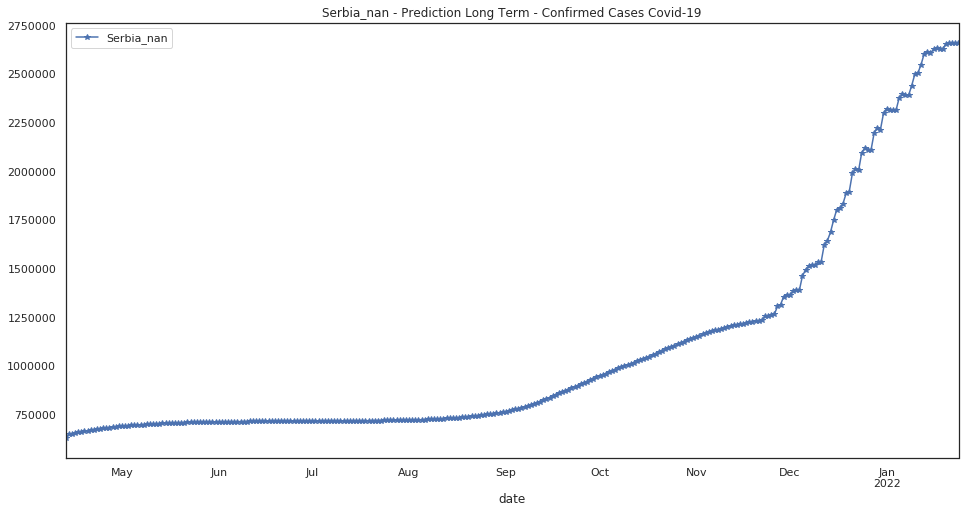

In [78]:
#
rgsx=region[:35]
for i in range (0,len(rgsx)):
        rg_print=rgsx[i]
        pred_prg=pd.DataFrame()
        pred_prg=pred[rg_print]
        pred_prg[:].plot(marker='*',figsize=(16,8),title =rg_print+' - Prediction Long Term - Confirmed Cases Covid-19')
        plt.legend(loc = 'upper left')
        plt.show()
#

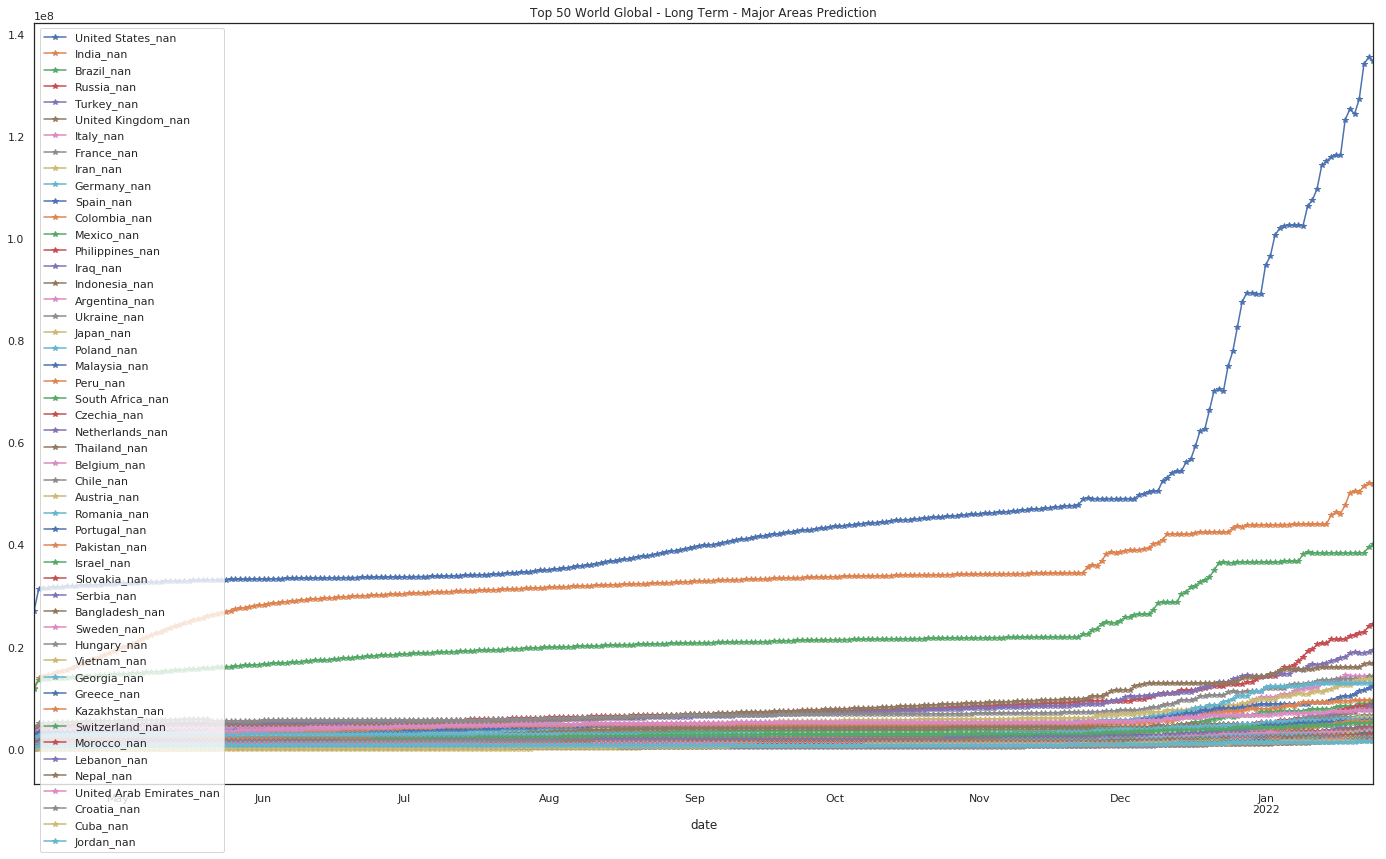

In [79]:
#region=my_train_list
pv2=pred
pv2=pv2.reindex(pv2.max().sort_values(ascending=False).index, axis=1)
pv2[:].iloc[:,0:50].plot(marker='*',figsize=(24,14),title ='Top 50 World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()

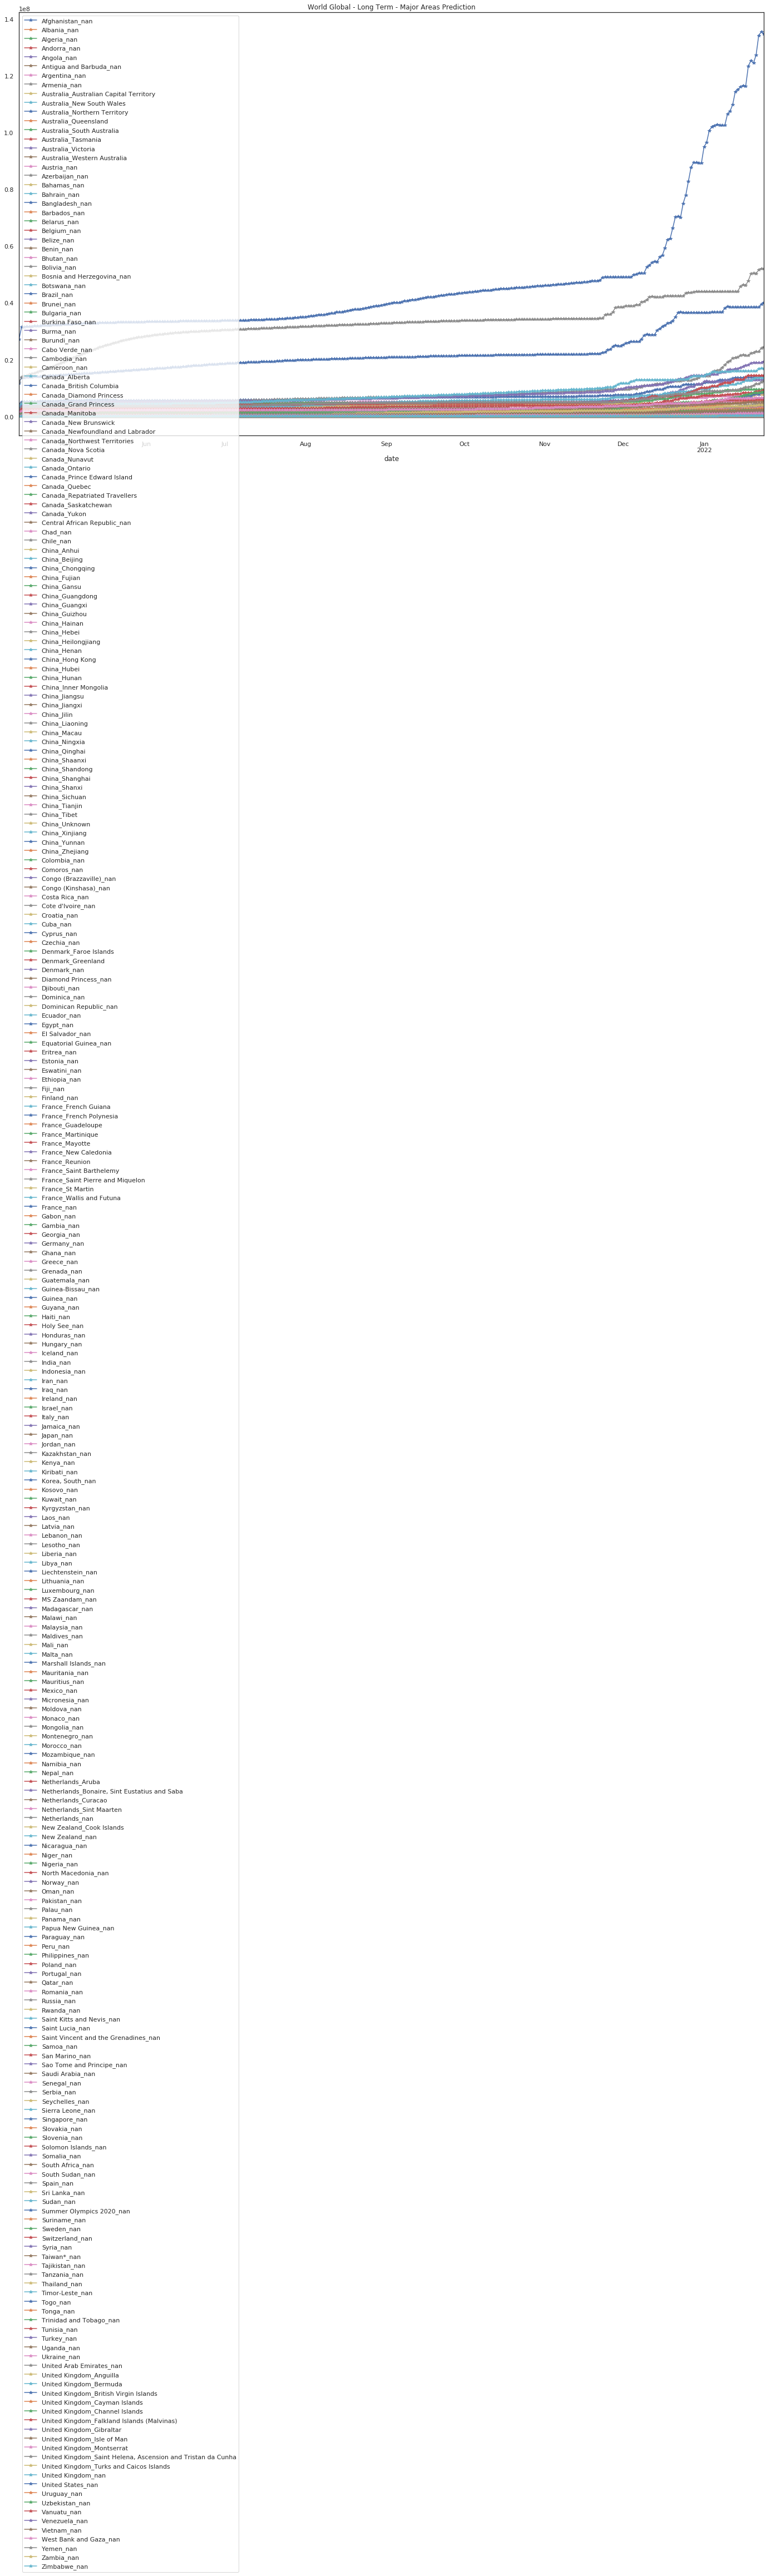

In [80]:
#region=my_train_list
pv2=pred
pv2[:].plot(marker='*',figsize=(24,14),title ='World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()


## Prediction Heatmap

In [81]:
pv1=pv2[:] #p  #p2.append(p3).append(p4).append(p5).append(p6).append(p8).append(p9).append(p11)
p=pd.DataFrame(pv1)

In [82]:
p[45:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2021-05-28          69675.0     132976.0     129137.0      13682.0   
2021-05-29          70502.0     132989.0     129402.0      13693.0   
2021-05-30          71011.0     133005.0     129676.0      13693.0   
2021-05-31          72374.0     133011.0     129871.0      13693.0   
2021-06-01          73124.0     133033.0     130196.0      13727.0   
2021-06-02          74160.0     133041.0     130547.0      13729.0   
2021-06-03          75369.0     133055.0     130845.0      13744.0   
2021-06-04          76802.0     133069.0     131269.0      13752.0   
2021-06-05          77832.0     133070.0     131579.0      13758.0   
2021-06-06          79302.0     133079.0     131891.0      13758.0   
2021-06-07          80971.0     133082.0     132229.0      13758.0   
2021-06-08          82202.0     133094.0     132566.0      13777.0   
2021-06-09          84041.0     133108.0     132933.0      13781.0   
2021-06-10          85724.0     133118.0     133255.0      13791.0   
2021-06-11          87507.0     133132.0     133651.0      13805.0   
2021-06-12          88705.0     133144.0     133974.0      13813.0   
2021-06-13          90408.0     133154.0     134309.0      13813.0   
2021-06-14          91840.0     133158.0     134670.0      13813.0   
2021-06-15          93271.0     133168.0     135024.0      13826.0   
2021-06-16          93436.0     133172.0     135364.0      13828.0   
2021-06-17          97443.0     133178.0     135754.0      13836.0   
2021-06-18          97602.0     133182.0     136117.0      13839.0   
2021-06-19         100251.0     133187.0     136488.0      13842.0   
2021-06-20         102077.0     133188.0     136748.0      13842.0   
2021-06-21         104203.0     133189.0     137243.0      13842.0   
2021-06-22         105690.0     133195.0     137537.0      13864.0   
2021-06-23         107964.0     133194.0     137950.0      13864.0   
2021-06-24         109493.0     133198.0     138317.0      13873.0   
2021-06-25         111841.0     133204.0     138688.0      13877.0   
2021-06-26         113177.0     133205.0     139026.0      13882.0   
...                     ...          ...          ...          ...   
2021-12-26         217756.0     258007.0     247193.0      20915.0   
2021-12-27         226542.0     268078.0     247193.0      20915.0   
2021-12-28         226328.0     269420.0     256878.0      21296.0   
2021-12-29         228735.0     273152.0     257442.0      21296.0   
2021-12-30         228554.0     282360.0     263190.0      21296.0   
2021-12-31         228593.0     293404.0     265085.0      21364.0   
2022-01-01         238554.0     296296.0     266251.0      21364.0   
2022-01-02         247047.0     306058.0     269867.0      21364.0   
2022-01-03         249752.0     306683.0     269830.0      22560.0   
2022-01-04         251309.0     307312.0     278899.0      22560.0   
2022-01-05         260144.0     323514.0     285292.0      22560.0   
2022-01-06         260210.0     325520.0     286928.0      22560.0   
2022-01-07         271060.0     326199.0     288957.0      22560.0   
2022-01-08         271097.0     338730.0     290635.0      22560.0   
2022-01-09         282176.0     344110.0     290714.0      22560.0   
2022-01-10         282274.0     360690.0     290997.0      23379.0   
2022-01-11         288683.0     363155.0     304462.0      23379.0   
2022-01-12         288702.0     363864.0     305426.0      23379.0   
2022-01-13         289874.0     363617.0     317937.0      23379.0   
2022-01-14         289878.0     369387.0     318425.0      23379.0   
2022-01-15         289791.0     385126.0     319838.0      23379.0   
2022-01-16         292077.0     393782.0     330165.0      23379.0   
2022-01-17         303921.0     405652.0     330458.0      23379.0   
2022-01-18         313918.0     407353.0     331952.0      23379.0   
2022-01-19

In [83]:
pfname='data/p+'+str(num_days_R_prediction)+'_confirmed_daily.csv'
p.to_csv(pfname, index = False, header=True)

In [84]:
#!pip install gmplot
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [85]:
heatmap=confirmed[['region','Lat','Long']]
p_m=p.T # pred.T #
### JOAO - Change Global HeapMap print - USA is too small, as USA States datasets are not used! 
#heatmap=heatmap[heatmap['region'].isin(region)]  ## heatmap for region dataset only 
heatmap=heatmap[heatmap['region'].isin(confirmed['region'])] ## Global heatmap
p_m=p_m.reset_index()
heatmap_m=heatmap.merge(p_m,how='left',on='region')


In [86]:
heatmap_m[:]

region        Lat        Long  \
0                                      Afghanistan_nan  33.939110   67.709953   
1                                          Albania_nan  41.153300   20.168300   
2                                          Algeria_nan  28.033900    1.659600   
3                                          Andorra_nan  42.506300    1.521800   
4                                           Angola_nan -11.202700   17.873900   
5                              Antigua and Barbuda_nan  17.060800  -61.796400   
6                                        Argentina_nan -38.416100  -63.616700   
7                                          Armenia_nan  40.069100   45.038200   
8               Australia_Australian Capital Territory -35.473500  149.012400   
9                            Australia_New South Wales -33.868800  151.209300   
10                        Australia_Northern Territory -12.463400  130.845600   
11                                Australia_Queensland -27.469800  153.025100   
12                           Australia_South Australia -34.928500  138.600700   
13                                  Australia_Tasmania -42.882100  147.327200   
14                                  Australia_Victoria -37.813600  144.963100   
15                         Australia_Western Australia -31.950500  115.860500   
16                                         Austria_nan  47.516200   14.550100   
17                                      Azerbaijan_nan  40.143100   47.576900   
18                                         Bahamas_nan  25.025885  -78.035889   
19                                         Bahrain_nan  26.027500   50.550000   
20                                      Bangladesh_nan  23.685000   90.356300   
21                                        Barbados_nan  13.193900  -59.543200   
22                                         Belarus_nan  53.709800   27.953400   
23                                         Belgium_nan  50.833300    4.469936   
24                                          Belize_nan  17.189900  -88.497600   
25                                           Benin_nan   9.307700    2.315800   
26                                          Bhutan_nan  27.514200   90.433600   
27                                         Bolivia_nan -16.290200  -63.588700   
28                          Bosnia and Herzegovina_nan  43.915900   17.679100   
29                                        Botswana_nan -22.328500   24.684900   
..                                                 ...        ...         ...   
256                                           Togo_nan   8.619500    0.824800   
257                                          Tonga_nan -21.179000 -175.198200   
258                            Trinidad and Tobago_nan  10.691800  -61.222500   
259                                        Tunisia_nan  33.886917    9.537499   
260                                         Turkey_nan  38.963700   35.243300   
261                                  United States_nan  40.000000 -100.000000   
262                                         Uganda_nan   1.373333   32.290275   
263                                        Ukraine_nan  48.379400   31.165600   
264                           United Arab Emirates_nan  23.424076   53.847818   
265                            United Kingdom_Anguilla  18.220600  -63.068600   
266                             United Kingdom_Bermuda  32.307800  -64.750500   
267              United Kingdom_British Virgin Islands  18.420700  -64.640000   
268                      United Kingdom_Cayman Islands  19.313300  -81.254600   
269                     United Kingdom_Channel Islands  49.372300   -2.364400   
270         United Kingdom_Falkland Islands (Malvinas) -51.796300  -59.523600   
271                           United Kingdom_Gibraltar  36.140800   -5.353600   
272                         United Kingdom_Isle of Man  54.236100   -4.548100   
273                          United Kingdom_Montserrat  16.742498  -62.187366  

In [87]:
# Fill empty lat,long with 0
heatmap_m['Lat']=heatmap_m['Lat'].fillna(0)
heatmap_m['Long']=heatmap_m['Long'].fillna(0)
#
heatmap_m_fn="heatmap_m_"+str(num_days_R_prediction)+".csv"
heatmap_m.to_csv(r'data/'+heatmap_m_fn, index = False, header=True)

In [88]:
#!pip install folium
import folium
import re

lat=40.99474
lang=6.87237

p21_cluster=folium.Map(location=[lat,lang],zoom_start=3)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat,lng,num,totpred,lastday7DayAvg,today7DayAvg in zip(heatmap_m.Lat,heatmap_m.Long,range(0,heatmap_m.shape[0]), heatmap_m[heatmap_m.columns[-1]], \
                                                           (heatmap_m[heatmap_m.columns[-1]]-heatmap_m[heatmap_m.columns[ndayarray]])/ndaysavg, \
                                                           (heatmap_m[heatmap_m.columns[ndayarray]]-heatmap_m[heatmap_m.columns[n2dayarray]])/ndaysavg):
    use_color=heatmap_m['region'][num][0]
    print_region=re.sub('_nan',  '', heatmap_m['region'][num])
    popup = folium.Popup( print_region+' Current7DayAVG='+str(round(today7DayAvg))+' Predicted7DayAVG='+str(round(lastday7DayAvg))+' ConfTotPred='+str(round(totpred))+' Date='+date_pred , parse_html=True)
    #
    folium.Marker(
                    [lat,lng],
                    popup=popup,
                    icon=folium.Icon(color=colors[use_color])
            ).add_to(p21_cluster)
p21_cluster

In [89]:
# Top 50 Regions in the World impacted
#
max_cont=max_countries_map
region_m2=region[:max_cont]
#
heatmap_m2=heatmap_m[heatmap_m['region'].isin(region_m2)].reset_index()
#
heatmap_m2[:]

index                    region        Lat        Long  \
0       6             Argentina_nan -38.416100  -63.616700   
1      16               Austria_nan  47.516200   14.550100   
2      20            Bangladesh_nan  23.685000   90.356300   
3      23               Belgium_nan  50.833300    4.469936   
4      30                Brazil_nan -14.235000  -51.925300   
5      59                 Chile_nan -35.675100  -71.543000   
6      94              Colombia_nan   4.570900  -74.297300   
7     100               Croatia_nan  45.100000   15.200000   
8     101                  Cuba_nan  21.521757  -77.781167   
9     103               Czechia_nan  49.817500   15.473000   
10    132                France_nan  46.227600    2.213700   
11    135               Georgia_nan  42.315400   43.356900   
12    136               Georgia_nan  42.315400   43.356900   
13    137               Germany_nan  51.165691   10.451526   
14    139                Greece_nan  39.074200   21.824300   
15    149               Hungary_nan  47.162500   19.503300   
16    151                 India_nan  20.593684   78.962880   
17    152             Indonesia_nan  -0.789300  113.921300   
18    153                  Iran_nan  32.427908   53.688046   
19    154                  Iraq_nan  33.223191   43.679291   
20    156                Israel_nan  31.046051   34.851612   
21    157                Israel_nan  31.046051   34.851612   
22    158                 Italy_nan  41.871940   12.567380   
23    160                 Japan_nan  36.204824  138.252924   
24    161                Jordan_nan  31.240000   36.510000   
25    162            Kazakhstan_nan  48.019600   66.923700   
26    171               Lebanon_nan  33.854700   35.862300   
27    172               Lebanon_nan  33.854700   35.862300   
28    182              Malaysia_nan   4.210484  101.975766   
29    189                Mexico_nan  23.634500 -102.552800   
30    195               Morocco_nan  31.791700   -7.092600   
31    198                 Nepal_nan  28.166700   84.250000   
32    203           Netherlands_nan  52.132600    5.291300   
33    212              Pakistan_nan  30.375300   69.345100   
34    217                  Peru_nan  -9.190000  -75.015200   
35    218           Philippines_nan  12.879721  121.774017   
36    219                Poland_nan  51.919400   19.145100   
37    220              Portugal_nan  39.399900   -8.224500   
38    222               Romania_nan  45.943200   24.966800   
39    223                Russia_nan  61.524010  105.318756   
40    233                Serbia_nan  44.016500   21.005900   
41    237              Slovakia_nan  48.669000   19.699000   
42    241          South Africa_nan -30.559500   22.937500   
43    243                 Spain_nan  40.463667   -3.749220   
44    248                Sweden_nan  60.128161   18.643501   
45    249           Switzerland_nan  46.818200    8.227500   
46    254              Thailand_nan  15.870032  100.992541   
47    260                Turkey_nan  38.963700   35.243300   
48    261         United States_nan  40.000000 -100.000000   
49    263               Ukraine_nan  48.379400   31.165600   
50    264  United Arab Emirates_nan  23.424076   53.847818   
51    276        United Kingdom_nan  55.378100   -3.436000   
52    281               Vietnam_nan  14.058324  108.277199   

    2021-04-13 00:00:00  2021-04-14 00:00:00  2021-04-15 00:00:00  \
0             2290669.0            2579000.0            2623192.0   
1              572418.0             581263.0             584205.0   
2              672810.0             697985.0             703251.0   
3              872885.0             930603.0             935316.0   
4            11769814.0           13599994.0           13736653.0   
5             1008872.0            1088710.0            1096797.0   
6             2282338.0            2569314.0            2597253.0   
7              326095.0             328760.0             297973.0   
8              148545.0           

In [90]:
import folium
import re

lat=40.99474
lang=6.87237

p21_reg_cluster=folium.Map(location=[lat,lang],zoom_start=3)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_reg_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat2,lng2,num2,totpred2,lastday7DayAvg2,today7DayAvg2 in zip(heatmap_m2.Lat,heatmap_m2.Long,range(0,heatmap_m2.shape[0]), heatmap_m2[heatmap_m2.columns[-1]], \
                                                                (heatmap_m2[heatmap_m2.columns[-1]]-heatmap_m2[heatmap_m2.columns[ndayarray]])/ndaysavg, \
                                                                (heatmap_m2[heatmap_m2.columns[ndayarray]]-heatmap_m2[heatmap_m2.columns[n2dayarray]])/ndaysavg):
    use_color2=heatmap_m2['region'][num2][0]
    print_region=re.sub('_nan',  '', heatmap_m2['region'][num2])
    popup2 = folium.Popup( print_region+' Current7DayAvg='+str(round(today7DayAvg2))+' Predicted7DayAvg='+str(round(lastday7DayAvg2))+' ConfTotPred='+str(round(totpred2))+' Date='+date_pred, parse_html=True)  
    #
    folium.Marker(
                    [lat2,lng2],
                    popup=popup2,
                    icon=folium.Icon(color=colors[use_color2])
            ).add_to(p21_reg_cluster)
p21_reg_cluster

In [91]:
#
datemap=datetime.today().strftime('%Y-%m-%d')
p21_cluster.save("heatmaps/Heatmap_Folium-Global-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")
#
p21_reg_cluster.save("heatmaps/Heatmap_Folium-Regional-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")

In [92]:
print("Stats and Forecast Done for Today!")
print("I'm done with this past month of March, April and May!")
print(" April-May-June-July are going to be hard with this Global Lock-Down!")

Stats and Forecast Done for Today!
I'm done with this past month of March, April and May!
 April-May-June-July are going to be hard with this Global Lock-Down!


In [93]:
exit()